<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Total/Total_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "FPFREUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 18:51:43,728 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 18:51:43,731 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for FPFREUR
2019-08-27 18:55:50,703 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 19:05:03,079 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 19:09:36,182 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 19:13:58,115 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 19:17:53,056 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 19:22:17,023 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 19:26:49,891 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 19:31:14,190 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 19:44:37,269 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_FPFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-FPFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-FPFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.46393  0.46393  0.46072  0.46093  6.232818
2018-01-02 09:00:00  0.46098  0.46178  0.46013  0.46138  6.531419
2018-01-02 10:00:00  0.46138  0.46142  0.45897  0.45987  3.914869
2018-01-02 11:00:00  0.45983  0.45993  0.45917  0.45938  3.080256
2018-01-02 12:00:00  0.45943  0.46038  0.45943  0.46002  2.239062
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.46498  0.46623  0.46263  0.46288  7.115447
2018-12-31 09:00:00  0.46293  0.46373  0.46157  0.46373  5.046100
2018-12-31 10:00:00  0.46377  0.46683  0.46377  0.46677  3.506766
2018-12-31 11:00:00  0.46677  0.46752  0.46377  0.46378  4.382395
2018-12-31 12:00:00  0.46377  0.46413  0.46157  0.46267  5.591858

[2276 rows x 5 columns]

Open         High          Low        Close       Volume
count  2276.000000  2276.000000  2276.000000  2276.000000  2276.000000
mean      0.506668     0.508044     0.505432     0.506767     6.756291
std       0.031995     0.032035     0.032000     0.032026     3.327002
min       0.434520     0.440530     0.433980     0.437220     0.023560
25%       0.477840     0.478880     0.476457     0.477760     4.380198
50%       0.514775     0.516280     0.512920     0.514730     6.010725
75%       0.532173     0.533405     0.530870     0.532273     8.164741
max       0.566670     0.568080     0.564780     0.566680    28.619873

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.48408  0.48478  0.48348  0.48363  3.547558    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.483023  0.479363  0.481119  0.483824  0.482798  0.481725    0.482670    0.482425  0.480294  0.482641  0.483816  0.482594  0.483078  0.482641  0.483723  0.480740                0.484510                 0.482641                0.480773                0.485444                 0.482641                0.479838                0.486378                 0.482641                0.478904                0.487313                 0.482641                0.477970  0.482798  0.483558  0.481088                0.484667                 0.482798                0.480930                0.485601                 0.482798                0.479995                0.486535                 0.482798                0.479061                0.487470                 0.482798   
2018-01-09 14:00:00  0.48368  0.48493  0.48172  0.48199  8.478673    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.482506  0.480149 -0.484930  0.483276  0.482619  0.481726    0.482670    0.482500  0.480653  0.482661  0.482984  0.482892  0.482933  0.482661  0.482810  0.481011                0.484498                 0.482661                0.480825                0.485416                 0.482661                0.479906                0.486334                 0.482661                0.478988                0.487253                 0.482661                0.478070  0.482619  0.482551  0.481344                0.484455                 0.482619                0.480782                0.485374                 0.482619                0.479864                0.486292                 0.482619                0.478946                0.487210                 0.482619   
2018-01-09 15:00:00  0.48198  0.48344  0.48143  0.48322 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000    2226.000000  2226.000000   2226.000000      2226.00000     2226.000000       2226.000000  2226.000000  2226.000000  2226.000000  2226.000000   2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000  2226.000000  2226.000000  2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000   
mean      0.507444     0.508829     0.506195     0.507538     6.807653    16.002246     2.019766   185.466307      30.424978    11.373765      0.034142         0.02381        0.002246          0.004043     6.598383     2.534142    26.946990     2.019766      2.005840    26.946990     0.507741     0.507932     0.027988     0.507538     0.507569     0.507463     0.507546     0.507417     0.507391     0.507569     0.507539     0.507568     0.507558     0.507569     0.507548     0.507633                0.511492                 0.507569                0.503645                0.513454                 0.507569                0.501683                0.515416                 0.507569                0.499721                0.517378                 0.507569                0.497759     0.507569     0.507545     0.507623                0.511493                 0.507569                0.503645                0.513455                 0.507569                0.501683                0.515417   
std       0.031900     0.031930     0.031919     0.031937     3.340235     8.586087     1.412803   101.852517       0.852747     2.620664      0.181635         0.15249        0.047351          0.063471     3.351669     1.103194    14.550829     1.412803      1.403835    14.550829     0.031827     0.031560     0.507537     0.031979     0.031777     0.031857     0.031835     0.031819     0.031941     0.031821     0.031956     0.031840     0.031845     0.031821     0.031901     0.031588                0.032023                 0.031821                0.031798                0.032191                 0.031821                0.031853                0.032401                 0.031821                0.031954                0.032655                 0.031821                0.032098     0.031777     0.031894     0.031624                0.031980                 0.031777                0.031753                0.032148                 0.031777                0.031809                0.032359   
min       0.434520     0.440530     0.4339

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.375028  0.346923  0.378440  0.358489  0.123233    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.338853  0.281750  0.929313  0.363307  0.335409  0.324618    0.339749    0.340964  0.345372  0.339609  0.360329  0.339785  0.345490  0.339609  0.347925  0.306477                0.325867                 0.339609                0.370011                0.302990                 0.339609                0.394321                0.282209                 0.339609                0.416975                0.263248                 0.339609                0.438136  0.335409  0.352455  0.312862                0.322688                 0.335409                0.373579                0.305878                 0.335409                0.397690                0.287540                 0.335409                0.420164                0.268228                 0.335409   
2018-01-09 14:00:00  0.372002  0.348099  0.364985  0.345821  0.295671    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.334651  0.288518  0.073649  0.359016  0.333941  0.324633    0.339749    0.341566  0.348048  0.339771  0.353810  0.342198  0.344326  0.339771  0.340676  0.308756                0.325769                 0.339771                0.370416                0.302773                 0.339771                0.394831                0.281884                 0.339771                0.417584                0.262824                 0.339771                0.438837  0.333941  0.344475  0.315001                0.320953                 0.333941                0.372434                0.304070                 0.333941                0.396705                0.285680                 0.333941                0.419328                0.266338                 0.333941   
2018-01-09 15:00:00  0.359137  0.336417  

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpy62hytvs
  JVM stdout: /tmp/tmpy62hytvs/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpy62hytvs/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_wp2aek
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_195507_mod...  0.547665  0.707828              0.487238  0.507025  0.257074
1  DeepLearning_grid_1_AutoML_20190827_195507_mod...  0.534742  2.488256              0.495652  0.645198  0.416281
2  DeepLearning_grid_1_AutoML_20190827_195507_mod...  0.513728  0.692782              0.491304  0.499817  0.249817
3  DeepLearning_grid_1_AutoML_20190827_195507_mod...  0.500644  0.693804              0.500000  0.500328  0.250328
4  DeepLearning_grid_1_AutoML_20190827_195507_mod...  0.500000  0.692659              0.500000  0.499756  0.249756
5  DeepLearning_grid_1_AutoML_20190827_195507_mod...  0.491304  0.692846              0.500000  0.499849  0.249849
6  DeepLearning_grid_1_AutoML_20190827_195507_mod...  0.488486  0.867377              0.486957  0.557298  0.310581
7  DeepLearning_grid_1_AutoML_20190827_195507_mod...  0.478905  1.018891              0.474477  0.589862  0.347937
8  DeepLearning_grid_1_AutoML_20190827_195507_mod...  0.440338  0.771817              0.495652  0.534459  0.285646
9              DeepLearning_1_AutoML_20190827_195507  0.440097  1.399257              0.491304  0.635347  0.403665

variable  relative_importance  scaled_importance  percentage
0                     ROCP_20             1.000000           1.000000    0.001035
1     BBANDS_lowerband_30_5_5             0.999270           0.999270    0.001035
2          LINEARREG_SLOPE_14             0.998696           0.998696    0.001034
3      BBANDS_upperband_8_3_3             0.996676           0.996676    0.001032
4     BBANDS_lowerband_12_0_3             0.995618           0.995618    0.001031
...                       ...                  ...                ...         ...
1033   BBANDS_lowerband_8_6_5             0.857862           0.857862    0.000888
1034  BBANDS_upperband_12_5_2             0.855857           0.855857    0.000886
1035                     SINH             0.855393           0.855393    0.000886
1036            MINMAX_max_20             0.854551           0.854551    0.000885
1037                    DX_24             0.846403           0.846403    0.000876

[1038 rows x 4 columns]

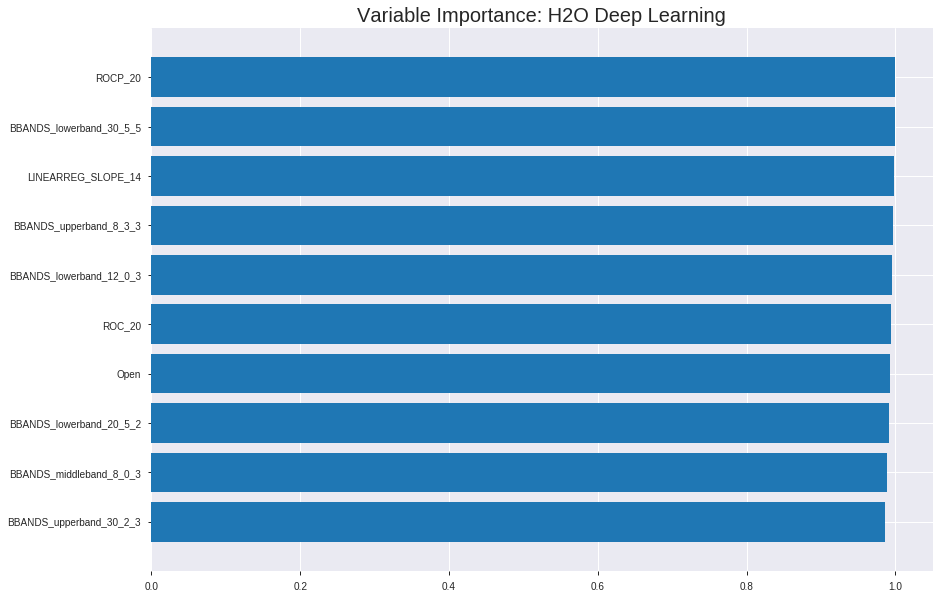

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_195507_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2651789453330594
RMSE: 0.514955284789912
LogLoss: 0.7236040630031184
Mean Per-Class Error: 0.4637918365725785
AUC: 0.542865937615845
pr_auc: 0.589109334905967
Gini: 0.08573187523169001
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3104547063690681: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    728   0.9891   (728.0/736.0)
1      0    821   0        (0.0/821.0)
Total  8    1549  0.4676   (728.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.310455     0.692827  392
max f2                       0.310455     0.849369  392
max f0point5                 0.331561     0.585487  365
max accuracy                 0.364054     0.538215  276
max precision                0.978648     1         0
max recall                   0.310455     1         392
max specificity              0.978648     1         0
max absolute_mcc             0.766976     0.113347  25
max min_per_class_accuracy   0.37601      0.403167  230
max mean_per_class_accuracy  0.388491     0.536208  169

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 38.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.819141           1.89647   1.89647            1                0.876423  1                           0.876423            0.0194884       0.0194884                  89.6468   89.6468
    2        0.0205523                   0.730868           1.42235   1.65941            0.75             0.770891  0.875                       0.823657            0.0146163       0.0341048                  42.2351   65.9409
    3        0.0301863                   0.651772           1.13788   1.49296            0.6              0.682242  0.787234                    0.778524            0.0109622       0.045067                   13.7881   49.2964
    4        0.0404624                   0.566054           1.30382   1.44493            0.6875           0.609451  0.761905                    0.735585            0.0133983       0.0584653                  30.3822   44.4928
    5        0.0500963                   0.498885           0.632156  1.28863            0.333333         0.527346  0.679487                    0.695539            0.00609013      0.0645554                  -36.7844  28.8626
    6        0.100193                    0.402381           1.24      1.26431            0.653846         0.435839  0.666667                    0.565689            0.0621194       0.126675                   23.9998   26.4312
    7        0.150289                    0.386156           1.0698    1.19948            0.564103         0.392671  0.632479                    0.508016            0.0535932       0.180268                   6.98023   19.9475
    8        0.200385                    0.381845           0.899606  1.12451            0.474359         0.384026  0.592949                    0.477019            0.045067        0.225335                   -10.0394  12.4508
    9        0.299936                    0.378278           1.02776   1.0924             0.541935         0.379869  0.576017                    0.444774            0.102314        0.327649                   2.77632   9.23979
    10       0.723828                    0.375847           0.976968  1.0248             0.515152         0.376049  0.540373                    0.404527            0.414129        0.741778                   -2.30318  2.47993
    11       0.799615                    0.365288           0.948234  1.01754            0.5              0.37089   0.536546                    0.401339            0.0718636       0.813642                   -5.17661  1.75425
    12       0.899807                    0.348237           0.972548  1.01253            0.512821         0.356749  0.533904                    0.396374            0.0974421       0.911084                   -2.74525  1.25324
    13       1                           0.142796           0.88745   1                  0.467949         0.33186   0.527296                    0.38991             0.088916        1                          -11.255   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.28813591852889336
RMSE: 0.5367829342750134
LogLoss: 0.7959312909907355
Mean Per-Class Error: 0.48607233887607726
AUC: 0.4771614678156734
pr_auc: 0.46524314347398593
Gini: -0.04567706436865315
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.375846684380918: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    214  0        (0.0/214.0)
Total  0    445  0.5191   (231.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375847     0.649469  204
max f2                       0.375847     0.822444  204
max f0point5                 0.375847     0.53661   204
max accuracy                 0.882669     0.523596  21
max precision                0.95151      0.666667  2
max recall                   0.375847     1         204
max specificity              0.957864     0.995671  0
max absolute_mcc             0.376631     0.073549  201
max min_per_class_accuracy   0.375954     0.425234  203
max mean_per_class_accuracy  0.506226     0.513928  161

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 51.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.943698           0.831776  0.831776           0.4              0.951183  0.4                         0.951183            0.00934579      0.00934579                 -16.8224  -16.8224
    2        0.0202247                   0.93501            0.51986   0.693146           0.25             0.938112  0.333333                    0.945374            0.0046729       0.0140187                  -48.014   -30.6854
    3        0.0314607                   0.922415           1.24766   0.891188           0.6              0.929115  0.428571                    0.939567            0.0140187       0.0280374                  24.7664   -10.8812
    4        0.0404494                   0.901394           1.55958   1.03972            0.75             0.909303  0.5                         0.932842            0.0140187       0.0420561                  55.9579   3.97196
    5        0.0516854                   0.879906           1.24766   1.08492            0.6              0.890703  0.521739                    0.923681            0.0140187       0.0560748                  24.7664   8.49248
    6        0.101124                    0.82228            0.85068   0.970405           0.409091         0.852378  0.466667                    0.888822            0.0420561       0.0981308                  -14.932   -2.9595
    7        0.150562                    0.773187           0.9452    0.962129           0.454545         0.797106  0.462687                    0.858706            0.046729        0.14486                    -5.48003  -3.78714
    8        0.2                         0.722985           0.85068   0.934579           0.409091         0.752551  0.449438                    0.832466            0.0420561       0.186916                   -14.932   -6.54206
    9        0.301124                    0.607549           1.10903   0.993165           0.533333         0.67059   0.477612                    0.778104            0.11215         0.299065                   10.9034   -0.683498
    10       0.4                         0.424038           0.9452    0.981308           0.454545         0.529107  0.47191                     0.716554            0.0934579       0.392523                   -5.48003  -1.86916
    11       1                           0.375847           1.01246   1                  0.486891         0.377757  0.480899                    0.513276            0.607477        1                          1.24611   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:10:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:10:05  6.766 sec         115 obs/sec       0.281952  1             439        0.690084         3.67277             -0.910556      0.514975        0.542891           1.30382          0.472704                         0.620281           1.74279               -0.541243        0.521817          0.502388             1.66355            0.505618
    2019-08-27 20:10:32  34.184 sec        172 obs/sec       3.17469   11            4943       0.514955         0.723604            -0.0638865     0.542866        0.589109           1.89647          0.467566                         0.536783           0.795931              -0.154228        0.477161          0.465243             0.831776           0.519101
    2019-08-27 20:10:59  1 min  0.658 sec  214 obs/sec       7.22351   25            11247      0.501632         0.693915            -0.00954703    0.543355        0.594553           1.89647          0.459216                         0.535034           0.806314              -0.14672         0.472033          0.468909             0.831776           0.503371
    2019-08-27 20:11:26  1 min 28.025 sec  239 obs/sec       11.9223   41            18563      0.495203         0.688019            0.0161657      0.592075        0.676325           1.89647          0.458574                         0.556236           0.955889              -0.239402        0.485476          0.463636             1.24766            0.514607
    2019-08-27 20:11:52  1 min 54.147 sec  254 obs/sec       16.4958   57            25684      0.542205         0.839703            -0.179461      0.573302        0.628414           1.89647          0.464355                         0.599621           1.15219               -0.440285        0.484343          0.460467             0.415888           0.516854
    2019-08-27 20:12:18  2 min 20.134 sec  263 obs/sec       21.034    73            32750      0.479804         0.644864            0.0764         0.632244        0.679118           1.89647          0.421323                         0.59036            1.3473                -0.396139        0.472347          0.45686              0.831776           0.510112
    2019-08-27 20:12:45  2 min 46.646 sec  269 obs/sec       25.6827   89            39988      0.481766         0.650052            0.0688292      0.616049        0.65637            1.89647          0.430957                         0.573618           1.31167               -0.318076        0.486811          0.457293             0.415888           0.494382
    2019-08-27 20:12:47  2 min 49.321 sec  269 obs/sec       25.6827   89            39988      0.514955         0.723604            -0.0638865     0.542866        0.589109           1.89647          0.467566                         0.536783           0.795931              -0.154228        0.477161          0.465243             0.831776           0.519101

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
ROCP_20                  1.0                    1.0                  0.0010353951500198112
BBANDS_lowerband_30_5_5  0.9992700219154358     0.9992700219154358   0.0010346393342514327
LINEARREG_SLOPE_14       0.9986964464187622     0.9986964464187622   0.0010340454569640067
BBANDS_upperband_8_3_3   0.9966757297515869     0.9966757297515869   0.0010319532167272492
BBANDS_lowerband_12_0_3  0.9956177473068237     0.9956177473068237   0.0010308577868351353
---                      ---                    ---                  ---
BBANDS_lowerband_8_6_5   0.8578624725341797     0.8578624725341797   0.0008882266434458931
BBANDS_upperband_12_5_2  0.8558573722839355     0.8558573722839355   0.0008861505723714868
SINH                     0.8553929328918457     0.8553929328918457   0.0008856696940774389
MINMAX_max_20            0.854551374912262      0.854551374912262    0.0008847983490269174
DX_24                    0.8464034199714661     0.8464034199714661   0.0008763619959986374


See the whole table with table.as_data_frame()


('accuracy', 0.5650224215246636)

('F1', 0.656441717791411)

('auc', 0.5476650563607085)

('logloss', 0.7078282815898971)

('mean_per_class_error', 0.4372383252818035)

('rmse', 0.5070251204269332)

('mse', 0.25707447274394607)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


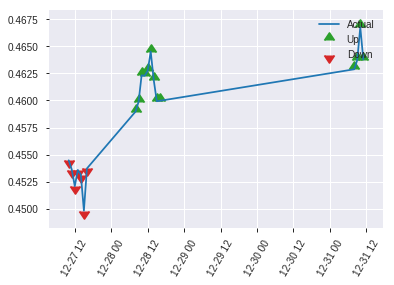


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25707447274394607
RMSE: 0.5070251204269332
LogLoss: 0.7078282815898971
Mean Per-Class Error: 0.4372383252818035
AUC: 0.5476650563607085
pr_auc: 0.5155060638372542
Gini: 0.095330112721417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.333366139460902: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    111  0.9652   (111.0/115.0)
1      1    107  0.0093   (1.0/108.0)
Total  5    218  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333366     0.656442  217
max f2                       0.326987     0.824427  222
max f0point5                 0.360751     0.554813  159
max accuracy                 0.383279     0.565022  92
max precision                0.728305     1         0
max recall                   0.326987     1         222
max specificity              0.728305     1         0
max absolute_mcc             0.382628     0.126858  94
max min_per_class_accuracy   0.375568     0.556522  111
max mean_per_class_accuracy  0.382628     0.562762  94

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 40.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.60092            1.37654   1.37654            0.666667         0.677657  0.666667                    0.677657            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.597347           0         0.825926           0                0.598444  0.4                         0.645972            0               0.0185185                  -100      -17.4074
    3        0.0313901                   0.590166           1.03241   0.884921           0.5              0.596105  0.428571                    0.631724            0.00925926      0.0277778                  3.24074   -11.5079
    4        0.0403587                   0.581258           0         0.688272           0                0.586053  0.333333                    0.621575            0               0.0277778                  -100      -31.1728
    5        0.0538117                   0.56888            2.06481   1.03241            1                0.574875  0.5                         0.6099              0.0277778       0.0555556                  106.481   3.24074
    6        0.103139                    0.516268           1.12626   1.07729            0.545455         0.53006   0.521739                    0.571716            0.0555556       0.111111                   12.6263   7.72947
    7        0.152466                    0.482597           1.12626   1.09314            0.545455         0.496808  0.529412                    0.547481            0.0555556       0.166667                   12.6263   9.31373
    8        0.201794                    0.452262           1.12626   1.10123            0.545455         0.470378  0.533333                    0.528633            0.0555556       0.222222                   12.6263   10.1235
    9        0.300448                    0.38738            1.12626   1.10945            0.545455         0.410582  0.537313                    0.48987             0.111111        0.333333                   12.6263   10.9453
    10       0.399103                    0.383832           1.12626   1.11361            0.545455         0.385589  0.539326                    0.464093            0.111111        0.444444                   12.6263   11.3608
    11       0.502242                    0.375568           1.16707   1.12459            0.565217         0.380265  0.544643                    0.446878            0.12037         0.564815                   16.7069   12.4587
    12       0.600897                    0.368734           0.656987  1.04782            0.318182         0.371329  0.507463                    0.434474            0.0648148       0.62963                    -34.3013  4.78165
    13       0.699552                    0.361898           1.12626   1.05888            0.545455         0.365298  0.512821                    0.424719            0.111111        0.740741                   12.6263   5.88794
    14       0.798206                    0.355246           0.563131  0.997607           0.272727         0.358733  0.483146                    0.416563            0.0555556       0.796296                   -43.6869  -0.239284
    15       0.896861                    0.348882           1.22012   1.02208            0.590909         0.352273  0.495                       0.409491            0.12037         0.916667                   22.0118   2.20833
    16       1                           0.326987           0.807971  1                  0.391304         0.339568  0.484305                    0.402279    

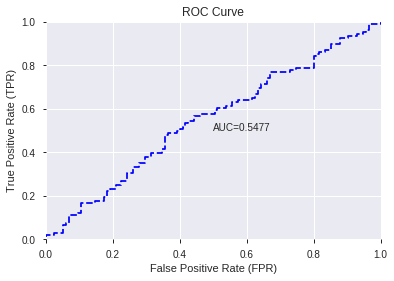

This function is available for GLM models only


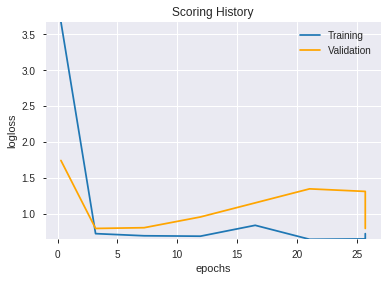

--2019-08-27 20:20:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  40.6MB/s    in 9.1s    

2019-08-27 20:20:43 (38.8 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_195507_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_195507_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_202054_model_9  0.559340  0.693018              0.486957  0.499935  0.249935
1  DeepLearning_grid_1_AutoML_20190827_202054_model_7  0.539211  0.717656              0.440258  0.511746  0.261884
2  DeepLearning_grid_1_AutoML_20190827_202054_model_4  0.509501  0.723310              0.465781  0.513967  0.264162
3  DeepLearning_grid_1_AutoML_20190827_202054_model_8  0.494807  0.694642              0.495652  0.500747  0.250747
4  DeepLearning_grid_1_AutoML_20190827_202054_model_6  0.487641  0.693396              0.495652  0.500124  0.250124
5  DeepLearning_grid_1_AutoML_20190827_202054_model_5  0.485668  0.699153              0.495652  0.502953  0.252962
6  DeepLearning_grid_1_AutoML_20190827_202054_model_1  0.465378  0.883162              0.482890  0.565718  0.320036
7  DeepLearning_grid_1_AutoML_20190827_202054_model_3  0.451369  0.770017              0.491586  0.530753  0.281699
8  DeepLearning_grid_1_AutoML_20190827_202054_model_2  0.450966  0.746255              0.495652  0.521966  0.272449
9               DeepLearning_1_AutoML_20190827_202054  0.450805  0.836588              0.491304  0.553965  0.306878

variable  relative_importance  scaled_importance  percentage
0                     RSI_12             1.000000           1.000000    0.023493
1                AROONOSC_30             0.957895           0.957895    0.022504
2                MACD_signal             0.952313           0.952313    0.022373
3                     ROC_20             0.929275           0.929275    0.021831
4                    ROCP_20             0.913872           0.913872    0.021470
5                  STDDEV_14             0.912659           0.912659    0.021441
6                 PLUS_DM_24             0.908881           0.908881    0.021352
7         LINEARREG_SLOPE_14             0.901710           0.901710    0.021184
8             CDLRICKSHAWMAN             0.896399           0.896399    0.021059
9                      MFI_8             0.873884           0.873884    0.020530
10  BBANDS_middleband_14_7_5             0.872116           0.872116    0.020489
11   BBANDS_lowerband_12_3_5             0.868071           0.868071    0.020394
12              LINEARREG_14             0.866688           0.866688    0.020361
13   BBANDS_middleband_8_0_3             0.863852           0.863852    0.020294
14                    KAMA_8             0.863561           0.863561    0.020288
15   BBANDS_upperband_24_1_2             0.858423           0.858423    0.020167
16                    TEMA_8             0.856097           0.856097    0.020112
17   BBANDS_upperband_30_2_3             0.854392           0.854392    0.020072
18                   MA_30_5             0.852383           0.852383    0.020025
19  BBANDS_middleband_14_5_5             0.847983           0.847983    0.019922
20                    T3_8_7             0.846860           0.846860    0.019895
21   BBANDS_lowerband_14_3_2             0.846771           0.846771    0.019893
22                      Open             0.842736           0.842736    0.019798
23                       TAN             0.842535           0.842535    0.019794
24   BBANDS_lowerband_30_5_5             0.842043           0.842043    0.019782
25                    MA_8_0             0.841957           0.841957    0.019780
26   BBANDS_lowerband_24_0_4             0.840602           0.840602    0.019748
27              CDLTASUKIGAP             0.838769           0.838769    0.019705
28   BBANDS_upperband_14_6_5             0.838417           0.838417    0.019697
29   BBANDS_lowerband_12_0_3             0.835973           0.835973    0.019639
30               MIDPOINT_12             0.835884           0.835884    0.019637
31  BBANDS_middleband_12_7_2             0.832371           0.832371    0.019555
32                 MAVP_20_0             0.831483           0.831483    0.019534
33    BBANDS_lowerband_8_2_5             0.829541           0.829541    0.019488
34                    MAX_12             0.827796           0.827796    0.019447
35  BBANDS_middleband_12_6_3             0.827083           0.827083    0.019431
36   BBANDS_upperband_24_2_4             0.826871           0.826871    0.019426
37   BBANDS_lowerband_20_5_2             0.825500           0.825500    0.019393
38             CDLHANGINGMAN             0.824370           0.824370    0.019367
39   BBANDS_upperband_14_5_5             0.823085           0.823085    0.019337
40                MIDPRICE_8             0.822348           0.822348    0.019319
41  BBANDS_middleband_24_1_4             0.814884           0.814884    0.019144
42                 MAVP_14_0             0.814694           0.814694    0.019140
43   BBANDS_lowerband_20_5_5             0.809605           0.809605    0.019020
44    BBANDS_upperband_8_3_3             0.808788           0.808788    0.019001
45                   MA_24_1             0.790896           0.790896    0.018581
46    LINEARREG_INTERCEPT_14             0.789777           0.789777    0.018554
47   BBANDS_upperband_14_6_4             0.789392           0.789392    0.018545
48   BBANDS_upperband_24_2_2             0.788596  

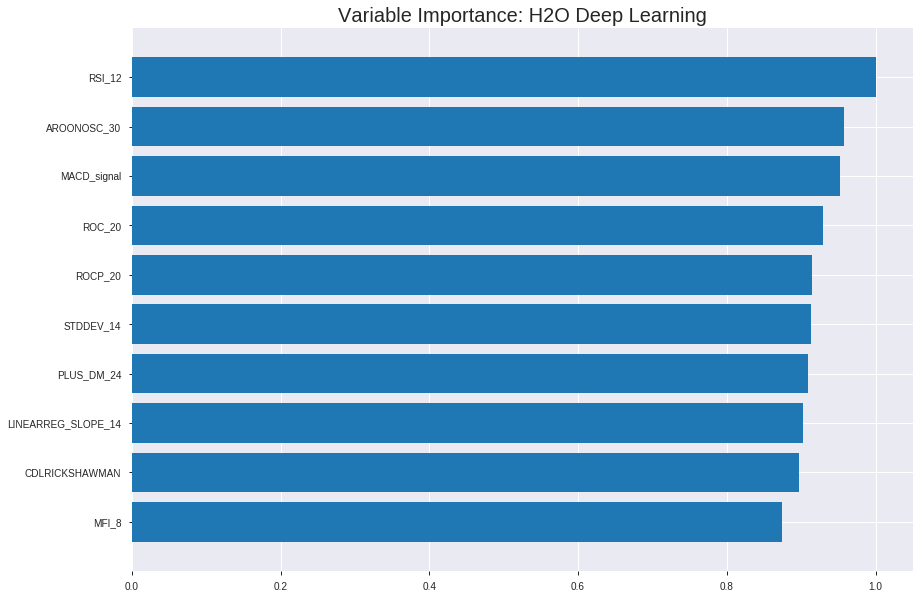

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_202054_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25278404635116425
RMSE: 0.5027763382968258
LogLoss: 0.698724558800478
Mean Per-Class Error: 0.45755524148705184
AUC: 0.5522559974580311
pr_auc: 0.5615315858781854
Gini: 0.10451199491606222
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4546797692228933: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    728   0.9891   (728.0/736.0)
1      3    818   0.0037   (3.0/821.0)
Total  11   1546  0.4695   (731.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.45468      0.69117    391
max f2                       0.454023     0.847965   399
max f0point5                 0.458856     0.588374   326
max accuracy                 0.46312      0.549133   251
max precision                0.474749     1          0
max recall                   0.454023     1          399
max specificity              0.474749     1          0
max absolute_mcc             0.46312      0.0867045  251
max min_per_class_accuracy   0.464177     0.538368   215
max mean_per_class_accuracy  0.464017     0.542445   220

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 46.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102762                   0.4732             1.06676   1.06676            0.5625           0.473679  0.5625                      0.473679            0.0109622       0.0109622                  6.67631    6.67631
    2        0.0205523                   0.472704           1.06676   1.06676            0.5625           0.472936  0.5625                      0.473308            0.0109622       0.0219245                  6.67631    6.67631
    3        0.0301863                   0.472301           1.01145   1.04911            0.533333         0.472468  0.553191                    0.473039            0.00974421      0.0316687                  1.14495    4.91098
    4        0.0404624                   0.472106           0.948234  1.02349            0.5              0.472217  0.539683                    0.472831            0.00974421      0.0414129                  -5.17661   2.34905
    5        0.0500963                   0.471855           1.39074   1.09412            0.733333         0.471988  0.576923                    0.472669            0.0133983       0.0548112                  39.0743    9.4116
    6        0.100193                    0.470945           1.11843   1.10627            0.589744         0.471355  0.583333                    0.472012            0.0560292       0.11084                    11.843     10.6273
    7        0.150289                    0.470243           0.996861  1.0698             0.525641         0.470616  0.564103                    0.471547            0.0499391       0.16078                    -0.313876  6.98023
    8        0.200385                    0.4695             1.21568   1.10627            0.641026         0.469829  0.583333                    0.471117            0.0609013       0.221681                   21.5684    10.6273
    9        0.299936                    0.467399           1.08894   1.10052            0.574194         0.468459  0.5803                      0.470235            0.108404        0.330085                   8.89395    10.052
    10       0.400128                    0.465342           1.04549   1.08674            0.551282         0.466344  0.573034                    0.469261            0.10475         0.434836                   4.54886    8.67399
    11       0.500321                    0.46417            1.03333   1.07604            0.544872         0.464676  0.567394                    0.468342            0.103532        0.538368                   3.33318    7.60446
    12       0.599872                    0.463364           0.917646  1.04976            0.483871         0.463715  0.553533                    0.467575            0.091352        0.62972                    -8.23543   4.97578
    13       0.791265                    0.462743           0.986418  1.03444            0.520134         0.462869  0.545455                    0.466436            0.188794        0.818514                   -1.35822   3.44369
    14       0.799615                    0.462394           0.145882  1.02516            0.0769231        0.462541  0.540562                    0.466396            0.00121803      0.819732                   -85.4118   2.51589
    15       0.899807                    0.45846            0.972548  1.0193             0.512821         0.460355  0.537473                    0.465723            0.0974421       0.917174                   -2.74525   1.93006
    16       1                           0.454023           0.826665  1                  0.435897         0.456583  0.527296                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24970195671916506
RMSE: 0.4997018678363781
LogLoss: 0.6925506202976026
Mean Per-Class Error: 0.4631933487073674
AUC: 0.5247097139620505
pr_auc: 0.4891311965779146
Gini: 0.04941942792410092
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45589097734267653: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    224  0.9697   (224.0/231.0)
1      1    213  0.0047   (1.0/214.0)
Total  8    437  0.5056   (225.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455891     0.654378  391
max f2                       0.455891     0.823666  391
max f0point5                 0.457857     0.547645  357
max accuracy                 0.468082     0.546067  107
max precision                0.46943      0.573529  66
max recall                   0.453711     1         398
max specificity              0.472265     0.995671  0
max absolute_mcc             0.471442     0.106335  8
max min_per_class_accuracy   0.464787     0.504673  218
max mean_per_class_accuracy  0.467979     0.536807  111

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 46.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.471657           0.415888  0.415888           0.2              0.471998  0.2                         0.471998            0.0046729       0.0046729                  -58.4112  -58.4112
    2        0.0202247                   0.471402           0         0.231049           0                0.471524  0.111111                    0.471787            0               0.0046729                  -100      -76.8951
    3        0.0314607                   0.471232           1.66355   0.742657           0.8              0.471313  0.357143                    0.471618            0.0186916       0.0233645                  66.3551   -25.7343
    4        0.0404494                   0.471088           0.51986   0.693146           0.25             0.471157  0.333333                    0.471515            0.0046729       0.0280374                  -48.014   -30.6854
    5        0.0516854                   0.470991           0.831776  0.723283           0.4              0.471038  0.347826                    0.471412            0.00934579      0.0373832                  -16.8224  -27.6717
    6        0.101124                    0.47037            1.60684   1.15524            0.772727         0.470669  0.555556                    0.471048            0.0794393       0.116822                   60.6839   15.5244
    7        0.150562                    0.469434           1.22876   1.17938            0.590909         0.469951  0.567164                    0.470688            0.0607477       0.17757                    22.876    17.9383
    8        0.2                         0.468648           0.85068   1.09813            0.409091         0.469096  0.52809                     0.470295            0.0420561       0.219626                   -14.932   9.81308
    9        0.301124                    0.467433           1.01661   1.07076            0.488889         0.468007  0.514925                    0.469526            0.102804        0.32243                    1.66147   7.0756
    10       0.4                         0.466172           0.80342   1.00467            0.386364         0.466832  0.483146                    0.46886             0.0794393       0.401869                   -19.658   0.46729
    11       0.501124                    0.464758           1.01661   1.00708            0.488889         0.465461  0.484305                    0.468174            0.102804        0.504673                   1.66147   0.708269
    12       0.678652                    0.462743           1.0792    1.02595            0.518987         0.463273  0.493377                    0.466892            0.191589        0.696262                   7.92026   2.59485
    13       0.698876                    0.462554           1.15524   1.02969            0.555556         0.462623  0.495177                    0.466769            0.0233645       0.719626                   15.5244   2.96902
    14       0.8                         0.460589           1.01661   1.02804            0.488889         0.461477  0.494382                    0.4661              0.102804        0.82243                    1.66147   2.80374
    15       0.898876                    0.458045           1.03972   1.02932            0.5              0.459609  0.495                       0.465386            0.102804        0.925234                   3.97196   2.93224
    16       1                           0.453698           0.739356  1                  0.355556         0.456511  0.480899                    0.464488    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:27:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:27:40  2 min  2.531 sec  496 obs/sec       0.60501   1             942        0.585752         1.00143             -0.376524      0.488307        0.50775            0.592646         0.472704                         0.520661           0.741062              -0.0859371       0.502721          0.47135              1.66355            0.507865
    2019-08-27 20:27:49  2 min 11.621 sec  836 obs/sec       5.43545   9             8463       0.499569         0.692285            -0.00125983    0.496988        0.521756           1.06676          0.472062                         0.500596           0.69434               -0.0038498       0.521048          0.482546             0.831776           0.516854
    2019-08-27 20:27:57  2 min 20.352 sec  996 obs/sec       11.4958   19            17899      0.502776         0.698725            -0.0141587     0.552256        0.561532           1.06676          0.469493                         0.499702           0.692551              -0.000267629     0.52471           0.489131             0.415888           0.505618
    2019-08-27 20:28:06  2 min 29.256 sec  1164 obs/sec      19.4438   32            30274      0.498755         0.690658            0.00199875     0.552196        0.286438           1.09444          0.472704                         0.501887           0.696936              -0.00903421      0.529251          0.299237             1.07823            0.514607
    2019-08-27 20:28:15  2 min 38.028 sec  1258 obs/sec      27.3963   45            42656      0.499582         0.692311            -0.00131093    0.533296        0.128192           1.03957          0.465639                         0.500027           0.693202              -0.00157123      0.518894          0.146846             1.01933            0.503371
    2019-08-27 20:28:24  2 min 46.975 sec  1378 obs/sec      37.1708   61            57875      0.505299         0.703846            -0.0243612     0.516667        0.524649           0.948234         0.461785                         0.500504           0.694164              -0.00348031      0.512056          0.455006             0.831776           0.507865
    2019-08-27 20:28:25  2 min 47.884 sec  1376 obs/sec      37.1708   61            57875      0.502776         0.698725            -0.0141587     0.552256        0.561532           1.06676          0.469493                         0.499702           0.692551              -0.000267629     0.52471           0.489131             0.415888           0.505618

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
RSI_12                   1.0                    1.0                  0.023492980548261388
AROONOSC_30              0.9578946232795715     0.9578946232795715   0.022503799751991144
MACD_signal              0.9523134231567383     0.9523134231567383   0.022372680726069467
ROC_20                   0.9292749166488647     0.9292749166488647   0.021831437540819
ROCP_20                  0.9138719439506531     0.9138719439506531   0.021469575802834512
---                      ---                    ---                  ---
MA_24_1                  0.790896475315094      0.790896475315094    0.018580515510265995
LINEARREG_INTERCEPT_14   0.7897771000862122     0.7897771000862122   0.018554218049787668
BBANDS_upperband_14_6_4  0.7893924713134766     0.7893924713134766   0.01854518197351149
BBANDS_upperband_24_2_2  0.788595974445343      0.788595974445343    0.018526469888081678
CDLBELTHOLD              0.7858269214630127     0.7858269214630127   0.018461416580230684


See the whole table with table.as_data_frame()


('accuracy', 0.5695067264573991)

('F1', 0.6585365853658536)

('auc', 0.5593397745571659)

('logloss', 0.6930181230951074)

('mean_per_class_error', 0.4323268921095007)

('rmse', 0.4999351590779278)

('mse', 0.24993516328227294)

deeplearning prediction progress: |███████████████████████████████████████| 100%


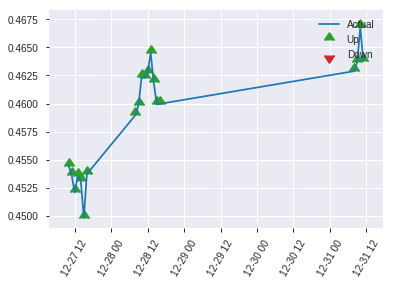


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24993516328227294
RMSE: 0.4999351590779278
LogLoss: 0.6930181230951074
Mean Per-Class Error: 0.4323268921095007
AUC: 0.5593397745571659
pr_auc: 0.5270812531785642
Gini: 0.11867954911433176
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.462485752104288: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    112  0.9739   (112.0/115.0)
1      0    108  0        (0.0/108.0)
Total  3    220  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462486     0.658537  104
max f2                       0.462486     0.828221  104
max f0point5                 0.462872     0.55      97
max accuracy                 0.463382     0.569507  79
max precision                0.472215     1         0
max recall                   0.462486     1         104
max specificity              0.472215     1         0
max absolute_mcc             0.462872     0.136282  97
max min_per_class_accuracy   0.462872     0.509259  97
max mean_per_class_accuracy  0.462872     0.567673  97

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 46.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.472038           0.688272  0.688272           0.333333         0.472136  0.333333                    0.472136            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.471505           1.03241   0.825926           0.5              0.471966  0.4                         0.472068            0.00925926      0.0185185                  3.24074   -17.4074
    3        0.0313901                   0.470414           2.06481   1.17989            1                0.470955  0.571429                    0.47175             0.0185185       0.037037                   106.481   17.9894
    4        0.0403587                   0.469915           1.03241   1.14712            0.5              0.470074  0.555556                    0.471378            0.00925926      0.0462963                  3.24074   14.7119
    5        0.0538117                   0.469727           1.37654   1.20448            0.666667         0.469817  0.583333                    0.470988            0.0185185       0.0648148                  37.6543   20.4475
    6        0.103139                    0.468298           0.938552  1.07729            0.454545         0.468961  0.521739                    0.470018            0.0462963       0.111111                   -6.14478  7.72947
    7        0.152466                    0.467148           1.50168   1.2146             0.727273         0.467705  0.588235                    0.46927             0.0740741       0.185185                   50.1684   21.4597
    8        0.201794                    0.465481           1.31397   1.23889            0.636364         0.466394  0.6                         0.468567            0.0648148       0.25                       31.3973   23.8889
    9        0.300448                    0.463834           1.12626   1.20191            0.545455         0.464372  0.58209                     0.467189            0.111111        0.361111                   12.6263   20.1907
    10       0.399103                    0.463022           0.938552  1.13681            0.454545         0.463453  0.550562                    0.466266            0.0925926       0.453704                   -6.14478  13.6808
    11       0.973094                    0.462743           0.903356  0.999104           0.4375           0.462757  0.483871                    0.464196            0.518519        0.972222                   -9.66435  -0.0896057
    12       1                           0.462322           1.03241   1                  0.5              0.462501  0.484305                    0.46415             0.0277778       1                          3.24074   0

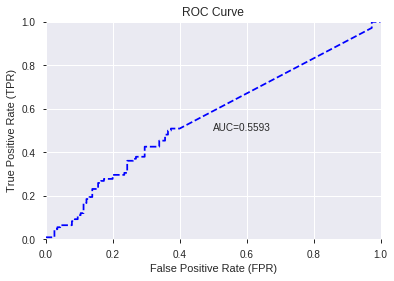

This function is available for GLM models only


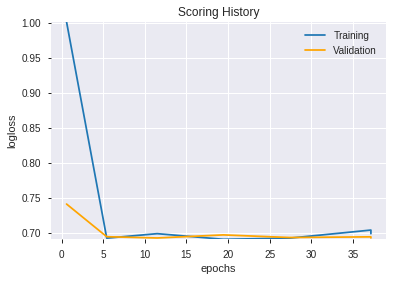

--2019-08-27 20:28:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_202054_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_202054_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['RSI_12',
 'AROONOSC_30',
 'MACD_signal',
 'ROC_20',
 'ROCP_20',
 'STDDEV_14',
 'PLUS_DM_24',
 'LINEARREG_SLOPE_14',
 'CDLRICKSHAWMAN',
 'MFI_8',
 'BBANDS_middleband_14_7_5',
 'BBANDS_lowerband_12_3_5',
 'LINEARREG_14',
 'BBANDS_middleband_8_0_3',
 'KAMA_8',
 'BBANDS_upperband_24_1_2',
 'TEMA_8',
 'BBANDS_upperband_30_2_3',
 'MA_30_5',
 'BBANDS_middleband_14_5_5',
 'T3_8_7',
 'BBANDS_lowerband_14_3_2',
 'Open',
 'TAN',
 'BBANDS_lowerband_30_5_5',
 'MA_8_0',
 'BBANDS_lowerband_24_0_4',
 'CDLTASUKIGAP',
 'BBANDS_upperband_14_6_5',
 'BBANDS_lowerband_12_0_3',
 'MIDPOINT_12',
 'BBANDS_middleband_12_7_2',
 'MAVP_20_0',
 'BBANDS_lowerband_8_2_5',
 'MAX_12',
 'BBANDS_middleband_12_6_3',
 'BBANDS_upperband_24_2_4',
 'BBANDS_lowerband_20_5_2',
 'CDLHANGINGMAN',
 'BBANDS_upperband_14_5_5',
 'MIDPRICE_8',
 'BBANDS_middleband_24_1_4',
 'MAVP_14_0',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_upperband_8_3_3',
 'MA_24_1',
 'LINEARREG_INTERCEPT_14',
 'BBANDS_upperband_14_6_4',
 'BBANDS_upperband_24_2_2',


In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_202840_model_1  0.542754  0.691935              0.486957  0.499395  0.249395

variable  relative_importance  scaled_importance  percentage
0             CDLRICKSHAWMAN             0.035679           1.000000    0.106173
1                MACD_signal             0.029317           0.821677    0.087240
2                     RSI_12             0.026777           0.750485    0.079681
3              CDLHANGINGMAN             0.022335           0.625989    0.066463
4                AROONOSC_30             0.020618           0.577874    0.061355
5               CDLTASUKIGAP             0.020277           0.568316    0.060340
6                 PLUS_DM_24             0.019794           0.554786    0.058903
7         LINEARREG_SLOPE_14             0.018811           0.527226    0.055977
8                  STDDEV_14             0.018018           0.505000    0.053618
9                CDLBELTHOLD             0.015656           0.438785    0.046587
10                     MFI_8             0.008339           0.233716    0.024814
11   BBANDS_upperband_24_2_4             0.007646           0.214284    0.022751
12   BBANDS_lowerband_24_0_4             0.006046           0.169449    0.017991
13                    ROC_20             0.005679           0.159171    0.016900
14                   ROCP_20             0.005642           0.158144    0.016791
15   BBANDS_upperband_24_1_2             0.005455           0.152900    0.016234
16   BBANDS_upperband_30_2_3             0.005393           0.151145    0.016048
17   BBANDS_lowerband_30_5_5             0.005127           0.143707    0.015258
18                      Open             0.004763           0.133483    0.014172
19   BBANDS_upperband_24_2_2             0.004386           0.122917    0.013050
20   BBANDS_lowerband_12_3_5             0.004129           0.115733    0.012288
21   BBANDS_upperband_14_5_5             0.004031           0.112979    0.011995
22   BBANDS_lowerband_20_5_5             0.004008           0.112322    0.011926
23   BBANDS_upperband_14_6_5             0.004004           0.112209    0.011914
24   BBANDS_upperband_14_6_4             0.003326           0.093227    0.009898
25   BBANDS_lowerband_14_3_2             0.002895           0.081136    0.008614
26    LINEARREG_INTERCEPT_14             0.002649           0.074255    0.007884
27                   MA_30_5             0.002321           0.065038    0.006905
28                 MAVP_14_0             0.002154           0.060369    0.006410
29  BBANDS_middleband_24_1_4             0.002072           0.058071    0.006166
30                 MAVP_20_0             0.002039           0.057159    0.006069
31                   MA_24_1             0.001996           0.055953    0.005941
32                    KAMA_8             0.001667           0.046728    0.004961
33    BBANDS_upperband_8_3_3             0.001545           0.043315    0.004599
34   BBANDS_lowerband_12_0_3             0.001502           0.042101    0.004470
35              LINEARREG_14             0.001499           0.042005    0.004460
36                    TEMA_8             0.001441           0.040391    0.004288
37               MIDPOINT_12             0.001023           0.028678    0.003045
38                    MAX_12             0.000861           0.024142    0.002563
39  BBANDS_middleband_12_7_2             0.000818           0.022922    0.002434
40  BBANDS_middleband_14_7_5             0.000667           0.018704    0.001986
41  BBANDS_middleband_14_5_5             0.000598           0.016756    0.001779
42   BBANDS_lowerband_20_5_2             0.000583           0.016352    0.001736
43  BBANDS_middleband_12_6_3             0.000564           0.015801    0.001678
44    BBANDS_lowerband_8_2_5             0.000466           0.013074    0.001388
45                       TAN             0.000315           0.008823    0.000937
46                    MA_8_0             0.000308           0.008637    0.000917
47   BBANDS_middleband_8_0_3             0.000308           0.008624    0.000916
48                    T3_8_7             0.000280  

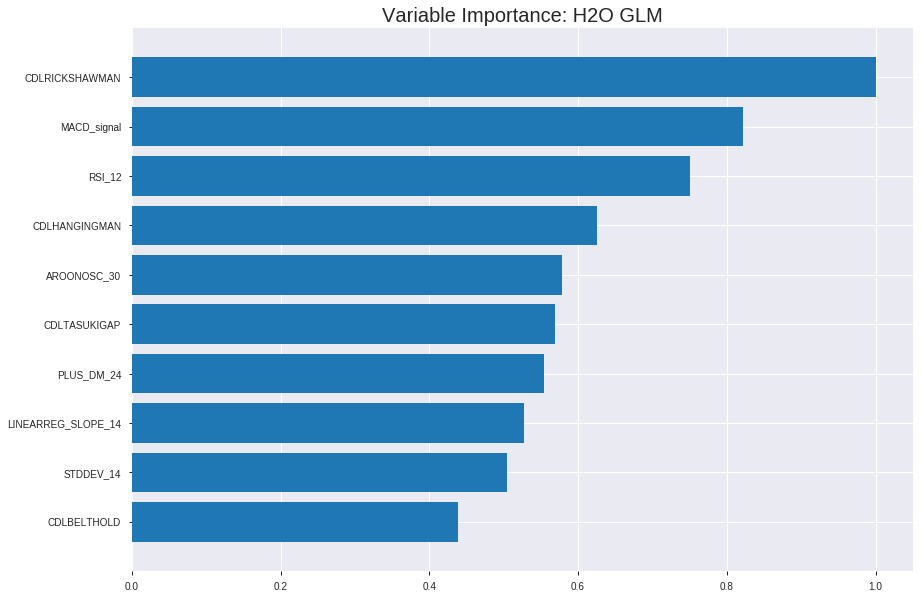

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_202840_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2472656657329169
RMSE: 0.4972581479804196
LogLoss: 0.6876463009702415
Null degrees of freedom: 1556
Residual degrees of freedom: 1506
Null deviance: 2153.817678601273
Residual deviance: 2141.330581221332
AIC: 2243.330581221332
AUC: 0.5553283707567653
pr_auc: 0.5707618862923597
Gini: 0.11065674151353067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4265359552218894: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    735   0.9986   (735.0/736.0)
1      0    821   0        (0.0/821.0)
Total  1    1556  0.4721   (735.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.426536     0.690787   398
max f2                       0.426536     0.84814    398
max f0point5                 0.482155     0.589516   325
max accuracy                 0.52632      0.548491   198
max precision                0.738533     1          0
max recall                   0.426536     1          398
max specificity              0.738533     1          0
max absolute_mcc             0.555477     0.0954372  85
max min_per_class_accuracy   0.532217     0.533967   178
max mean_per_class_accuracy  0.52632      0.545066   198

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102762                   0.5879             0.948234  0.948234           0.5              0.604489  0.5                         0.604489            0.00974421      0.00974421                 -5.17661   -5.17661
    2        0.0205523                   0.581371           1.18529   1.06676            0.625            0.583733  0.5625                      0.594111            0.0121803       0.0219245                  18.5292    6.67631
    3        0.0301863                   0.577239           1.26431   1.12981            0.666667         0.57954   0.595745                    0.589461            0.0121803       0.0341048                  26.4312    12.9811
    4        0.0404624                   0.57322            1.42235   1.20411            0.75             0.574531  0.634921                    0.585669            0.0146163       0.0487211                  42.2351    20.4106
    5        0.0500963                   0.569926           1.13788   1.19137            0.6              0.571231  0.628205                    0.582892            0.0109622       0.0596833                  13.7881    19.1371
    6        0.100193                    0.561706           1.14274   1.16706            0.602564         0.565779  0.615385                    0.574336            0.0572473       0.116931                   14.2743    16.7057
    7        0.150289                    0.557513           1.04549   1.12653            0.551282         0.559429  0.594017                    0.569367            0.0523752       0.169306                   4.54886    12.6534
    8        0.200385                    0.553778           1.16706   1.13666            0.615385         0.555618  0.599359                    0.56593             0.0584653       0.227771                   16.7057    13.6665
    9        0.299936                    0.546681           1.06447   1.1127             0.56129          0.550341  0.586724                    0.560755            0.105968        0.333739                   6.4469     11.2703
    10       0.400128                    0.540065           0.984704  1.08065            0.519231         0.543417  0.569823                    0.556414            0.0986602       0.4324                     -1.52956   8.06518
    11       0.500321                    0.532316           0.996861  1.06387            0.525641         0.536189  0.560976                    0.552364            0.0998782       0.532278                   -0.313876  6.38721
    12       0.599872                    0.523267           1.05223   1.06194            0.554839         0.527736  0.559957                    0.548277            0.10475         0.637028                   5.22337    6.19407
    13       0.700064                    0.514585           0.899606  1.03871            0.474359         0.518811  0.547706                    0.544059            0.090134        0.727162                   -10.0394   3.87076
    14       0.799615                    0.501145           0.978822  1.03125            0.516129         0.508319  0.543775                    0.53961             0.0974421       0.824604                   -2.11779   3.12519
    15       0.899807                    0.482074           0.984704  1.02607            0.519231         0.492421  0.541042                    0.534355            0.0986602       0.923264                   -1.52956   2.60689
    16       1                           0.41959            0.765881  1                  0.403846         0.463898  0.527296                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2502573143390804
RMSE: 0.5002572481624633
LogLoss: 0.6936503507139846
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 620.0871872338774
Residual deviance: 617.3488121354463
AIC: 719.3488121354463
AUC: 0.5270967350406603
pr_auc: 0.5024043001737207
Gini: 0.054193470081320694
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44707198847391505: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    227  0.9827   (227.0/231.0)
1      0    214  0        (0.0/214.0)
Total  4    441  0.5101   (227.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.447072     0.653435   395
max f2                       0.447072     0.824981   395
max f0point5                 0.501634     0.544489   288
max accuracy                 0.550021     0.541573   61
max precision                0.566942     0.666667   11
max recall                   0.447072     1          395
max specificity              0.588829     0.995671   0
max absolute_mcc             0.447072     0.0916667  395
max min_per_class_accuracy   0.525742     0.514019   193
max mean_per_class_accuracy  0.501634     0.539022   288

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 51.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.576885           0.831776  0.831776           0.4              0.583836  0.4                         0.583836            0.00934579      0.00934579                 -16.8224   -16.8224
    2        0.0202247                   0.570751           1.55958   1.15524            0.75             0.573362  0.555556                    0.579181            0.0140187       0.0233645                  55.9579    15.5244
    3        0.0314607                   0.562142           1.24766   1.18825            0.6              0.56701   0.571429                    0.574834            0.0140187       0.0373832                  24.7664    18.8251
    4        0.0404494                   0.560605           1.55958   1.27077            0.75             0.561426  0.611111                    0.571855            0.0140187       0.0514019                  55.9579    27.0768
    5        0.0516854                   0.558598           0.831776  1.17534            0.4              0.559586  0.565217                    0.569188            0.00934579      0.0607477                  -16.8224   17.5335
    6        0.101124                    0.553952           0.85068   1.01661            0.409091         0.555696  0.488889                    0.562592            0.0420561       0.102804                   -14.932    1.66147
    7        0.150562                    0.549916           1.51232   1.17938            0.727273         0.552031  0.567164                    0.559124            0.0747664       0.17757                    51.2319    17.9383
    8        0.2                         0.546986           0.85068   1.09813            0.409091         0.548528  0.52809                     0.556505            0.0420561       0.219626                   -14.932    9.81308
    9        0.301124                    0.542497           0.970405  1.05524            0.466667         0.54466   0.507463                    0.552527            0.0981308       0.317757                   -2.9595    5.52378
    10       0.4                         0.534826           0.99246   1.03972            0.477273         0.538341  0.5                         0.54902             0.0981308       0.415888                   -0.754036  3.97196
    11       0.501124                    0.525643           0.970405  1.02573            0.466667         0.530222  0.493274                    0.545227            0.0981308       0.514019                   -2.9595    2.57324
    12       0.6                         0.513023           1.13424   1.04361            0.545455         0.52048   0.501873                    0.541149            0.11215         0.626168                   13.424     4.36137
    13       0.698876                    0.504403           0.9452    1.02969            0.454545         0.508986  0.495177                    0.536599            0.0934579       0.719626                   -5.48003   2.96902
    14       0.8                         0.492166           0.877985  1.01051            0.422222         0.498329  0.485955                    0.531761            0.088785        0.808411                   -12.2015   1.0514
    15       0.898876                    0.473628           1.03972   1.01373            0.5              0.483911  0.4875                      0.526498            0.102804        0.911215                   3.97196    1.37266
    16       1                           0.348498           0.877985  1                  0.422222         0.456256  0.480899                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:28:40  0.000 sec   2            3.5       51            1.38026           1.39076
    2019-08-27 20:28:40  0.074 sec   4            2.2       51            1.37927           1.3899
    2019-08-27 20:28:40  0.115 sec   6            1.4       51            1.37822           1.38903
    2019-08-27 20:28:41  0.153 sec   8            0.85      51            1.37718           1.38823
    2019-08-27 20:28:41  0.182 sec   10           0.53      51            1.37619           1.38762
    2019-08-27 20:28:41  0.204 sec   12           0.33      51            1.37529           1.3873
    2019-08-27 20:28:41  0.236 sec   14           0.2       51            1.37449           1.38736
    2019-08-27 20:28:41  0.266 sec   16           0.13      51            1.37378           1.38786
    2019-08-27 20:28:41  0.285 sec   17           0.078     51            1.37317           1.38882
    2019-08-27 20:28:41  0.305 sec   18           0.049     51            1.37265           1.39011
    2019-08-27 20:28:41  0.324 sec   19           0.03      51            1.3722            1.3916

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6585365853658536)

('auc', 0.5427536231884058)

('logloss', 0.6919354514279229)

('mean_per_class_error', 0.4423107890499195)

('rmse', 0.49939473524212313)

('mse', 0.24939510158755024)

glm prediction progress: |████████████████████████████████████████████████| 100%


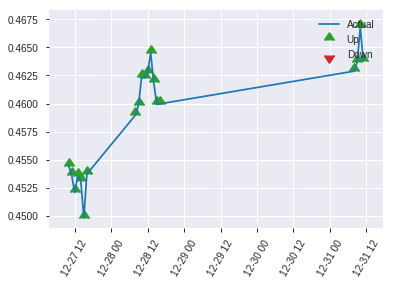


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24939510158755024
RMSE: 0.49939473524212313
LogLoss: 0.6919354514279229
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 310.57429368859675
Residual deviance: 308.60321133685363
AIC: 410.60321133685363
AUC: 0.5427536231884058
pr_auc: 0.5166361349732345
Gini: 0.08550724637681162
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4414353927748351: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    112  0.9739   (112.0/115.0)
1      0    108  0        (0.0/108.0)
Total  3    220  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441435     0.658537  219
max f2                       0.441435     0.828221  219
max f0point5                 0.466775     0.548643  193
max accuracy                 0.541842     0.565022  58
max precision                0.579093     0.666667  5
max recall                   0.441435     1         219
max specificity              0.592084     0.991304  0
max absolute_mcc             0.541842     0.130719  58
max min_per_class_accuracy   0.518434     0.530435  111
max mean_per_class_accuracy  0.541842     0.557689  58

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 51.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.585398           0.688272  0.688272           0.333333         0.588659  0.333333                    0.588659            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.579507           2.06481   1.23889            1                0.581005  0.6                         0.585598            0.0185185       0.0277778                  106.481   23.8889
    3        0.0313901                   0.57676            1.03241   1.17989            0.5              0.578765  0.571429                    0.583645            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.574971           1.03241   1.14712            0.5              0.575652  0.555556                    0.581869            0.00925926      0.0462963                  3.24074   14.7119
    5        0.0538117                   0.570159           0.688272  1.03241            0.333333         0.572466  0.5                         0.579518            0.00925926      0.0555556                  -31.1728  3.24074
    6        0.103139                    0.559929           1.31397   1.16707            0.636364         0.563375  0.565217                    0.571797            0.0648148       0.12037                    31.3973   16.7069
    7        0.152466                    0.552409           0.750842  1.03241            0.363636         0.556044  0.5                         0.566701            0.037037        0.157407                   -24.9158  3.24074
    8        0.201794                    0.547321           1.31397   1.10123            0.636364         0.549382  0.533333                    0.562467            0.0648148       0.222222                   31.3973   10.1235
    9        0.300448                    0.539947           1.31397   1.17109            0.636364         0.54293   0.567164                    0.556052            0.12963         0.351852                   31.3973   17.1089
    10       0.399103                    0.530077           0.938552  1.11361            0.454545         0.534697  0.539326                    0.550773            0.0925926       0.444444                   -6.14478  11.3608
    11       0.502242                    0.518434           0.897746  1.06928            0.434783         0.524844  0.517857                    0.545448            0.0925926       0.537037                   -10.2254  6.92791
    12       0.600897                    0.509226           0.750842  1.017              0.363636         0.512745  0.492537                    0.540079            0.0740741       0.611111                   -24.9158  1.69983
    13       0.699552                    0.500595           1.12626   1.03241            0.545455         0.504571  0.5                         0.535072            0.111111        0.722222                   12.6263   3.24074
    14       0.798206                    0.479625           0.844697  1.00921            0.409091         0.49021   0.488764                    0.529527            0.0833333       0.805556                   -15.5303  0.920724
    15       0.896861                    0.460896           1.12626   1.02208            0.545455         0.470947  0.495                       0.523083            0.111111        0.916667                   12.6263   2.20833
    16       1                           0.424872           0.807971  1                  0.391304         0.451072  0.484305                    0.515656       

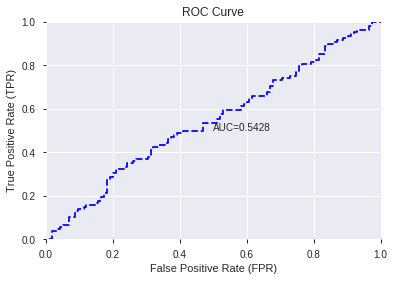

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


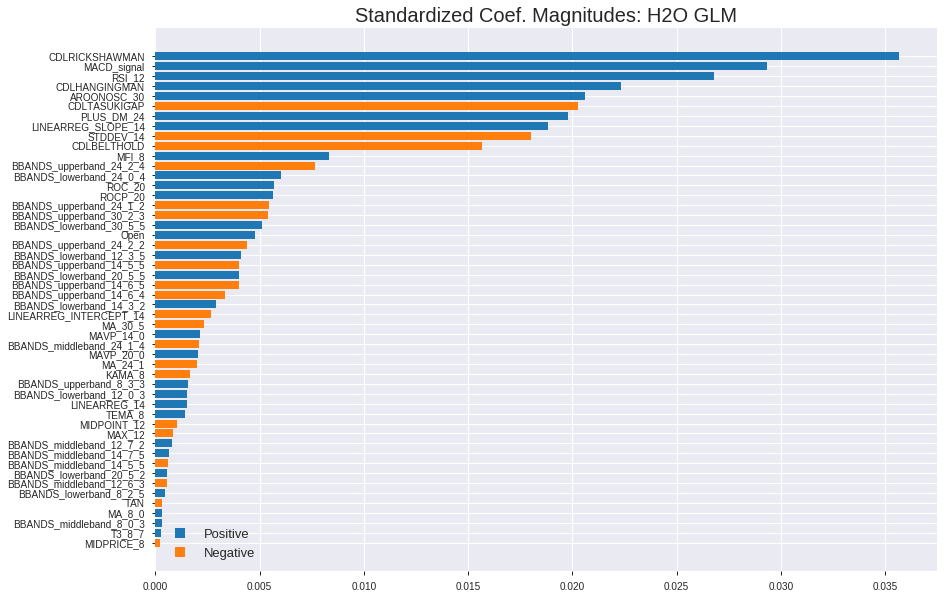

'log_likelihood'
--2019-08-27 20:28:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.116
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.116|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_202840_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_202840_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLRICKSHAWMAN',
 'MACD_signal',
 'RSI_12',
 'CDLHANGINGMAN',
 'AROONOSC_30',
 'CDLTASUKIGAP',
 'PLUS_DM_24',
 'LINEARREG_SLOPE_14',
 'STDDEV_14',
 'CDLBELTHOLD',
 'MFI_8',
 'BBANDS_upperband_24_2_4',
 'BBANDS_lowerband_24_0_4',
 'ROC_20',
 'ROCP_20',
 'BBANDS_upperband_24_1_2',
 'BBANDS_upperband_30_2_3',
 'BBANDS_lowerband_30_5_5',
 'Open',
 'BBANDS_upperband_24_2_2',
 'BBANDS_lowerband_12_3_5',
 'BBANDS_upperband_14_5_5',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_upperband_14_6_5',
 'BBANDS_upperband_14_6_4',
 'BBANDS_lowerband_14_3_2',
 'LINEARREG_INTERCEPT_14',
 'MA_30_5',
 'MAVP_14_0',
 'BBANDS_middleband_24_1_4',
 'MAVP_20_0',
 'MA_24_1',
 'KAMA_8',
 'BBANDS_upperband_8_3_3',
 'BBANDS_lowerband_12_0_3',
 'LINEARREG_14',
 'TEMA_8',
 'MIDPOINT_12',
 'MAX_12',
 'BBANDS_middleband_12_7_2',
 'BBANDS_middleband_14_7_5',
 'BBANDS_middleband_14_5_5',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_8_2_5',
 'TAN',
 'MA_8_0',
 'BBANDS_middleband_8_0_3',
 'T3_8_7',

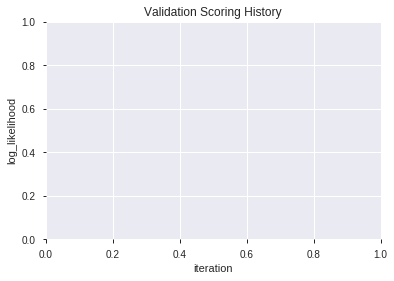

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_202853  0.506280  0.712747              0.450081  0.509124  0.259207
1  XGBoost_grid_1_AutoML_20190827_202853_model_4  0.500523  0.701151              0.479106  0.503890  0.253905
2  XGBoost_grid_1_AutoML_20190827_202853_model_3  0.492271  0.709712              0.474477  0.507955  0.258018
3  XGBoost_grid_1_AutoML_20190827_202853_model_2  0.488768  0.706528              0.478261  0.506368  0.256408
4               XGBoost_2_AutoML_20190827_202853  0.463164  0.729490              0.469847  0.517207  0.267503
5  XGBoost_grid_1_AutoML_20190827_202853_model_6  0.463043  0.721778              0.495652  0.513559  0.263743
6               XGBoost_1_AutoML_20190827_202853  0.462158  0.737700              0.483454  0.520212  0.270621
7  XGBoost_grid_1_AutoML_20190827_202853_model_5  0.460789  0.765413              0.495652  0.530886  0.281840
8  XGBoost_grid_1_AutoML_20190827_202853_model_1  0.451369  0.718006              0.474758  0.511908  0.262050
9  XGBoost_grid_1_AutoML_20190827_202853_model_7  0.426570  0.740543              0.469847  0.521840  0.272317

variable  relative_importance  scaled_importance  percentage
0                      MFI_8           368.189941           1.000000    0.109308
1                 PLUS_DM_24           231.621353           0.629081    0.068764
2                     RSI_12           226.763962           0.615889    0.067322
3                  STDDEV_14           198.007690           0.537787    0.058784
4         LINEARREG_SLOPE_14           186.016434           0.505219    0.055224
5                MACD_signal           167.076675           0.453778    0.049602
6                     ROC_20           153.645111           0.417299    0.045614
7    BBANDS_upperband_14_5_5           106.457130           0.289136    0.031605
8     LINEARREG_INTERCEPT_14           103.053894           0.279893    0.030595
9    BBANDS_upperband_24_2_4           101.413254           0.275437    0.030108
10   BBANDS_lowerband_20_5_5            96.572128           0.262289    0.028670
11   BBANDS_lowerband_20_5_2            94.951965           0.257889    0.028189
12   BBANDS_lowerband_30_5_5            85.189224           0.231373    0.025291
13   BBANDS_lowerband_12_3_5            85.008820           0.230883    0.025237
14                      Open            82.396622           0.223788    0.024462
15   BBANDS_upperband_30_2_3            76.397560           0.207495    0.022681
16                       TAN            69.672585           0.189230    0.020684
17               AROONOSC_30            67.353683           0.182932    0.019996
18                    KAMA_8            58.285461           0.158303    0.017304
19   BBANDS_upperband_14_6_5            57.726360           0.156784    0.017138
20    BBANDS_upperband_8_3_3            56.810566           0.154297    0.016866
21   BBANDS_lowerband_24_0_4            51.113480           0.138824    0.015175
22    BBANDS_lowerband_8_2_5            47.974743           0.130299    0.014243
23                MIDPRICE_8            46.803555           0.127118    0.013895
24                 MAVP_14_0            44.008137           0.119526    0.013065
25   BBANDS_lowerband_14_3_2            43.224499           0.117397    0.012832
26   BBANDS_upperband_14_6_4            41.776348           0.113464    0.012403
27   BBANDS_lowerband_12_0_3            41.437817           0.112545    0.012302
28                   MA_30_5            41.105618           0.111642    0.012203
29   BBANDS_upperband_24_2_2            40.678501           0.110482    0.012077
30                   MA_24_1            36.431576           0.098948    0.010816
31                   ROCP_20            36.182888           0.098272    0.010742
32  BBANDS_middleband_14_5_5            34.177780           0.092826    0.010147
33   BBANDS_upperband_24_1_2            29.974215           0.081410    0.008899
34  BBANDS_middleband_12_6_3            29.361776           0.079746    0.008717
35                    TEMA_8            23.944788           0.065034    0.007109
36                    MAX_12            23.236843           0.063111    0.006899
37              LINEARREG_14            19.624582           0.053300    0.005826
38                    T3_8_7            17.721519           0.048131    0.005261
39               MIDPOINT_12            15.768541           0.042827    0.004681
40            CDLRICKSHAWMAN             9.951530           0.027028    0.002954
41                 MAVP_20_0             8.264655           0.022447    0.002454
42                    MA_8_0             7.935080           0.021552    0.002356
43               CDLBELTHOLD             2.656998           0.007216    0.000789
44   BBANDS_middleband_8_0_3             1.428488           0.003880    0.000424
45  BBANDS_middleband_24_1_4             0.975121           0.002648    0.000289

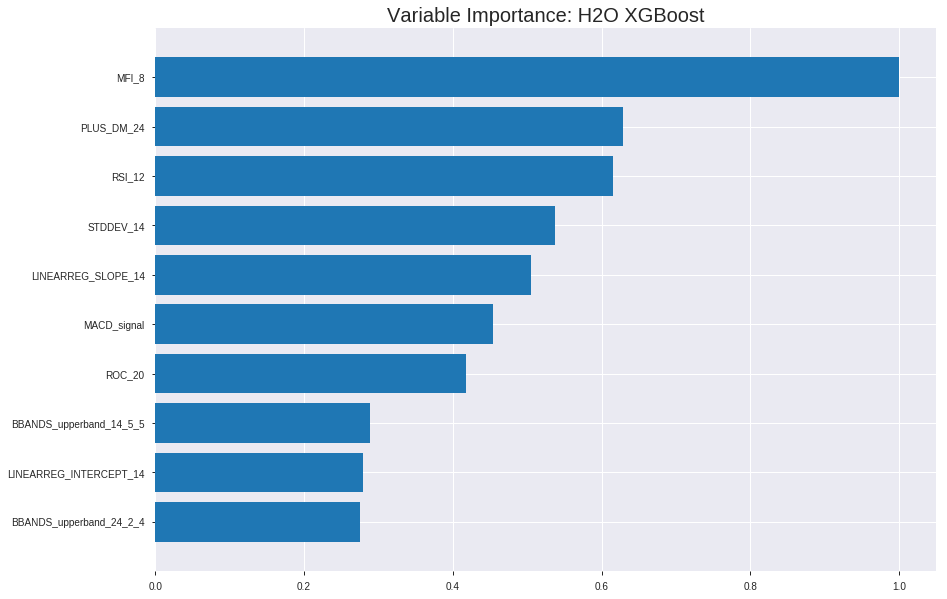

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_202853


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19991618679230808
RMSE: 0.4471198796657425
LogLoss: 0.5904555521005428
Mean Per-Class Error: 0.21665568897950538
AUC: 0.859696055976275
pr_auc: 0.8651637913429273
Gini: 0.7193921119525499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49746353427569073: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      474  262  0.356    (262.0/736.0)
1      94   727  0.1145   (94.0/821.0)
Total  568  989  0.2286   (356.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497464     0.803315  231
max f2                       0.431572     0.880158  299
max f0point5                 0.559648     0.803968  159
max accuracy                 0.525659     0.7842    198
max precision                0.776708     1         0
max recall                   0.331889     1         377
max specificity              0.776708     1         0
max absolute_mcc             0.525659     0.566945  198
max min_per_class_accuracy   0.529787     0.779891  193
max mean_per_class_accuracy  0.525659     0.783344  198

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 52.59 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.713799           1.89647    1.89647            1                0.733991  1                           0.733991            0.0194884       0.0194884                  89.6468   89.6468
    2        0.0205523                   0.697052           1.77794    1.8372             0.9375           0.702807  0.96875                     0.718399            0.0182704       0.0377588                  77.7938   83.7203
    3        0.0301863                   0.686853           1.89647    1.85612            1                0.691925  0.978723                    0.70995             0.0182704       0.0560292                  89.6468   85.6117
    4        0.0404624                   0.680624           1.77794    1.83626            0.9375           0.684054  0.968254                    0.703373            0.0182704       0.0742996                  77.7938   83.6262
    5        0.0500963                   0.670508           1.89647    1.84784            1                0.67444   0.974359                    0.697809            0.0182704       0.09257                    89.6468   84.784
    6        0.100193                    0.644511           1.82353    1.83568            0.961538         0.655664  0.967949                    0.676736            0.091352        0.183922                   82.3527   83.5684
    7        0.150289                    0.624381           1.65333    1.7749             0.871795         0.634431  0.935897                    0.662635            0.0828258       0.266748                   65.3331   77.4899
    8        0.200385                    0.610246           1.67764    1.75059            0.884615         0.617489  0.923077                    0.651348            0.0840438       0.350792                   67.7645   75.0586
    9        0.299936                    0.584731           1.56612    1.68936            0.825806         0.597388  0.890792                    0.633439            0.155907        0.506699                   56.6115   68.9359
    10       0.400128                    0.562097           1.41019    1.61946            0.74359          0.574052  0.853933                    0.618568            0.141291        0.64799                    41.0194   61.9456
    11       0.500321                    0.534671           1.16706    1.52886            0.615385         0.547939  0.806162                    0.604424            0.116931        0.764921                   16.7057   52.886
    12       0.599872                    0.506019           0.856469   1.41727            0.451613         0.519944  0.747323                    0.590404            0.0852619       0.850183                   -14.3531  41.7275
    13       0.700064                    0.476429           0.753724   1.32231            0.397436         0.491663  0.697248                    0.576272            0.0755177       0.9257                     -24.6276  32.2308
    14       0.799615                    0.438339           0.415999   1.20947            0.219355         0.458267  0.637751                    0.561581            0.0414129       0.967113                   -58.4001  20.9474
    15       0.899807                    0.391005           0.267451   1.10458            0.141026         0.415138  0.582441                    0.545275            0.0267966       0.99391                    -73.2549  10.4581
    16       1                           0.217498           0.0607842  1                  0.0320513        0.35219   0.527296                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2674319230928847
RMSE: 0.5171382050215249
LogLoss: 0.7291873832001344
Mean Per-Class Error: 0.48797386414208843
AUC: 0.4650645304850912
pr_auc: 0.4655046719394705
Gini: -0.06987093902981756
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31902021169662476: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    214  0        (0.0/214.0)
Total  0    445  0.5191   (231.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.31902      0.649469   399
max f2                       0.31902      0.822444   399
max f0point5                 0.31902      0.53661    399
max accuracy                 0.698001     0.530337   6
max precision                0.745071     1          0
max recall                   0.31902      1          399
max specificity              0.745071     1          0
max absolute_mcc             0.353806     0.0989486  395
max min_per_class_accuracy   0.559948     0.476636   199
max mean_per_class_accuracy  0.695246     0.512026   8

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 54.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.700412           1.66355   1.66355            0.8              0.715137  0.8                         0.715137            0.0186916       0.0186916                  66.3551   66.3551
    2        0.0202247                   0.690966           1.55958   1.61734            0.75             0.697055  0.777778                    0.707101            0.0140187       0.0327103                  55.9579   61.7342
    3        0.0314607                   0.681711           0         1.03972            0                0.685255  0.5                         0.699299            0               0.0327103                  -100      3.97196
    4        0.0404494                   0.680028           1.55958   1.15524            0.75             0.68081   0.555556                    0.69519             0.0140187       0.046729                   55.9579   15.5244
    5        0.0516854                   0.674009           0.831776  1.08492            0.4              0.67623   0.521739                    0.691068            0.00934579      0.0560748                  -16.8224  8.49248
    6        0.101124                    0.652374           0.85068   0.970405           0.409091         0.662325  0.466667                    0.677016            0.0420561       0.0981308                  -14.932   -2.9595
    7        0.150562                    0.637886           0.9452    0.962129           0.454545         0.644135  0.462687                    0.666219            0.046729        0.14486                    -5.48003  -3.78714
    8        0.2                         0.626422           0.4726    0.841121           0.227273         0.632859  0.404494                    0.657973            0.0233645       0.168224                   -52.74    -15.8879
    9        0.301124                    0.60738            1.06282   0.915574           0.511111         0.615791  0.440299                    0.643807            0.107477        0.275701                   6.28245   -8.4426
    10       0.4                         0.585415           0.9452    0.922897           0.454545         0.59493   0.44382                     0.631725            0.0934579       0.369159                   -5.48003  -7.71028
    11       0.501124                    0.559581           1.06282   0.951134           0.511111         0.572023  0.457399                    0.619678            0.107477        0.476636                   6.28245   -4.88664
    12       0.6                         0.532635           1.13424   0.981308           0.545455         0.545408  0.47191                     0.607439            0.11215         0.588785                   13.424    -1.86916
    13       0.698876                    0.496737           0.9452    0.9762             0.454545         0.515369  0.469453                    0.594413            0.0934579       0.682243                   -5.48003  -2.38002
    14       0.8                         0.451437           0.924195  0.969626           0.444444         0.477173  0.466292                    0.579593            0.0934579       0.775701                   -7.58048  -3.03738
    15       0.898876                    0.409536           1.08698   0.982535           0.522727         0.431357  0.4725                      0.563287            0.107477        0.883178                   8.69796   -1.7465
    16       1                           0.31902            1.15524   1                  0.555556         0.381087  0.480899                    0.544862  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:28:58  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.472704                         0.5                0.693147              0.5               0                    1                  0.519101
    2019-08-27 20:28:58  0.130 sec   5                  0.491833         0.676925            0.735448        0.748076           1.79111          0.339114                         0.50097            0.695088              0.486598          0.484872             1.24766            0.516854
    2019-08-27 20:28:58  0.204 sec   10                 0.485142         0.663761            0.762181        0.781831           1.89647          0.346821                         0.503259           0.699701              0.479589          0.485251             1.66355            0.516854
    2019-08-27 20:28:58  0.291 sec   15                 0.479442         0.65262             0.779225        0.799594           1.89647          0.316635                         0.504312           0.701844              0.474147          0.475349             1.66355            0.516854
    2019-08-27 20:28:58  0.370 sec   20                 0.474431         0.64284             0.791573        0.808751           1.89647          0.304432                         0.506301           0.705922              0.469657          0.474356             1.66355            0.519101
    2019-08-27 20:28:58  0.455 sec   25                 0.468687         0.631715            0.808057        0.819738           1.89647          0.285806                         0.508657           0.710817              0.468918          0.468672             1.66355            0.519101
    2019-08-27 20:28:58  0.539 sec   30                 0.46417          0.623               0.819545        0.827152           1.89647          0.274888                         0.509733           0.713063              0.469616          0.471091             1.66355            0.519101
    2019-08-27 20:28:58  0.629 sec   35                 0.460087         0.615136            0.828888        0.836194           1.89647          0.257547                         0.510545           0.714835              0.472367          0.476603             1.24766            0.519101
    2019-08-27 20:28:58  0.713 sec   40                 0.454497         0.604512            0.845426        0.852537           1.89647          0.23571                          0.513311           0.720831              0.469555          0.466225             1.24766            0.519101
    2019-08-27 20:28:58  0.821 sec   45                 0.450476         0.596797            0.852476        0.859579           1.89647          0.240848                         0.516135           0.726978              0.465408          0.463231             1.24766            0.519101
    2019-08-27 20:28:58  0.902 sec   50                 0.44712          0.590456            0.859696        0.865164           1.89647          0.228645                         0.517138           0.729187              0.465065          0.465505             1.66355            0.519101

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ---------------------
MFI_8                     368.18994140625        1.0                    0.10930806187995748
PLUS_DM_24                231.62135314941406     0.6290811537783153     0.06876364168471513
RSI_12                    226.7639617919922      0.615888530050275      0.06732158155389151
STDDEV_14                 198.0076904296875      0.5377868001320862     0.0587844328270624
LINEARREG_SLOPE_14        186.0164337158203      0.5052186732895433     0.05522447400284342
---                       ---                    ---                    ---
MAVP_20_0                 8.264655113220215      0.022446716174957197   0.002453607040654064
MA_8_0                    7.935079574584961      0.02155159248587301    0.0023557628050574334
CDLBELTHOLD               2.6569976806640625     0.007216377694936563   0.0007888082596272707
BBANDS_middleband_8_0_3   1.4284883737564087     0.0038797593663218964  0.0004240889768932585
BBANDS_middleband_24_1_4  0.9751205444335938     0.0026484171205472294  0.0002894933424967154


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5381165919282511)

('F1', 0.66006600660066)

('auc', 0.5062801932367149)

('logloss', 0.7127465190776957)

('mean_per_class_error', 0.4500805152979066)

('rmse', 0.5091241630414753)

('mse', 0.2592074133926827)

xgboost prediction progress: |████████████████████████████████████████████| 100%


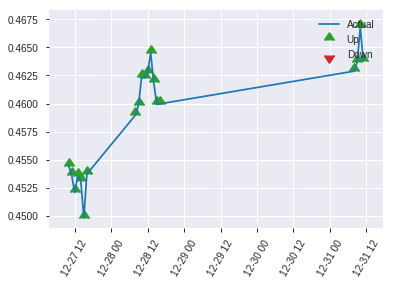


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2592074133926827
RMSE: 0.5091241630414753
LogLoss: 0.7127465190776957
Mean Per-Class Error: 0.4500805152979066
AUC: 0.5062801932367149
pr_auc: 0.47669302728573604
Gini: 0.01256038647342983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4781217575073242: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   95   0.8261   (95.0/115.0)
1      8    100  0.0741   (8.0/108.0)
Total  28   195  0.4619   (103.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478122     0.660066  194
max f2                       0.381002     0.825688  220
max f0point5                 0.478122     0.563063  194
max accuracy                 0.481481     0.538117  192
max precision                0.748712     1         0
max recall                   0.381002     1         220
max specificity              0.748712     1         0
max absolute_mcc             0.478122     0.150579  194
max min_per_class_accuracy   0.565319     0.490741  107
max mean_per_class_accuracy  0.478122     0.549919  194

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 55.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.740833           0.688272  0.688272           0.333333         0.74552   0.333333                    0.74552             0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.726302           0         0.412963           0                0.732097  0.2                         0.740151            0               0.00925926                 -100      -58.7037
    3        0.0313901                   0.708068           2.06481   0.884921           1                0.716309  0.428571                    0.733339            0.0185185       0.0277778                  106.481   -11.5079
    4        0.0403587                   0.704482           1.03241   0.917695           0.5              0.706131  0.444444                    0.727292            0.00925926      0.037037                   3.24074   -8.23045
    5        0.0538117                   0.695714           1.37654   1.03241            0.666667         0.699985  0.5                         0.720465            0.0185185       0.0555556                  37.6543   3.24074
    6        0.103139                    0.635705           0.750842  0.897746           0.363636         0.654467  0.434783                    0.688901            0.037037        0.0925926                  -24.9158  -10.2254
    7        0.152466                    0.617831           1.31397   1.03241            0.636364         0.626294  0.5                         0.668646            0.0648148       0.157407                   31.3973   3.24074
    8        0.201794                    0.609016           1.12626   1.05535            0.545455         0.612956  0.511111                    0.655033            0.0555556       0.212963                   12.6263   5.53498
    9        0.300448                    0.592878           0.750842  0.955362           0.363636         0.600027  0.462687                    0.636971            0.0740741       0.287037                   -24.9158  -4.46379
    10       0.399103                    0.579731           1.12626   0.997607           0.545455         0.587003  0.483146                    0.624619            0.111111        0.398148                   12.6263   -0.239284
    11       0.502242                    0.560725           0.897746  0.9771             0.434783         0.570092  0.473214                    0.613422            0.0925926       0.490741                   -10.2254  -2.29001
    12       0.600897                    0.544357           1.31397   1.03241            0.636364         0.55271   0.5                         0.603454            0.12963         0.62037                    31.3973   3.24074
    13       0.699552                    0.529732           0.844697  1.00594            0.409091         0.536926  0.487179                    0.594072            0.0833333       0.703704                   -15.5303  0.593542
    14       0.798206                    0.504252           0.938552  0.997607           0.454545         0.51834   0.483146                    0.584712            0.0925926       0.796296                   -6.14478  -0.239284
    15       0.896861                    0.468747           1.40783   1.04273            0.681818         0.486882  0.505                       0.573951            0.138889        0.935185                   40.7828   4.27315
    16       1                           0.359149           0.628422  1                  0.304348         0.424482  0.484305                    0.558

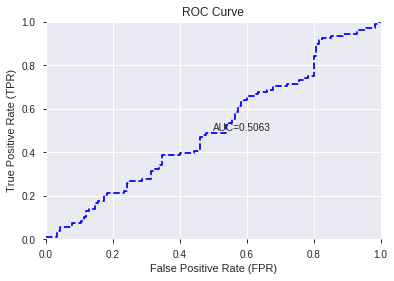

This function is available for GLM models only


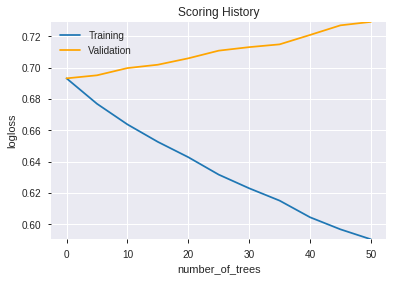

--2019-08-27 20:29:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_202853',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_202853',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_a5c4',
   'type

['MFI_8',
 'PLUS_DM_24',
 'RSI_12',
 'STDDEV_14',
 'LINEARREG_SLOPE_14',
 'MACD_signal',
 'ROC_20',
 'BBANDS_upperband_14_5_5',
 'LINEARREG_INTERCEPT_14',
 'BBANDS_upperband_24_2_4',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_lowerband_30_5_5',
 'BBANDS_lowerband_12_3_5',
 'Open',
 'BBANDS_upperband_30_2_3',
 'TAN',
 'AROONOSC_30',
 'KAMA_8',
 'BBANDS_upperband_14_6_5',
 'BBANDS_upperband_8_3_3',
 'BBANDS_lowerband_24_0_4',
 'BBANDS_lowerband_8_2_5',
 'MIDPRICE_8',
 'MAVP_14_0',
 'BBANDS_lowerband_14_3_2',
 'BBANDS_upperband_14_6_4',
 'BBANDS_lowerband_12_0_3',
 'MA_30_5',
 'BBANDS_upperband_24_2_2',
 'MA_24_1',
 'ROCP_20',
 'BBANDS_middleband_14_5_5',
 'BBANDS_upperband_24_1_2',
 'BBANDS_middleband_12_6_3',
 'TEMA_8',
 'MAX_12',
 'LINEARREG_14',
 'T3_8_7',
 'MIDPOINT_12',
 'CDLRICKSHAWMAN',
 'MAVP_20_0',
 'MA_8_0',
 'CDLBELTHOLD',
 'BBANDS_middleband_8_0_3',
 'BBANDS_middleband_24_1_4']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_202922_model_1  0.570692  0.689323              0.483172  0.498099  0.248103

variable  relative_importance  scaled_importance    percentage
0                  CDLLONGLINE         6.632087e-03           1.000000  1.296510e-02
1                          BOP         6.299911e-03           0.949914  1.231573e-02
2                  CDL3OUTSIDE         6.199123e-03           0.934717  1.211870e-02
3               CDL3LINESTRIKE         4.887953e-03           0.737016  9.555487e-03
4           CDLEVENINGDOJISTAR         4.858876e-03           0.732631  9.498644e-03
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_12_2_3         4.273354e-08           0.000006  8.354003e-08
1034   BBANDS_middleband_8_8_2         0.000000e+00           0.000000  0.000000e+00
1035   BBANDS_middleband_8_8_3         0.000000e+00           0.000000  0.000000e+00
1036   BBANDS_middleband_8_8_4         0.000000e+00           0.000000  0.000000e+00
1037   BBANDS_middleband_8_8_5         0.000000e+00           0.000000  0.000000e+00

[1038 rows x 4 columns]

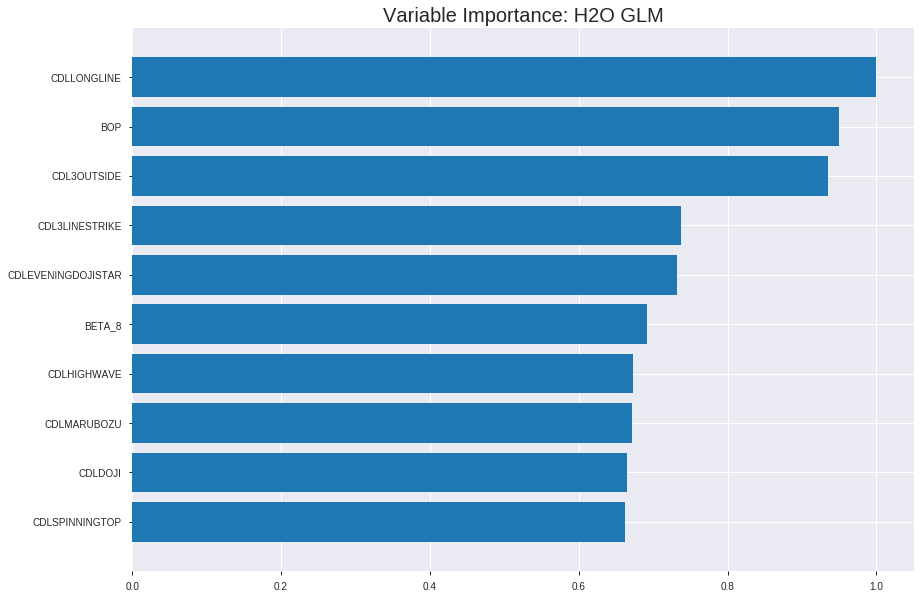

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_202922_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2458904389276922
RMSE: 0.4958734101841842
LogLoss: 0.6848984294434566
Null degrees of freedom: 1556
Residual degrees of freedom: 522
Null deviance: 2153.817678601273
Residual deviance: 2132.773709286924
AIC: 4202.773709286924
AUC: 0.5777162328549489
pr_auc: 0.5888638980947009
Gini: 0.15543246570989777
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4194155279632681: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    733   0.9959   (733.0/736.0)
1      1    820   0.0012   (1.0/821.0)
Total  4    1553  0.4714   (734.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419416     0.690817  395
max f2                       0.400049     0.84814   398
max f0point5                 0.497338     0.599588  274
max accuracy                 0.500242     0.566474  268
max precision                0.591508     1         0
max recall                   0.400049     1         398
max specificity              0.591508     1         0
max absolute_mcc             0.497338     0.125846  274
max min_per_class_accuracy   0.535343     0.55163   163
max mean_per_class_accuracy  0.5297       0.559847  182

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.580836           1.18529   1.18529            0.625            0.585042  0.625                       0.585042            0.0121803       0.0121803                  18.5292   18.5292
    2        0.0205523                   0.576162           1.30382   1.24456            0.6875           0.578024  0.65625                     0.581533            0.0133983       0.0255786                  30.3822   24.4557
    3        0.0301863                   0.57351            1.39074   1.29121            0.733333         0.574714  0.680851                    0.579357            0.0133983       0.0389769                  39.0743   29.1212
    4        0.0404624                   0.5718             0.948234  1.20411            0.5              0.572593  0.634921                    0.577639            0.00974421      0.0487211                  -5.17661  20.4106
    5        0.0500963                   0.570325           1.13788   1.19137            0.6              0.57108   0.628205                    0.576378            0.0109622       0.0596833                  13.7881   19.1371
    6        0.100193                    0.565133           1.26431   1.22784            0.666667         0.567649  0.647436                    0.572014            0.0633374       0.123021                   26.4312   22.7841
    7        0.150289                    0.560879           1.0698    1.17516            0.564103         0.563077  0.619658                    0.569035            0.0535932       0.176614                   6.98023   17.5162
    8        0.200385                    0.556957           1.24      1.19137            0.653846         0.558943  0.628205                    0.566512            0.0621194       0.238733                   23.9998   19.1371
    9        0.299936                    0.549615           1.05223   1.14519            0.554839         0.553473  0.603854                    0.562184            0.10475         0.343484                   5.22337   14.519
    10       0.400128                    0.542803           1.02117   1.11414            0.538462         0.546     0.58748                     0.558132            0.102314        0.445798                   2.11749   11.4137
    11       0.500321                    0.535436           1.02117   1.09552            0.538462         0.539141  0.577664                    0.554329            0.102314        0.548112                   2.11749   9.55205
    12       0.599872                    0.525742           1.04      1.08631            0.548387         0.530958  0.572805                    0.55045             0.103532        0.651644                   3.99984   8.63065
    13       0.700064                    0.515476           0.972548  1.07003            0.512821         0.520125  0.56422                     0.54611             0.0974421       0.749086                   -2.74525  7.00254
    14       0.799615                    0.498319           0.966587  1.05715            0.509677         0.507651  0.55743                     0.541322            0.0962241       0.845311                   -3.34132  5.71475
    15       0.899807                    0.477095           0.814509  1.03013            0.429487         0.487765  0.543183                    0.535358            0.0816078       0.926918                   -18.5491  3.01299
    16       1                           0.398711           0.729411  1                  0.384615         0.454889  0.527296                    0.527296          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25175111704629394
RMSE: 0.5017480613278879
LogLoss: 0.6966673829242779
Null degrees of freedom: 444
Residual degrees of freedom: -590
Null deviance: 620.0871872338774
Residual deviance: 620.0339708026073
AIC: 2690.033970802607
AUC: 0.5197637253712021
pr_auc: 0.4929117800884543
Gini: 0.03952745074240416
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4472669238418786: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    229  0.9913   (229.0/231.0)
1      0    214  0        (0.0/214.0)
Total  2    443  0.5146   (229.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.447267     0.651446   397
max f2                       0.447267     0.823711   397
max f0point5                 0.47778      0.542427   368
max accuracy                 0.53767      0.546067   178
max precision                0.565107     0.64       22
max recall                   0.447267     1          397
max specificity              0.581209     0.995671   0
max absolute_mcc             0.537317     0.0887913  181
max min_per_class_accuracy   0.534201     0.536797   196
max mean_per_class_accuracy  0.537317     0.5442     181

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 52.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.575043           0.415888  0.415888           0.2              0.577203  0.2                         0.577203            0.0046729       0.0046729                  -58.4112   -58.4112
    2        0.0202247                   0.571248           1.03972   0.693146           0.5              0.573155  0.333333                    0.575404            0.00934579      0.0140187                  3.97196    -30.6854
    3        0.0314607                   0.569787           2.07944   1.18825            1                0.57059   0.571429                    0.573685            0.0233645       0.0373832                  107.944    18.8251
    4        0.0404494                   0.567348           1.55958   1.27077            0.75             0.568673  0.611111                    0.572571            0.0140187       0.0514019                  55.9579    27.0768
    5        0.0516854                   0.565178           1.24766   1.26575            0.6              0.565777  0.608696                    0.571094            0.0140187       0.0654206                  24.7664    26.5746
    6        0.101124                    0.560328           0.75616   1.01661            0.363636         0.562713  0.488889                    0.566997            0.0373832       0.102804                   -24.384    1.66147
    7        0.150562                    0.5574             0.9452    0.993165           0.454545         0.558662  0.477612                    0.56426             0.046729        0.149533                   -5.48003   -0.683498
    8        0.2                         0.554196           1.13424   1.02804            0.545455         0.555918  0.494382                    0.562198            0.0560748       0.205607                   13.424     2.80374
    9        0.301124                    0.547004           1.06282   1.03972            0.511111         0.550049  0.5                         0.558118            0.107477        0.313084                   6.28245    3.97196
    10       0.4                         0.539729           1.13424   1.06308            0.545455         0.543768  0.511236                    0.554571            0.11215         0.425234                   13.424     6.30841
    11       0.501124                    0.534129           1.10903   1.07236            0.533333         0.537086  0.515695                    0.551043            0.11215         0.537383                   10.9034    7.23566
    12       0.6                         0.525084           0.7089    1.01246            0.340909         0.52985   0.486891                    0.54755             0.0700935       0.607477                   -29.11     1.24611
    13       0.698876                    0.516269           0.99246   1.00963            0.477273         0.520915  0.485531                    0.543782            0.0981308       0.705607                   -0.754036  0.963128
    14       0.8                         0.501913           1.01661   1.01051            0.488889         0.509197  0.485955                    0.53941             0.102804        0.808411                   1.66147    1.0514
    15       0.898876                    0.483534           0.9452    1.00333            0.454545         0.492417  0.4825                      0.534241            0.0934579       0.901869                   -5.48003   0.332944
    16       1                           0.444611           0.970405  1                  0.466667         0.467226  0.480899               


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:29:26  0.000 sec   2            4.1       1035          1.3698            1.39333
    2019-08-27 20:29:28  2.048 sec   4            3         1039          1.36745           1.39499
    2019-08-27 20:29:32  5.852 sec   6            2.2       1039          1.3646            1.39727
    2019-08-27 20:29:34  7.891 sec   8            1.6       1039          1.36122           1.40033
    2019-08-27 20:29:36  9.971 sec   10           1.2       1039          1.35731           1.40444
    2019-08-27 20:29:38  12.030 sec  12           0.84      1039          1.35288           1.40992

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5829596412556054)

('F1', 0.6563467492260062)

('auc', 0.5706924315619968)

('logloss', 0.689322690523321)

('mean_per_class_error', 0.4232286634460547)

('rmse', 0.4980989961869888)

('mse', 0.24810261000248585)

glm prediction progress: |████████████████████████████████████████████████| 100%


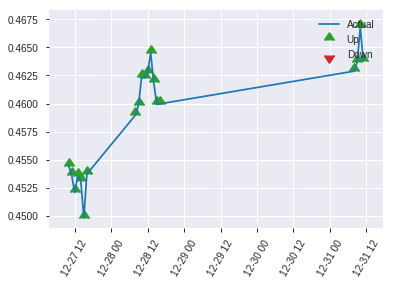


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24810261000248585
RMSE: 0.4980989961869888
LogLoss: 0.689322690523321
Null degrees of freedom: 222
Residual degrees of freedom: -812
Null deviance: 310.57429368859675
Residual deviance: 307.43791997340116
AIC: 2377.437919973401
AUC: 0.5706924315619968
pr_auc: 0.5583575556528149
Gini: 0.14138486312399356
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4491234668797898: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    109  0.9478   (109.0/115.0)
1      2    106  0.0185   (2.0/108.0)
Total  8    215  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449123     0.656347  214
max f2                       0.433863     0.825688  221
max f0point5                 0.483216     0.560976  177
max accuracy                 0.54928      0.58296   66
max precision                0.600327     1         0
max recall                   0.433863     1         221
max specificity              0.600327     1         0
max absolute_mcc             0.54928      0.167375  66
max min_per_class_accuracy   0.530925     0.53913   111
max mean_per_class_accuracy  0.54928      0.576771  66

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 52.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.58963            2.06481   2.06481            1                0.593972  1                           0.593972            0.0277778       0.0277778                  106.481   106.481
    2        0.0224215                   0.583902           1.03241   1.65185            0.5              0.585029  0.8                         0.590394            0.00925926      0.037037                   3.24074   65.1852
    3        0.0313901                   0.583026           1.03241   1.47487            0.5              0.583262  0.714286                    0.588357            0.00925926      0.0462963                  3.24074   47.4868
    4        0.0403587                   0.581798           2.06481   1.60597            1                0.582608  0.777778                    0.587079            0.0185185       0.0648148                  106.481   60.5967
    5        0.0538117                   0.579681           0         1.20448            0                0.580667  0.583333                    0.585476            0               0.0648148                  -100      20.4475
    6        0.103139                    0.571779           1.12626   1.16707            0.545455         0.573989  0.565217                    0.579982            0.0555556       0.12037                    12.6263   16.7069
    7        0.152466                    0.565245           1.31397   1.2146             0.636364         0.567598  0.588235                    0.575976            0.0648148       0.185185                   31.3973   21.4597
    8        0.201794                    0.560693           1.50168   1.28477            0.727273         0.562531  0.622222                    0.572689            0.0740741       0.259259                   50.1684   28.4774
    9        0.300448                    0.549082           1.22012   1.26354            0.590909         0.554735  0.61194                     0.566794            0.12037         0.37963                    22.0118   26.3543
    10       0.399103                    0.539939           0.844697  1.16001            0.409091         0.54482   0.561798                    0.561362            0.0833333       0.462963                   -15.5303  16.0008
    11       0.502242                    0.530925           0.807971  1.08771            0.391304         0.535327  0.526786                    0.556016            0.0833333       0.546296                   -19.2029  8.77149
    12       0.600897                    0.517709           0.656987  1.017              0.318182         0.524407  0.492537                    0.550826            0.0648148       0.611111                   -34.3013  1.69983
    13       0.699552                    0.506016           1.22012   1.04564            0.590909         0.512883  0.50641                     0.545475            0.12037         0.731481                   22.0118   4.56434
    14       0.798206                    0.482749           1.22012   1.06721            0.590909         0.495962  0.516854                    0.539355            0.12037         0.851852                   22.0118   6.72077
    15       0.896861                    0.466449           0.750842  1.03241            0.363636         0.474231  0.5                         0.532192            0.0740741       0.925926                   -24.9158  3.24074
    16       1                           0.429852           0.718196  1                  0.347826         0.453276  0.484305                    0.524052         

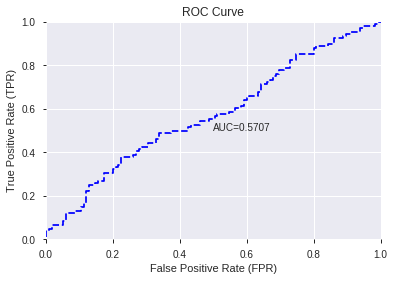

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


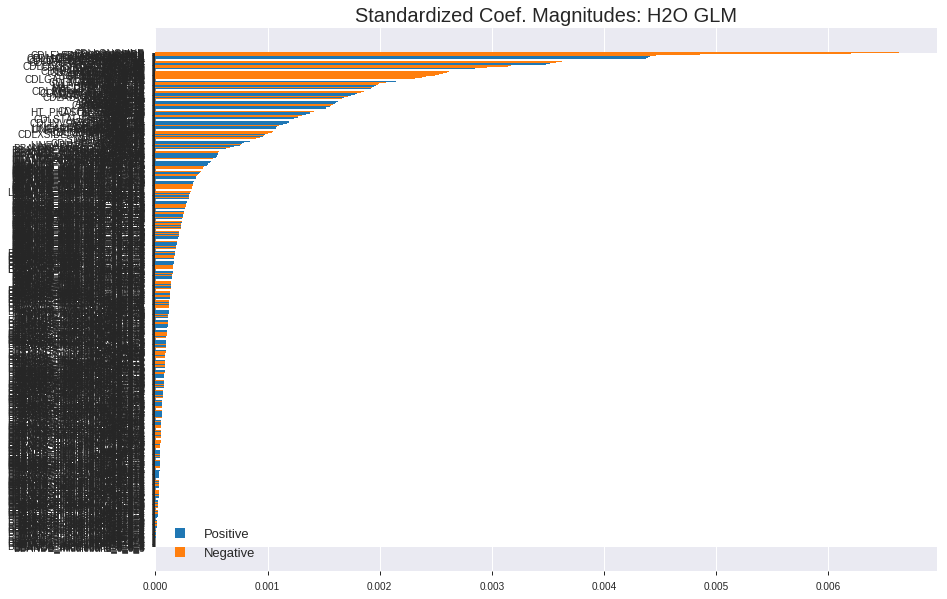

'log_likelihood'
--2019-08-27 20:30:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_202922_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_202922_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

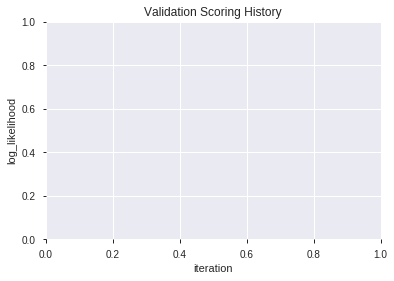

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_203015_model_1  0.556200  0.691812              0.470129  0.499303  0.249303
1  XGBoost_grid_1_AutoML_20190827_203015_model_4  0.543317  0.698968              0.466063  0.502671  0.252678
2               XGBoost_3_AutoML_20190827_203015  0.538647  0.697373              0.458213  0.501993  0.251997
3               XGBoost_2_AutoML_20190827_203015  0.536151  0.715730              0.457649  0.510075  0.260176
4               XGBoost_1_AutoML_20190827_203015  0.525523  0.711923              0.474758  0.508559  0.258632
5  XGBoost_grid_1_AutoML_20190827_203015_model_2  0.524074  0.704480              0.474758  0.505245  0.255272
6  XGBoost_grid_1_AutoML_20190827_203015_model_6  0.518760  0.712602              0.415862  0.508655  0.258730
7  XGBoost_grid_1_AutoML_20190827_203015_model_7  0.506441  0.726103              0.456804  0.514316  0.264521
8  XGBoost_grid_1_AutoML_20190827_203015_model_3  0.492271  0.717005              0.462560  0.511320  0.261448
9  XGBoost_grid_1_AutoML_20190827_203015_model_5  0.489050  0.750325              0.478261  0.524386  0.274980

variable  relative_importance  scaled_importance  percentage
0                        BOP           190.871460           1.000000    0.038398
1               STOCHF_fastk           129.545120           0.678703    0.026061
2                        DIV           104.331726           0.546607    0.020989
3                  STDDEV_24            97.589478           0.511284    0.019633
4                    BETA_12            84.446991           0.442429    0.016989
..                       ...                  ...                ...         ...
221                      day             3.257183           0.017065    0.000655
222   BBANDS_lowerband_8_0_4             2.486435           0.013027    0.000500
223             aroondown_14             2.236111           0.011715    0.000450
224                       AD             1.748842           0.009162    0.000352
225  BBANDS_lowerband_30_1_5             1.641588           0.008600    0.000330

[226 rows x 4 columns]

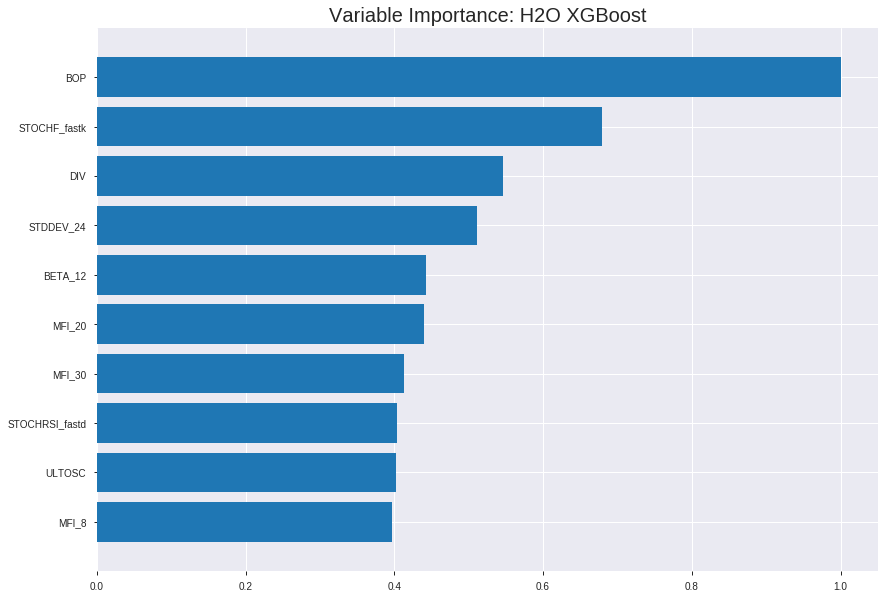

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_203015_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17417124604324846
RMSE: 0.4173382872961076
LogLoss: 0.5362617969967852
Mean Per-Class Error: 0.12035627283800243
AUC: 0.9494237541704179
pr_auc: 0.9554214377194932
Gini: 0.8988475083408358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5235942006111145: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      644  92   0.125    (92.0/736.0)
1      95   726  0.1157   (95.0/821.0)
Total  739  818  0.1201   (187.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.523594     0.885906  199
max f2                       0.463325     0.917431  251
max f0point5                 0.56085      0.904397  166
max accuracy                 0.523594     0.879897  199
max precision                0.84896      1         0
max recall                   0.391879     1         313
max specificity              0.84896      1         0
max absolute_mcc             0.523594     0.759133  199
max min_per_class_accuracy   0.525665     0.877717  197
max mean_per_class_accuracy  0.523594     0.879644  199

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 52.51 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0109184                   0.759853           1.89647    1.89647            1                0.785945  1                           0.785945            0.0207065       0.0207065                  89.6468   89.6468
    2        0.0205523                   0.744486           1.89647    1.89647            1                0.751976  1                           0.770022            0.0182704       0.0389769                  89.6468   89.6468
    3        0.0301863                   0.731985           1.89647    1.89647            1                0.73808   1                           0.759828            0.0182704       0.0572473                  89.6468   89.6468
    4        0.0404624                   0.722977           1.89647    1.89647            1                0.727296  1                           0.751566            0.0194884       0.0767357                  89.6468   89.6468
    5        0.0500963                   0.707955           1.89647    1.89647            1                0.715429  1                           0.744616            0.0182704       0.0950061                  89.6468   89.6468
    6        0.100193                    0.674854           1.89647    1.89647            1                0.691637  1                           0.718127            0.0950061       0.190012                   89.6468   89.6468
    7        0.150289                    0.652923           1.87215    1.88836            0.987179         0.663085  0.995726                    0.699779            0.0937881       0.2838                     87.2154   88.8363
    8        0.200385                    0.633727           1.87215    1.88431            0.987179         0.643569  0.99359                     0.685727            0.0937881       0.377588                   87.2154   88.4311
    9        0.299936                    0.598003           1.83529    1.86804            0.967742         0.614699  0.985011                    0.662152            0.182704        0.560292                   83.5291   86.8041
    10       0.400128                    0.565767           1.66549    1.81732            0.878205         0.581824  0.958266                    0.642038            0.16687         0.727162                   66.5488   81.7321
    11       0.500321                    0.532265           1.28863    1.71145            0.679487         0.547153  0.902439                    0.623037            0.129111        0.856273                   28.8626   71.1446
    12       0.599872                    0.495414           0.783058   1.55738            0.412903         0.512491  0.821199                    0.604691            0.0779537       0.934227                   -21.6942  55.7378
    13       0.700064                    0.459245           0.413333   1.39364            0.217949         0.477885  0.734862                    0.586543            0.0414129       0.975639                   -58.6667  39.3643
    14       0.799615                    0.419436           0.208      1.24603            0.109677         0.440289  0.657028                    0.568335            0.0207065       0.996346                   -79.2     24.6033
    15       0.899807                    0.360561           0.0364705  1.11135            0.0192308        0.391278  0.58601                     0.54862             0.00365408      1                          -96.3529  11.1349
    16       1                           0.196991           0          1                  0                0.313956  0.527296                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26842503023512787
RMSE: 0.5180975103541108
LogLoss: 0.7318328623143872
Mean Per-Class Error: 0.4956709956709957
AUC: 0.4513492737791803
pr_auc: 0.4451361976992189
Gini: -0.09730145244163935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3216792643070221: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    229  0.9913   (229.0/231.0)
1      0    214  0        (0.0/214.0)
Total  2    443  0.5146   (229.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321679     0.651446  397
max f2                       0.321679     0.823711  397
max f0point5                 0.321679     0.538771  397
max accuracy                 0.805756     0.516854  0
max precision                0.321679     0.48307   397
max recall                   0.321679     1         397
max specificity              0.805756     0.995671  0
max absolute_mcc             0.463248     0.154485  318
max min_per_class_accuracy   0.541799     0.481308  201
max mean_per_class_accuracy  0.321679     0.504329  397

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 53.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.724909           0.415888  0.415888           0.2              0.759181  0.2                         0.759181            0.0046729       0.0046729                  -58.4112   -58.4112
    2        0.0202247                   0.704893           1.03972   0.693146           0.5              0.71746   0.333333                    0.740638            0.00934579      0.0140187                  3.97196    -30.6854
    3        0.0314607                   0.698225           0.415888  0.594126           0.2              0.700796  0.285714                    0.726409            0.0046729       0.0186916                  -58.4112   -40.5874
    4        0.0404494                   0.693852           1.03972   0.693146           0.5              0.695941  0.333333                    0.719638            0.00934579      0.0280374                  3.97196    -30.6854
    5        0.0516854                   0.683236           1.24766   0.813694           0.6              0.687466  0.391304                    0.712644            0.0140187       0.0420561                  24.7664    -18.6306
    6        0.101124                    0.644063           0.75616   0.785566           0.363636         0.659209  0.377778                    0.68652             0.0373832       0.0794393                  -24.384    -21.4434
    7        0.150562                    0.624098           1.03972   0.869019           0.5              0.632773  0.41791                     0.668872            0.0514019       0.130841                   3.97196    -13.0981
    8        0.2                         0.615847           1.03972   0.911215           0.5              0.619869  0.438202                    0.656759            0.0514019       0.182243                   3.97196    -8.8785
    9        0.301124                    0.590139           1.01661   0.94661            0.488889         0.603632  0.455224                    0.638918            0.102804        0.285047                   1.66147    -5.33896
    10       0.4                         0.561326           0.99246   0.957944           0.477273         0.575631  0.460674                    0.623274            0.0981308       0.383178                   -0.754036  -4.20561
    11       0.501124                    0.540382           0.970405  0.960458           0.466667         0.549316  0.461883                    0.608349            0.0981308       0.481308                   -2.9595    -3.95415
    12       0.6                         0.515443           1.08698   0.981308           0.522727         0.52919   0.47191                     0.595304            0.107477        0.588785                   8.69796    -1.86916
    13       0.698876                    0.49057            0.61438   0.929396           0.295455         0.502849  0.446945                    0.582224            0.0607477       0.649533                   -38.562    -7.06043
    14       0.8                         0.464129           0.877985  0.922897           0.422222         0.477661  0.44382                     0.569007            0.088785        0.738318                   -12.2015   -7.71028
    15       0.898876                    0.43617            1.27602   0.961741           0.613636         0.45137   0.4625                      0.556067            0.126168        0.864486                   27.602     -3.82593
    16       1                           0.279203           1.34008   1                  0.644444         0.39234   0.480899      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:30:32  0.016 sec   0                  0.5              0.693147            0.5             0                  1                0.472704                         0.5                0.693147              0.5               0                    1                  0.519101
    2019-08-27 20:30:33  1.143 sec   5                  0.486574         0.666584            0.802782        0.826809           1.89647          0.314066                         0.503956           0.701119              0.442529          0.444475             0                  0.516854
    2019-08-27 20:30:34  1.377 sec   10                 0.475841         0.645691            0.833577        0.853334           1.89647          0.276172                         0.506666           0.706702              0.434539          0.432168             0.415888           0.516854
    2019-08-27 20:30:34  1.613 sec   15                 0.465084         0.624993            0.86583         0.880339           1.89647          0.225434                         0.508535           0.71056               0.433012          0.434062             0.415888           0.516854
    2019-08-27 20:30:34  1.840 sec   20                 0.456327         0.608331            0.887196        0.899748           1.89647          0.210019                         0.511142           0.716029              0.432213          0.438051             1.24766            0.516854
    2019-08-27 20:30:34  2.068 sec   25                 0.446671         0.590229            0.911816        0.921964           1.89647          0.179833                         0.512987           0.719963              0.431232          0.442738             0.831776           0.516854
    2019-08-27 20:30:35  2.297 sec   30                 0.439225         0.576343            0.924592        0.934858           1.89647          0.161207                         0.513684           0.721621              0.441558          0.448642             0.831776           0.514607
    2019-08-27 20:30:35  2.505 sec   35                 0.435367         0.569114            0.926162        0.936023           1.89647          0.155427                         0.514385           0.723195              0.447182          0.452878             0.831776           0.514607
    2019-08-27 20:30:35  2.730 sec   40                 0.427957         0.555604            0.938543        0.945977           1.89647          0.140013                         0.515585           0.726041              0.450712          0.451254             0.831776           0.514607
    2019-08-27 20:30:35  2.952 sec   45                 0.422244         0.545138            0.944432        0.951183           1.89647          0.136159                         0.517156           0.729575              0.450449          0.447787             0.415888           0.514607
    2019-08-27 20:30:35  3.172 sec   50                 0.417338         0.536262            0.949424        0.955421           1.89647          0.120103                         0.518098           0.731833              0.451349          0.445136             0.415888           0.514607

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BOP                      190.8714599609375      1.0                   0.03839844895640416
STOCHF_fastk             129.5451202392578      0.6787034597302796    0.026061160154988047
DIV                      104.33172607421875     0.5466072617434298    0.02098887103925494
STDDEV_24                97.5894775390625       0.5112837590231379    0.01963250332308841
BETA_12                  84.44699096679688      0.44242859034074156   0.016988571643052813
---                      ---                    ---                   ---
day                      3.2571828365325928     0.017064797624533213  0.0006552617605370056
BBANDS_lowerband_8_0_4   2.4864349365234375     0.01302675076217416   0.0005002070242091435
aroondown_14             2.2361111640930176     0.011715272490453238  0.0004498482927350345
AD                       1.7488422393798828     0.009162408249707888  0.0003518222654941448
BBANDS_lowerband_30_1_5  1.6415882110595703     0.00860049067259991   0.0003302455020918578


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5695067264573991)

('F1', 0.6625000000000001)

('auc', 0.5561996779388083)

('logloss', 0.6918115850797196)

('mean_per_class_error', 0.4297906602254429)

('rmse', 0.49930285251639767)

('mse', 0.24930333853101158)

xgboost prediction progress: |████████████████████████████████████████████| 100%


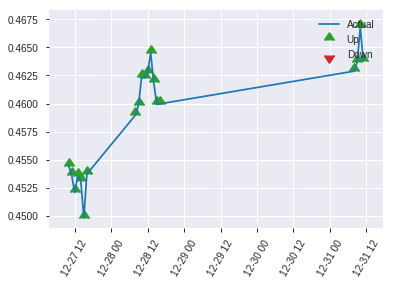


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24930333853101158
RMSE: 0.49930285251639767
LogLoss: 0.6918115850797196
Mean Per-Class Error: 0.4297906602254429
AUC: 0.5561996779388083
pr_auc: 0.5261834754977848
Gini: 0.11239935587761662
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38813477754592896: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    106  0.9217   (106.0/115.0)
1      2    106  0.0185   (2.0/108.0)
Total  11   212  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388135     0.6625    211
max f2                       0.288805     0.825688  221
max f0point5                 0.515988     0.559441  115
max accuracy                 0.533492     0.569507  87
max precision                0.738946     1         0
max recall                   0.288805     1         221
max specificity              0.738946     1         0
max absolute_mcc             0.515988     0.140464  115
max min_per_class_accuracy   0.519552     0.556522  111
max mean_per_class_accuracy  0.515988     0.570209  115

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 51.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.704827           1.37654   1.37654            0.666667         0.720943  0.666667                    0.720943            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.681594           2.06481   1.65185            1                0.697525  0.8                         0.711575            0.0185185       0.037037                   106.481   65.1852
    3        0.0313901                   0.668151           0         1.17989            0                0.669419  0.571429                    0.699531            0               0.037037                   -100      17.9894
    4        0.0403587                   0.658174           2.06481   1.37654            1                0.665889  0.666667                    0.692055            0.0185185       0.0555556                  106.481   37.6543
    5        0.0538117                   0.647766           0.688272  1.20448            0.333333         0.653101  0.583333                    0.682317            0.00925926      0.0648148                  -31.1728  20.4475
    6        0.103139                    0.610052           0.750842  0.98752            0.363636         0.630982  0.478261                    0.657765            0.037037        0.101852                   -24.9158  -1.24799
    7        0.152466                    0.594469           1.12626   1.03241            0.545455         0.601784  0.5                         0.639654            0.0555556       0.157407                   12.6263   3.24074
    8        0.201794                    0.580163           1.31397   1.10123            0.636364         0.587183  0.533333                    0.626827            0.0648148       0.222222                   31.3973   10.1235
    9        0.300448                    0.553402           1.12626   1.10945            0.545455         0.565449  0.537313                    0.606673            0.111111        0.333333                   12.6263   10.9453
    10       0.399103                    0.532011           1.31397   1.16001            0.636364         0.542311  0.561798                    0.590763            0.12963         0.462963                   31.3973   16.0008
    11       0.502242                    0.519552           0.98752   1.12459            0.478261         0.525506  0.544643                    0.577362            0.101852        0.564815                   -1.24799  12.4587
    12       0.600897                    0.502862           0.656987  1.04782            0.318182         0.510182  0.507463                    0.566333            0.0648148       0.62963                    -34.3013  4.78165
    13       0.699552                    0.477972           1.03241   1.04564            0.5              0.492256  0.50641                     0.555886            0.101852        0.731481                   3.24074   4.56434
    14       0.798206                    0.455172           0.938552  1.03241            0.454545         0.464531  0.5                         0.544595            0.0925926       0.824074                   -6.14478  3.24074
    15       0.896861                    0.42038            0.844697  1.01176            0.409091         0.435541  0.49                        0.532599            0.0833333       0.907407                   -15.5303  1.17593
    16       1                           0.287587           0.897746  1                  0.434783         0.373875  0.484305                    0.516228        

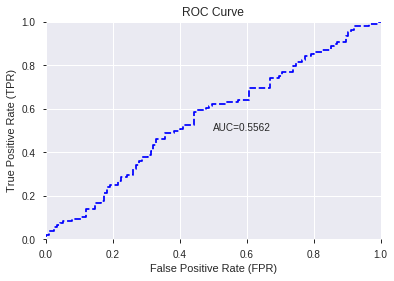

This function is available for GLM models only


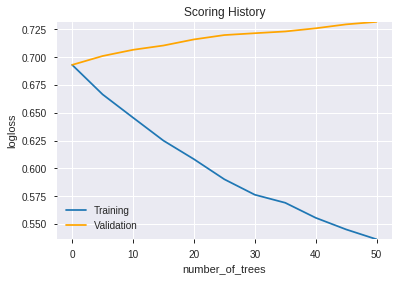

--2019-08-27 20:31:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.180
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.180|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_203015_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_203015_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_203119_model_6  0.534259  0.693014              0.486957  0.499934  0.249934
1  DeepLearning_grid_1_AutoML_20190827_203119_model_5  0.523309  0.695962              0.478824  0.501404  0.251406
2  DeepLearning_grid_1_AutoML_20190827_203119_model_1  0.498551  0.793279              0.457085  0.536563  0.287900
3  DeepLearning_grid_1_AutoML_20190827_203119_model_7  0.495572  0.697258              0.495652  0.502009  0.252013
4  DeepLearning_grid_1_AutoML_20190827_203119_model_8  0.466989  0.692685              0.500000  0.499769  0.249769
5  DeepLearning_grid_1_AutoML_20190827_203119_model_3  0.457005  0.708881              0.482890  0.507575  0.257632
6  DeepLearning_grid_1_AutoML_20190827_203119_model_2  0.455233  0.711945              0.500000  0.509088  0.259171
7  DeepLearning_grid_1_AutoML_20190827_203119_model_4  0.443639  0.712986              0.495652  0.509596  0.259689
8               DeepLearning_1_AutoML_20190827_203119  0.432287  0.851800              0.495652  0.560555  0.314222

variable  relative_importance  scaled_importance  percentage
0                 PLUS_DM_24             1.000000           1.000000    0.029940
1             CDLRICKSHAWMAN             0.888978           0.888978    0.026616
2         LINEARREG_SLOPE_14             0.850272           0.850272    0.025457
3                AROONOSC_30             0.828626           0.828626    0.024809
4                MACD_signal             0.825560           0.825560    0.024717
5                     RSI_12             0.812781           0.812781    0.024335
6                  STDDEV_14             0.809200           0.809200    0.024227
7                      MFI_8             0.764335           0.764335    0.022884
8                    ROCP_20             0.741830           0.741830    0.022210
9                     ROC_20             0.708188           0.708188    0.021203
10             CDLHANGINGMAN             0.707370           0.707370    0.021179
11   BBANDS_lowerband_12_3_5             0.695993           0.695993    0.020838
12               CDLBELTHOLD             0.685911           0.685911    0.020536
13                    T3_8_7             0.661020           0.661020    0.019791
14              LINEARREG_14             0.654440           0.654440    0.019594
15   BBANDS_upperband_24_2_4             0.653282           0.653282    0.019559
16                MIDPRICE_8             0.652246           0.652246    0.019528
17    BBANDS_lowerband_8_2_5             0.649517           0.649517    0.019446
18    BBANDS_upperband_8_3_3             0.648805           0.648805    0.019425
19  BBANDS_middleband_14_7_5             0.646841           0.646841    0.019366
20   BBANDS_upperband_14_6_5             0.645812           0.645812    0.019336
21   BBANDS_upperband_30_2_3             0.639446           0.639446    0.019145
22                   MA_30_5             0.635474           0.635474    0.019026
23   BBANDS_upperband_24_2_2             0.631977           0.631977    0.018921
24               MIDPOINT_12             0.631664           0.631664    0.018912
25   BBANDS_lowerband_12_0_3             0.630847           0.630847    0.018887
26   BBANDS_upperband_24_1_2             0.629144           0.629144    0.018836
27   BBANDS_lowerband_20_5_2             0.628651           0.628651    0.018822
28                 MAVP_14_0             0.626436           0.626436    0.018755
29                      Open             0.626060           0.626060    0.018744
30                   MA_24_1             0.624626           0.624626    0.018701
31   BBANDS_lowerband_20_5_5             0.624208           0.624208    0.018689
32    LINEARREG_INTERCEPT_14             0.622706           0.622706    0.018644
33              CDLTASUKIGAP             0.621818           0.621818    0.018617
34                    TEMA_8             0.616796           0.616796    0.018467
35   BBANDS_middleband_8_0_3             0.616109           0.616109    0.018446
36   BBANDS_lowerband_30_5_5             0.615217           0.615217    0.018419
37                 MAVP_20_0             0.613816           0.613816    0.018378
38  BBANDS_middleband_12_7_2             0.613720           0.613720    0.018375
39   BBANDS_lowerband_24_0_4             0.610735           0.610735    0.018285
40  BBANDS_middleband_12_6_3             0.609018           0.609018    0.018234
41                       TAN             0.608087           0.608087    0.018206
42   BBANDS_upperband_14_6_4             0.606765           0.606765    0.018166
43                    KAMA_8             0.605198           0.605198    0.018120
44   BBANDS_upperband_14_5_5             0.603644           0.603644    0.018073
45   BBANDS_lowerband_14_3_2             0.601626           0.601626    0.018013
46                    MAX_12             0.600695           0.600695    0.017985
47                    MA_8_0             0.599849           0.599849    0.017959
48  BBANDS_middleband_14_5_5             0.593489  

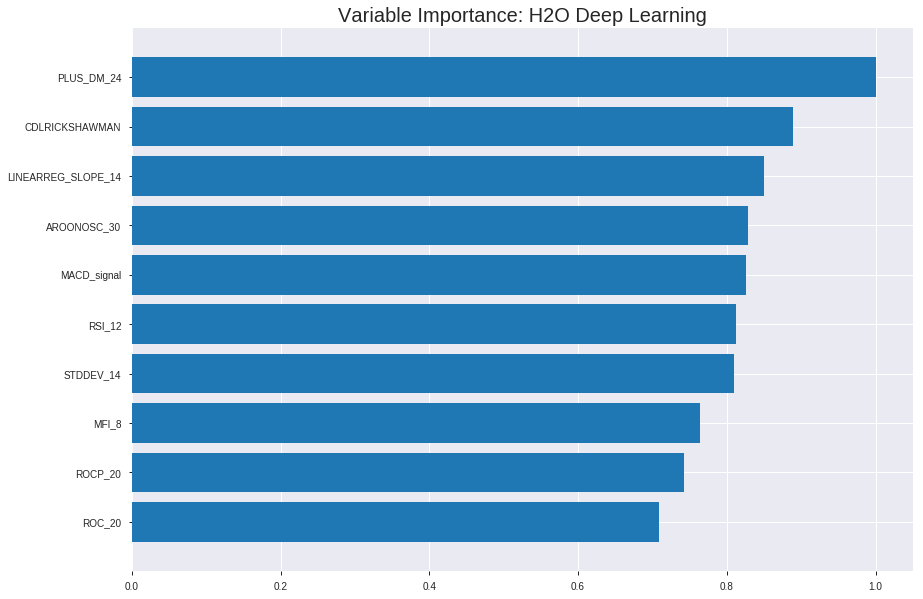

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_203119_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24747527072438893
RMSE: 0.4974688640753197
LogLoss: 0.6880736659433456
Mean Per-Class Error: 0.45088836519620823
AUC: 0.558978313827252
pr_auc: 0.573996993533132
Gini: 0.1179566276545041
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4004960375435225: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   718   0.9755   (718.0/736.0)
1      5    816   0.0061   (5.0/821.0)
Total  23   1534  0.4644   (723.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400496     0.692994  385
max f2                       0.393792     0.84814   398
max f0point5                 0.512241     0.592642  171
max accuracy                 0.512241     0.560694  171
max precision                0.626839     1         0
max recall                   0.393792     1         398
max specificity              0.626839     1         0
max absolute_mcc             0.512241     0.108614  171
max min_per_class_accuracy   0.515045     0.536685  150
max mean_per_class_accuracy  0.512241     0.549112  171

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 50.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.542051           1.06676   1.06676            0.5625           0.567101  0.5625                      0.567101            0.0109622       0.0109622                  6.67631   6.67631
    2        0.0205523                   0.536257           1.18529   1.12603            0.625            0.538823  0.59375                     0.552962            0.0121803       0.0231425                  18.5292   12.6028
    3        0.0301863                   0.534069           1.77004   1.33156            0.933333         0.535263  0.702128                    0.547313            0.0170524       0.0401949                  77.0037   33.1562
    4        0.0404624                   0.532804           1.18529   1.29441            0.625            0.533393  0.68254                     0.543778            0.0121803       0.0523752                  18.5292   29.4414
    5        0.0500963                   0.531677           0.758587  1.19137            0.4              0.532122  0.628205                    0.541536            0.00730816      0.0596833                  -24.1413  19.1371
    6        0.100193                    0.528878           1.16706   1.17921            0.615385         0.530208  0.621795                    0.535872            0.0584653       0.118149                   16.7057   17.9214
    7        0.150289                    0.527072           1.02117   1.12653            0.538462         0.527955  0.594017                    0.533233            0.0511571       0.169306                   2.11749   12.6534
    8        0.200385                    0.52566            1.09412   1.11843            0.576923         0.526319  0.589744                    0.531504            0.0548112       0.224117                   9.4116    11.843
    9        0.299936                    0.52338            1.0767    1.10458            0.567742         0.524519  0.582441                    0.529186            0.107186        0.331303                   7.67043   10.4581
    10       0.400128                    0.521335           1.02117   1.0837             0.538462         0.522426  0.571429                    0.527493            0.102314        0.433618                   2.11749   8.36958
    11       0.500321                    0.515206           1.02117   1.07118            0.538462         0.518863  0.564827                    0.525765            0.102314        0.535932                   2.11749   7.11756
    12       0.624277                    0.512753           1.06124   1.0692             0.559585         0.513047  0.563786                    0.52324             0.131547        0.667479                   6.12358   6.9202
    13       0.700064                    0.512315           1.02859   1.06481            0.542373         0.512526  0.561468                    0.52208             0.0779537       0.745432                   2.85927   6.48057
    14       0.799615                    0.50017            0.856469  1.03887            0.451613         0.509268  0.547791                    0.520485            0.0852619       0.830694                   -14.3531  3.88683
    15       0.899807                    0.44348            0.911763  1.02472            0.480769         0.475614  0.540328                    0.515488            0.091352        0.922046                   -8.82367  2.47153
    16       1                           0.391371           0.778038  1                  0.410256         0.419543  0.527296                    0.505875           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2494592439933896
RMSE: 0.4994589512596502
LogLoss: 0.692052605109512
Mean Per-Class Error: 0.4614334263866975
AUC: 0.5225957842780272
pr_auc: 0.47397684551777064
Gini: 0.04519156855605444
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42670002364012005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    222  0.961    (222.0/231.0)
1      3    211  0.014    (3.0/214.0)
Total  12   433  0.5056   (225.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4267       0.652241  387
max f2                       0.382528     0.823711  397
max f0point5                 0.445039     0.546958  369
max accuracy                 0.526479     0.539326  135
max precision                0.526479     0.531469  135
max recall                   0.382528     1         397
max specificity              0.572416     0.995671  0
max absolute_mcc             0.53017      0.101669  42
max min_per_class_accuracy   0.520846     0.528139  213
max mean_per_class_accuracy  0.521577     0.538567  203

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 50.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.540998           0.415888  0.415888           0.2              0.560605  0.2                         0.560605            0.0046729       0.0046729                  -58.4112  -58.4112
    2        0.0202247                   0.536158           1.03972   0.693146           0.5              0.538557  0.333333                    0.550806            0.00934579      0.0140187                  3.97196   -30.6854
    3        0.0314607                   0.533236           0.415888  0.594126           0.2              0.534431  0.285714                    0.544958            0.0046729       0.0186916                  -58.4112  -40.5874
    4        0.0404494                   0.531228           1.03972   0.693146           0.5              0.531883  0.333333                    0.542052            0.00934579      0.0280374                  3.97196   -30.6854
    5        0.0516854                   0.531012           0.831776  0.723283           0.4              0.531095  0.347826                    0.53967             0.00934579      0.0373832                  -16.8224  -27.6717
    6        0.101124                    0.530156           0.66164   0.693146           0.318182         0.530456  0.333333                    0.535165            0.0327103       0.0700935                  -33.836   -30.6854
    7        0.150562                    0.52977            1.13424   0.837983           0.545455         0.529936  0.402985                    0.533448            0.0560748       0.126168                   13.424    -16.2017
    8        0.2                         0.529123           1.22876   0.934579           0.590909         0.529432  0.449438                    0.532455            0.0607477       0.186916                   22.876    -6.54206
    9        0.301124                    0.52685            1.38629   1.08627            0.666667         0.528121  0.522388                    0.531               0.140187        0.327103                   38.6293   8.62742
    10       0.4                         0.525346           1.03972   1.07477            0.5              0.526087  0.516854                    0.529786            0.102804        0.429907                   3.97196   7.47664
    11       0.501124                    0.520846           1.01661   1.06303            0.488889         0.523064  0.511211                    0.528429            0.102804        0.53271                    1.66147   6.30317
    12       0.6                         0.515907           0.9452    1.04361            0.454545         0.518543  0.501873                    0.5268              0.0934579       0.626168                   -5.48003  4.36137
    13       0.716854                    0.512753           0.879763  1.0169             0.423077         0.513355  0.489028                    0.524608            0.102804        0.728972                   -12.0237  1.69045
    14       0.8                         0.501006           1.01162   1.01636            0.486486         0.507612  0.488764                    0.522842            0.0841121       0.813084                   1.16191   1.63551
    15       0.898876                    0.458115           1.03972   1.01893            0.5              0.481593  0.49                        0.518305            0.102804        0.915888                   3.97196   1.89252
    16       1                           0.37537            0.831776  1                  0.4              0.431019  0.480899                    0.509478 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:35:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:35:07  1 min 54.805 sec  966 obs/sec       1.19461   1             1860       0.540919         0.797871            -0.173871      0.532293        0.550676           1.06676          0.469493                         0.524824           0.752827              -0.103372        0.506241          0.476723             0.831776           0.519101
    2019-08-27 20:35:12  1 min 59.948 sec  2017 obs/sec      8.48105   7             13205      0.501248         0.69576             -0.00800211    0.533437        0.564934           1.30382          0.472704                         0.50135            0.695856              -0.00687818      0.473146          0.457277             1.24766            0.519101
    2019-08-27 20:35:17  2 min  5.274 sec  2827 obs/sec      20.6519   17            32155      0.503548         0.70029             -0.017276      0.55147         0.56269            1.30382          0.467566                         0.500291           0.693713              -0.00262704      0.500111          0.468884             1.66355            0.507865
    2019-08-27 20:35:23  2 min 10.552 sec  3279 obs/sec      34.0533   28            53021      0.499084         0.691409            0.000681101    0.546716        0.558729           1.06676          0.470777                         0.504282           0.701845              -0.0186882       0.512795          0.479218             0.415888           0.519101
    2019-08-27 20:35:28  2 min 15.663 sec  3550 obs/sec      47.42     39            73833      0.497469         0.688074            0.00713989     0.558978        0.573997           1.06676          0.464355                         0.499459           0.692053              0.000704641      0.522596          0.473977             0.415888           0.505618
    2019-08-27 20:35:33  2 min 20.727 sec  3730 obs/sec      60.7701   50            94619      0.499647         0.692419            -0.00157298    0.565692        0.576339           1.65941          0.467566                         0.499546           0.69224               0.000355691      0.501588          0.46493              0.831776           0.519101
    2019-08-27 20:35:38  2 min 25.768 sec  3915 obs/sec      75.2158   62            117111     0.497212         0.687555            0.00816318     0.562221        0.5802             1.54088          0.44316                          0.499989           0.693125              -0.001418        0.510721          0.470743             0.415888           0.519101
    2019-08-27 20:35:38  2 min 26.281 sec  3912 obs/sec      75.2158   62            117111     0.497469         0.688074            0.00713989     0.558978        0.573997           1.06676          0.464355                         0.499459           0.692053              0.000704641      0.522596          0.473977             0.415888           0.505618

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
PLUS_DM_24                1.0                    1.0                  0.029939833345044464
CDLRICKSHAWMAN            0.888978123664856      0.888978123664856    0.026615856869916115
LINEARREG_SLOPE_14        0.8502724766731262     0.8502724766731262   0.025457016249471606
AROONOSC_30               0.8286262154579163     0.8286262154579163   0.02480893079614492
MACD_signal               0.8255597352981567     0.8255597352981567   0.024717120891205833
---                       ---                    ---                  ---
BBANDS_lowerband_14_3_2   0.6016262769699097     0.6016262769699097   0.018012590468478657
MAX_12                    0.6006948947906494     0.6006948947906494   0.01798470504125106
MA_8_0                    0.5998494029045105     0.5998494029045105   0.017959391155085474
BBANDS_middleband_14_5_5  0.5934887528419495     0.5934887528419495   0.01776895435224625
BBANDS_middleband_24_1_4  0.581488311290741      0.581488311290741    0.01740966313213612


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6585365853658536)

('auc', 0.5342592592592593)

('logloss', 0.6930143423988123)

('mean_per_class_error', 0.44202898550724634)

('rmse', 0.4999336321323724)

('mse', 0.24993363653706627)

deeplearning prediction progress: |███████████████████████████████████████| 100%


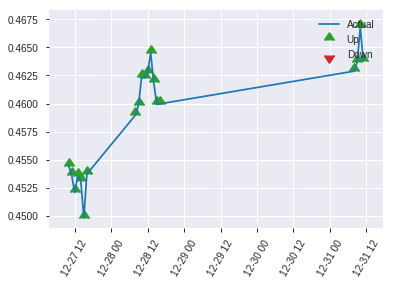


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24993363653706627
RMSE: 0.4999336321323724
LogLoss: 0.6930143423988123
Mean Per-Class Error: 0.44202898550724634
AUC: 0.5342592592592593
pr_auc: 0.5100147791614327
Gini: 0.06851851851851865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4940468760854292: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    112  0.9739   (112.0/115.0)
1      0    108  0        (0.0/108.0)
Total  3    220  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494047     0.658537  180
max f2                       0.494047     0.828221  180
max f0point5                 0.506101     0.551136  153
max accuracy                 0.520823     0.565022  60
max precision                0.539572     0.714286  6
max recall                   0.494047     1         180
max specificity              0.547034     0.991304  0
max absolute_mcc             0.520823     0.129981  60
max min_per_class_accuracy   0.512814     0.444444  93
max mean_per_class_accuracy  0.520823     0.557971  60

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 51.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.542656           0.688272  0.688272           0.333333         0.54529   0.333333                    0.54529             0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.540118           2.06481   1.23889            1                0.54035   0.6                         0.543314            0.0185185       0.0277778                  106.481   23.8889
    3        0.0313901                   0.539471           2.06481   1.47487            1                0.539713  0.714286                    0.542285            0.0185185       0.0462963                  106.481   47.4868
    4        0.0403587                   0.536132           0         1.14712            0                0.538776  0.555556                    0.541505            0               0.0462963                  -100      14.7119
    5        0.0538117                   0.534596           0         0.86034            0                0.535336  0.416667                    0.539963            0               0.0462963                  -100      -13.966
    6        0.103139                    0.531282           1.31397   1.07729            0.636364         0.532735  0.521739                    0.536506            0.0648148       0.111111                   31.3973   7.72947
    7        0.152466                    0.528524           1.31397   1.15387            0.636364         0.530202  0.558824                    0.534466            0.0648148       0.175926                   31.3973   15.3867
    8        0.201794                    0.525496           1.50168   1.23889            0.727273         0.526695  0.6                         0.532567            0.0740741       0.25                       50.1684   23.8889
    9        0.300448                    0.518885           0.938552  1.14027            0.454545         0.522496  0.552239                    0.52926             0.0925926       0.342593                   -6.14478  14.0271
    10       0.399103                    0.513727           0.938552  1.09041            0.454545         0.51576   0.52809                     0.525923            0.0925926       0.435185                   -6.14478  9.04078
    11       0.600897                    0.512753           0.917695  1.03241            0.444444         0.512792  0.5                         0.521513            0.185185        0.62037                    -8.23045  3.24074
    12       0.600897                    0.51275            0         1.03241            0                0         0.5                         0.521513            0               0.62037                    -100      3.24074
    13       0.699552                    0.512368           0.750842  0.992699           0.363636         0.512583  0.480769                    0.520254            0.0740741       0.694444                   -24.9158  -0.730057
    14       0.798206                    0.510793           1.22012   1.02081            0.590909         0.512051  0.494382                    0.51924             0.12037         0.814815                   22.0118   2.08073
    15       0.896861                    0.503046           0.938552  1.01176            0.454545         0.50659   0.49                        0.517849            0.0925926       0.907407                   -6.14478  1.17593
    16       1                           0.48333            0.897746  1                  0.434783         0.499356  0.484305                    0.515941      

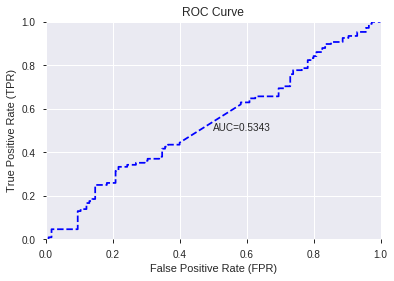

This function is available for GLM models only


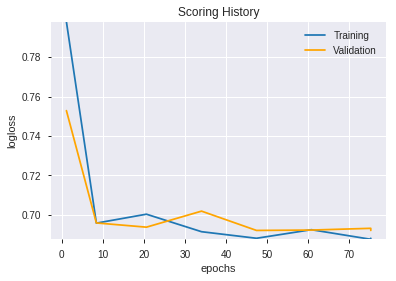

--2019-08-27 20:38:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_203119_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_203119_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['PLUS_DM_24',
 'CDLRICKSHAWMAN',
 'LINEARREG_SLOPE_14',
 'AROONOSC_30',
 'MACD_signal',
 'RSI_12',
 'STDDEV_14',
 'MFI_8',
 'ROCP_20',
 'ROC_20',
 'CDLHANGINGMAN',
 'BBANDS_lowerband_12_3_5',
 'CDLBELTHOLD',
 'T3_8_7',
 'LINEARREG_14',
 'BBANDS_upperband_24_2_4',
 'MIDPRICE_8',
 'BBANDS_lowerband_8_2_5',
 'BBANDS_upperband_8_3_3',
 'BBANDS_middleband_14_7_5',
 'BBANDS_upperband_14_6_5',
 'BBANDS_upperband_30_2_3',
 'MA_30_5',
 'BBANDS_upperband_24_2_2',
 'MIDPOINT_12',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_24_1_2',
 'BBANDS_lowerband_20_5_2',
 'MAVP_14_0',
 'Open',
 'MA_24_1',
 'BBANDS_lowerband_20_5_5',
 'LINEARREG_INTERCEPT_14',
 'CDLTASUKIGAP',
 'TEMA_8',
 'BBANDS_middleband_8_0_3',
 'BBANDS_lowerband_30_5_5',
 'MAVP_20_0',
 'BBANDS_middleband_12_7_2',
 'BBANDS_lowerband_24_0_4',
 'BBANDS_middleband_12_6_3',
 'TAN',
 'BBANDS_upperband_14_6_4',
 'KAMA_8',
 'BBANDS_upperband_14_5_5',
 'BBANDS_lowerband_14_3_2',
 'MAX_12',
 'MA_8_0',
 'BBANDS_middleband_14_5_5',
 'BBANDS_midd

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_203808_model_1  0.542754  0.691935              0.486957  0.499395  0.249395

variable  relative_importance  scaled_importance  percentage
0             CDLRICKSHAWMAN             0.035679           1.000000    0.106173
1                MACD_signal             0.029317           0.821677    0.087240
2                     RSI_12             0.026777           0.750485    0.079681
3              CDLHANGINGMAN             0.022335           0.625989    0.066463
4                AROONOSC_30             0.020618           0.577874    0.061355
5               CDLTASUKIGAP             0.020277           0.568316    0.060340
6                 PLUS_DM_24             0.019794           0.554786    0.058903
7         LINEARREG_SLOPE_14             0.018811           0.527226    0.055977
8                  STDDEV_14             0.018018           0.505000    0.053618
9                CDLBELTHOLD             0.015656           0.438785    0.046587
10                     MFI_8             0.008339           0.233716    0.024814
11   BBANDS_upperband_24_2_4             0.007646           0.214284    0.022751
12   BBANDS_lowerband_24_0_4             0.006046           0.169449    0.017991
13                    ROC_20             0.005679           0.159171    0.016900
14                   ROCP_20             0.005642           0.158144    0.016791
15   BBANDS_upperband_24_1_2             0.005455           0.152900    0.016234
16   BBANDS_upperband_30_2_3             0.005393           0.151145    0.016048
17   BBANDS_lowerband_30_5_5             0.005127           0.143707    0.015258
18                      Open             0.004763           0.133483    0.014172
19   BBANDS_upperband_24_2_2             0.004386           0.122917    0.013050
20   BBANDS_lowerband_12_3_5             0.004129           0.115733    0.012288
21   BBANDS_upperband_14_5_5             0.004031           0.112979    0.011995
22   BBANDS_lowerband_20_5_5             0.004008           0.112322    0.011926
23   BBANDS_upperband_14_6_5             0.004004           0.112209    0.011914
24   BBANDS_upperband_14_6_4             0.003326           0.093227    0.009898
25   BBANDS_lowerband_14_3_2             0.002895           0.081136    0.008614
26    LINEARREG_INTERCEPT_14             0.002649           0.074255    0.007884
27                   MA_30_5             0.002321           0.065038    0.006905
28                 MAVP_14_0             0.002154           0.060369    0.006410
29  BBANDS_middleband_24_1_4             0.002072           0.058071    0.006166
30                 MAVP_20_0             0.002039           0.057159    0.006069
31                   MA_24_1             0.001996           0.055953    0.005941
32                    KAMA_8             0.001667           0.046728    0.004961
33    BBANDS_upperband_8_3_3             0.001545           0.043315    0.004599
34   BBANDS_lowerband_12_0_3             0.001502           0.042101    0.004470
35              LINEARREG_14             0.001499           0.042005    0.004460
36                    TEMA_8             0.001441           0.040391    0.004288
37               MIDPOINT_12             0.001023           0.028678    0.003045
38                    MAX_12             0.000861           0.024142    0.002563
39  BBANDS_middleband_12_7_2             0.000818           0.022922    0.002434
40  BBANDS_middleband_14_7_5             0.000667           0.018704    0.001986
41  BBANDS_middleband_14_5_5             0.000598           0.016756    0.001779
42   BBANDS_lowerband_20_5_2             0.000583           0.016352    0.001736
43  BBANDS_middleband_12_6_3             0.000564           0.015801    0.001678
44    BBANDS_lowerband_8_2_5             0.000466           0.013074    0.001388
45                       TAN             0.000315           0.008823    0.000937
46                    MA_8_0             0.000308           0.008637    0.000917
47   BBANDS_middleband_8_0_3             0.000308           0.008624    0.000916
48                    T3_8_7             0.000280  

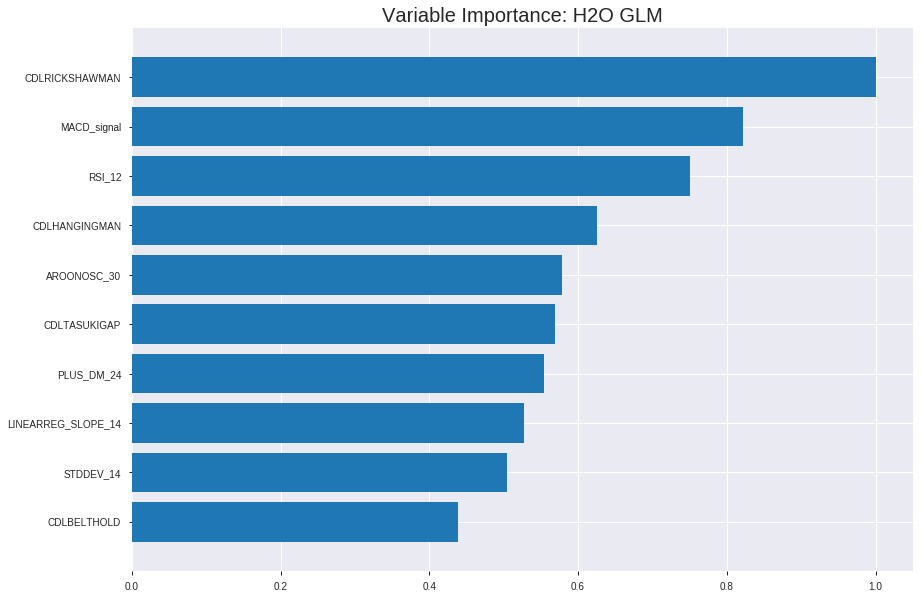

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_203808_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2472656657329169
RMSE: 0.4972581479804196
LogLoss: 0.6876463009702415
Null degrees of freedom: 1556
Residual degrees of freedom: 1506
Null deviance: 2153.817678601273
Residual deviance: 2141.330581221332
AIC: 2243.330581221332
AUC: 0.5553283707567653
pr_auc: 0.5707618862923597
Gini: 0.11065674151353067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4265359552218894: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    735   0.9986   (735.0/736.0)
1      0    821   0        (0.0/821.0)
Total  1    1556  0.4721   (735.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.426536     0.690787   398
max f2                       0.426536     0.84814    398
max f0point5                 0.482155     0.589516   325
max accuracy                 0.52632      0.548491   198
max precision                0.738533     1          0
max recall                   0.426536     1          398
max specificity              0.738533     1          0
max absolute_mcc             0.555477     0.0954372  85
max min_per_class_accuracy   0.532217     0.533967   178
max mean_per_class_accuracy  0.52632      0.545066   198

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102762                   0.5879             0.948234  0.948234           0.5              0.604489  0.5                         0.604489            0.00974421      0.00974421                 -5.17661   -5.17661
    2        0.0205523                   0.581371           1.18529   1.06676            0.625            0.583733  0.5625                      0.594111            0.0121803       0.0219245                  18.5292    6.67631
    3        0.0301863                   0.577239           1.26431   1.12981            0.666667         0.57954   0.595745                    0.589461            0.0121803       0.0341048                  26.4312    12.9811
    4        0.0404624                   0.57322            1.42235   1.20411            0.75             0.574531  0.634921                    0.585669            0.0146163       0.0487211                  42.2351    20.4106
    5        0.0500963                   0.569926           1.13788   1.19137            0.6              0.571231  0.628205                    0.582892            0.0109622       0.0596833                  13.7881    19.1371
    6        0.100193                    0.561706           1.14274   1.16706            0.602564         0.565779  0.615385                    0.574336            0.0572473       0.116931                   14.2743    16.7057
    7        0.150289                    0.557513           1.04549   1.12653            0.551282         0.559429  0.594017                    0.569367            0.0523752       0.169306                   4.54886    12.6534
    8        0.200385                    0.553778           1.16706   1.13666            0.615385         0.555618  0.599359                    0.56593             0.0584653       0.227771                   16.7057    13.6665
    9        0.299936                    0.546681           1.06447   1.1127             0.56129          0.550341  0.586724                    0.560755            0.105968        0.333739                   6.4469     11.2703
    10       0.400128                    0.540065           0.984704  1.08065            0.519231         0.543417  0.569823                    0.556414            0.0986602       0.4324                     -1.52956   8.06518
    11       0.500321                    0.532316           0.996861  1.06387            0.525641         0.536189  0.560976                    0.552364            0.0998782       0.532278                   -0.313876  6.38721
    12       0.599872                    0.523267           1.05223   1.06194            0.554839         0.527736  0.559957                    0.548277            0.10475         0.637028                   5.22337    6.19407
    13       0.700064                    0.514585           0.899606  1.03871            0.474359         0.518811  0.547706                    0.544059            0.090134        0.727162                   -10.0394   3.87076
    14       0.799615                    0.501145           0.978822  1.03125            0.516129         0.508319  0.543775                    0.53961             0.0974421       0.824604                   -2.11779   3.12519
    15       0.899807                    0.482074           0.984704  1.02607            0.519231         0.492421  0.541042                    0.534355            0.0986602       0.923264                   -1.52956   2.60689
    16       1                           0.41959            0.765881  1                  0.403846         0.463898  0.527296                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2502573143390804
RMSE: 0.5002572481624633
LogLoss: 0.6936503507139846
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 620.0871872338774
Residual deviance: 617.3488121354463
AIC: 719.3488121354463
AUC: 0.5270967350406603
pr_auc: 0.5024043001737207
Gini: 0.054193470081320694
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44707198847391505: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    227  0.9827   (227.0/231.0)
1      0    214  0        (0.0/214.0)
Total  4    441  0.5101   (227.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.447072     0.653435   395
max f2                       0.447072     0.824981   395
max f0point5                 0.501634     0.544489   288
max accuracy                 0.550021     0.541573   61
max precision                0.566942     0.666667   11
max recall                   0.447072     1          395
max specificity              0.588829     0.995671   0
max absolute_mcc             0.447072     0.0916667  395
max min_per_class_accuracy   0.525742     0.514019   193
max mean_per_class_accuracy  0.501634     0.539022   288

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 51.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.576885           0.831776  0.831776           0.4              0.583836  0.4                         0.583836            0.00934579      0.00934579                 -16.8224   -16.8224
    2        0.0202247                   0.570751           1.55958   1.15524            0.75             0.573362  0.555556                    0.579181            0.0140187       0.0233645                  55.9579    15.5244
    3        0.0314607                   0.562142           1.24766   1.18825            0.6              0.56701   0.571429                    0.574834            0.0140187       0.0373832                  24.7664    18.8251
    4        0.0404494                   0.560605           1.55958   1.27077            0.75             0.561426  0.611111                    0.571855            0.0140187       0.0514019                  55.9579    27.0768
    5        0.0516854                   0.558598           0.831776  1.17534            0.4              0.559586  0.565217                    0.569188            0.00934579      0.0607477                  -16.8224   17.5335
    6        0.101124                    0.553952           0.85068   1.01661            0.409091         0.555696  0.488889                    0.562592            0.0420561       0.102804                   -14.932    1.66147
    7        0.150562                    0.549916           1.51232   1.17938            0.727273         0.552031  0.567164                    0.559124            0.0747664       0.17757                    51.2319    17.9383
    8        0.2                         0.546986           0.85068   1.09813            0.409091         0.548528  0.52809                     0.556505            0.0420561       0.219626                   -14.932    9.81308
    9        0.301124                    0.542497           0.970405  1.05524            0.466667         0.54466   0.507463                    0.552527            0.0981308       0.317757                   -2.9595    5.52378
    10       0.4                         0.534826           0.99246   1.03972            0.477273         0.538341  0.5                         0.54902             0.0981308       0.415888                   -0.754036  3.97196
    11       0.501124                    0.525643           0.970405  1.02573            0.466667         0.530222  0.493274                    0.545227            0.0981308       0.514019                   -2.9595    2.57324
    12       0.6                         0.513023           1.13424   1.04361            0.545455         0.52048   0.501873                    0.541149            0.11215         0.626168                   13.424     4.36137
    13       0.698876                    0.504403           0.9452    1.02969            0.454545         0.508986  0.495177                    0.536599            0.0934579       0.719626                   -5.48003   2.96902
    14       0.8                         0.492166           0.877985  1.01051            0.422222         0.498329  0.485955                    0.531761            0.088785        0.808411                   -12.2015   1.0514
    15       0.898876                    0.473628           1.03972   1.01373            0.5              0.483911  0.4875                      0.526498            0.102804        0.911215                   3.97196    1.37266
    16       1                           0.348498           0.877985  1                  0.422222         0.456256  0.480899                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:38:08  0.000 sec   2            3.5       51            1.38026           1.39076
    2019-08-27 20:38:08  0.021 sec   4            2.2       51            1.37927           1.3899
    2019-08-27 20:38:08  0.048 sec   6            1.4       51            1.37822           1.38903
    2019-08-27 20:38:08  0.064 sec   8            0.85      51            1.37718           1.38823
    2019-08-27 20:38:08  0.081 sec   10           0.53      51            1.37619           1.38762
    2019-08-27 20:38:09  0.096 sec   12           0.33      51            1.37529           1.3873
    2019-08-27 20:38:09  0.123 sec   14           0.2       51            1.37449           1.38736
    2019-08-27 20:38:09  0.156 sec   16           0.13      51            1.37378           1.38786
    2019-08-27 20:38:09  0.172 sec   17           0.078     51            1.37317           1.38882
    2019-08-27 20:38:09  0.187 sec   18           0.049     51            1.37265           1.39011
    2019-08-27 20:38:09  0.204 sec   19           0.03      51            1.3722            1.3916

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6585365853658536)

('auc', 0.5427536231884058)

('logloss', 0.6919354514279229)

('mean_per_class_error', 0.4423107890499195)

('rmse', 0.49939473524212313)

('mse', 0.24939510158755024)

glm prediction progress: |████████████████████████████████████████████████| 100%


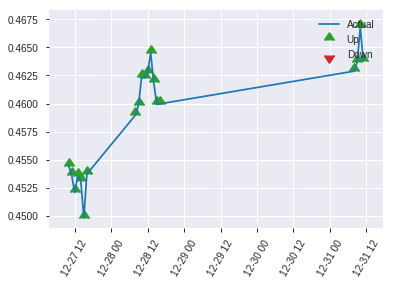


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24939510158755024
RMSE: 0.49939473524212313
LogLoss: 0.6919354514279229
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 310.57429368859675
Residual deviance: 308.60321133685363
AIC: 410.60321133685363
AUC: 0.5427536231884058
pr_auc: 0.5166361349732345
Gini: 0.08550724637681162
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4414353927748351: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    112  0.9739   (112.0/115.0)
1      0    108  0        (0.0/108.0)
Total  3    220  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441435     0.658537  219
max f2                       0.441435     0.828221  219
max f0point5                 0.466775     0.548643  193
max accuracy                 0.541842     0.565022  58
max precision                0.579093     0.666667  5
max recall                   0.441435     1         219
max specificity              0.592084     0.991304  0
max absolute_mcc             0.541842     0.130719  58
max min_per_class_accuracy   0.518434     0.530435  111
max mean_per_class_accuracy  0.541842     0.557689  58

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 51.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.585398           0.688272  0.688272           0.333333         0.588659  0.333333                    0.588659            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.579507           2.06481   1.23889            1                0.581005  0.6                         0.585598            0.0185185       0.0277778                  106.481   23.8889
    3        0.0313901                   0.57676            1.03241   1.17989            0.5              0.578765  0.571429                    0.583645            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.574971           1.03241   1.14712            0.5              0.575652  0.555556                    0.581869            0.00925926      0.0462963                  3.24074   14.7119
    5        0.0538117                   0.570159           0.688272  1.03241            0.333333         0.572466  0.5                         0.579518            0.00925926      0.0555556                  -31.1728  3.24074
    6        0.103139                    0.559929           1.31397   1.16707            0.636364         0.563375  0.565217                    0.571797            0.0648148       0.12037                    31.3973   16.7069
    7        0.152466                    0.552409           0.750842  1.03241            0.363636         0.556044  0.5                         0.566701            0.037037        0.157407                   -24.9158  3.24074
    8        0.201794                    0.547321           1.31397   1.10123            0.636364         0.549382  0.533333                    0.562467            0.0648148       0.222222                   31.3973   10.1235
    9        0.300448                    0.539947           1.31397   1.17109            0.636364         0.54293   0.567164                    0.556052            0.12963         0.351852                   31.3973   17.1089
    10       0.399103                    0.530077           0.938552  1.11361            0.454545         0.534697  0.539326                    0.550773            0.0925926       0.444444                   -6.14478  11.3608
    11       0.502242                    0.518434           0.897746  1.06928            0.434783         0.524844  0.517857                    0.545448            0.0925926       0.537037                   -10.2254  6.92791
    12       0.600897                    0.509226           0.750842  1.017              0.363636         0.512745  0.492537                    0.540079            0.0740741       0.611111                   -24.9158  1.69983
    13       0.699552                    0.500595           1.12626   1.03241            0.545455         0.504571  0.5                         0.535072            0.111111        0.722222                   12.6263   3.24074
    14       0.798206                    0.479625           0.844697  1.00921            0.409091         0.49021   0.488764                    0.529527            0.0833333       0.805556                   -15.5303  0.920724
    15       0.896861                    0.460896           1.12626   1.02208            0.545455         0.470947  0.495                       0.523083            0.111111        0.916667                   12.6263   2.20833
    16       1                           0.424872           0.807971  1                  0.391304         0.451072  0.484305                    0.515656       

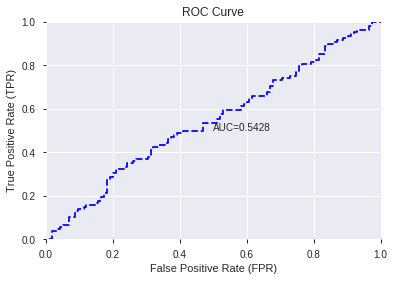

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


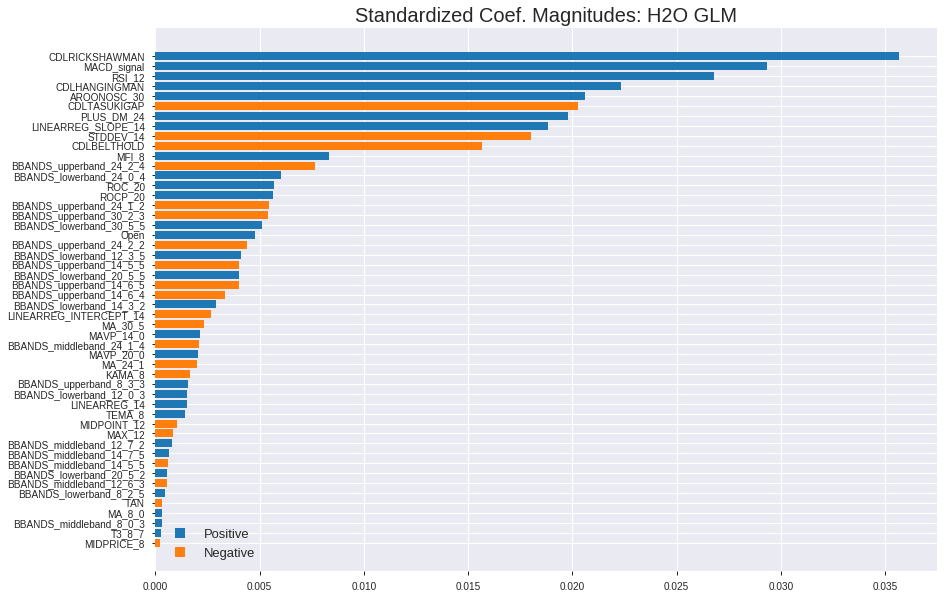

'log_likelihood'
--2019-08-27 20:38:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_203808_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_203808_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLRICKSHAWMAN',
 'MACD_signal',
 'RSI_12',
 'CDLHANGINGMAN',
 'AROONOSC_30',
 'CDLTASUKIGAP',
 'PLUS_DM_24',
 'LINEARREG_SLOPE_14',
 'STDDEV_14',
 'CDLBELTHOLD',
 'MFI_8',
 'BBANDS_upperband_24_2_4',
 'BBANDS_lowerband_24_0_4',
 'ROC_20',
 'ROCP_20',
 'BBANDS_upperband_24_1_2',
 'BBANDS_upperband_30_2_3',
 'BBANDS_lowerband_30_5_5',
 'Open',
 'BBANDS_upperband_24_2_2',
 'BBANDS_lowerband_12_3_5',
 'BBANDS_upperband_14_5_5',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_upperband_14_6_5',
 'BBANDS_upperband_14_6_4',
 'BBANDS_lowerband_14_3_2',
 'LINEARREG_INTERCEPT_14',
 'MA_30_5',
 'MAVP_14_0',
 'BBANDS_middleband_24_1_4',
 'MAVP_20_0',
 'MA_24_1',
 'KAMA_8',
 'BBANDS_upperband_8_3_3',
 'BBANDS_lowerband_12_0_3',
 'LINEARREG_14',
 'TEMA_8',
 'MIDPOINT_12',
 'MAX_12',
 'BBANDS_middleband_12_7_2',
 'BBANDS_middleband_14_7_5',
 'BBANDS_middleband_14_5_5',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_8_2_5',
 'TAN',
 'MA_8_0',
 'BBANDS_middleband_8_0_3',
 'T3_8_7',

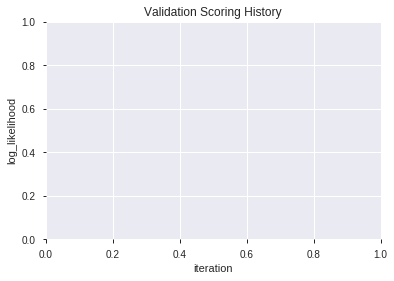

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_203820  0.506280  0.712747              0.450081  0.509124  0.259207
1  XGBoost_grid_1_AutoML_20190827_203820_model_4  0.500523  0.701151              0.479106  0.503890  0.253905
2  XGBoost_grid_1_AutoML_20190827_203820_model_3  0.492271  0.709712              0.474477  0.507955  0.258018
3  XGBoost_grid_1_AutoML_20190827_203820_model_2  0.488768  0.706528              0.478261  0.506368  0.256408
4               XGBoost_2_AutoML_20190827_203820  0.463164  0.729490              0.469847  0.517207  0.267503
5  XGBoost_grid_1_AutoML_20190827_203820_model_6  0.463043  0.721778              0.495652  0.513559  0.263743
6               XGBoost_1_AutoML_20190827_203820  0.462158  0.737700              0.483454  0.520212  0.270621
7  XGBoost_grid_1_AutoML_20190827_203820_model_5  0.460789  0.765413              0.495652  0.530886  0.281840
8  XGBoost_grid_1_AutoML_20190827_203820_model_1  0.451369  0.718006              0.474758  0.511908  0.262050
9  XGBoost_grid_1_AutoML_20190827_203820_model_7  0.426570  0.740543              0.469847  0.521840  0.272317

variable  relative_importance  scaled_importance  percentage
0                      MFI_8           368.189941           1.000000    0.109308
1                 PLUS_DM_24           231.621353           0.629081    0.068764
2                     RSI_12           226.763962           0.615889    0.067322
3                  STDDEV_14           198.007690           0.537787    0.058784
4         LINEARREG_SLOPE_14           186.016434           0.505219    0.055224
5                MACD_signal           167.076675           0.453778    0.049602
6                     ROC_20           153.645111           0.417299    0.045614
7    BBANDS_upperband_14_5_5           106.457130           0.289136    0.031605
8     LINEARREG_INTERCEPT_14           103.053894           0.279893    0.030595
9    BBANDS_upperband_24_2_4           101.413254           0.275437    0.030108
10   BBANDS_lowerband_20_5_5            96.572128           0.262289    0.028670
11   BBANDS_lowerband_20_5_2            94.951965           0.257889    0.028189
12   BBANDS_lowerband_30_5_5            85.189224           0.231373    0.025291
13   BBANDS_lowerband_12_3_5            85.008820           0.230883    0.025237
14                      Open            82.396622           0.223788    0.024462
15   BBANDS_upperband_30_2_3            76.397560           0.207495    0.022681
16                       TAN            69.672585           0.189230    0.020684
17               AROONOSC_30            67.353683           0.182932    0.019996
18                    KAMA_8            58.285461           0.158303    0.017304
19   BBANDS_upperband_14_6_5            57.726360           0.156784    0.017138
20    BBANDS_upperband_8_3_3            56.810566           0.154297    0.016866
21   BBANDS_lowerband_24_0_4            51.113480           0.138824    0.015175
22    BBANDS_lowerband_8_2_5            47.974743           0.130299    0.014243
23                MIDPRICE_8            46.803555           0.127118    0.013895
24                 MAVP_14_0            44.008137           0.119526    0.013065
25   BBANDS_lowerband_14_3_2            43.224499           0.117397    0.012832
26   BBANDS_upperband_14_6_4            41.776348           0.113464    0.012403
27   BBANDS_lowerband_12_0_3            41.437817           0.112545    0.012302
28                   MA_30_5            41.105618           0.111642    0.012203
29   BBANDS_upperband_24_2_2            40.678501           0.110482    0.012077
30                   MA_24_1            36.431576           0.098948    0.010816
31                   ROCP_20            36.182888           0.098272    0.010742
32  BBANDS_middleband_14_5_5            34.177780           0.092826    0.010147
33   BBANDS_upperband_24_1_2            29.974215           0.081410    0.008899
34  BBANDS_middleband_12_6_3            29.361776           0.079746    0.008717
35                    TEMA_8            23.944788           0.065034    0.007109
36                    MAX_12            23.236843           0.063111    0.006899
37              LINEARREG_14            19.624582           0.053300    0.005826
38                    T3_8_7            17.721519           0.048131    0.005261
39               MIDPOINT_12            15.768541           0.042827    0.004681
40            CDLRICKSHAWMAN             9.951530           0.027028    0.002954
41                 MAVP_20_0             8.264655           0.022447    0.002454
42                    MA_8_0             7.935080           0.021552    0.002356
43               CDLBELTHOLD             2.656998           0.007216    0.000789
44   BBANDS_middleband_8_0_3             1.428488           0.003880    0.000424
45  BBANDS_middleband_24_1_4             0.975121           0.002648    0.000289

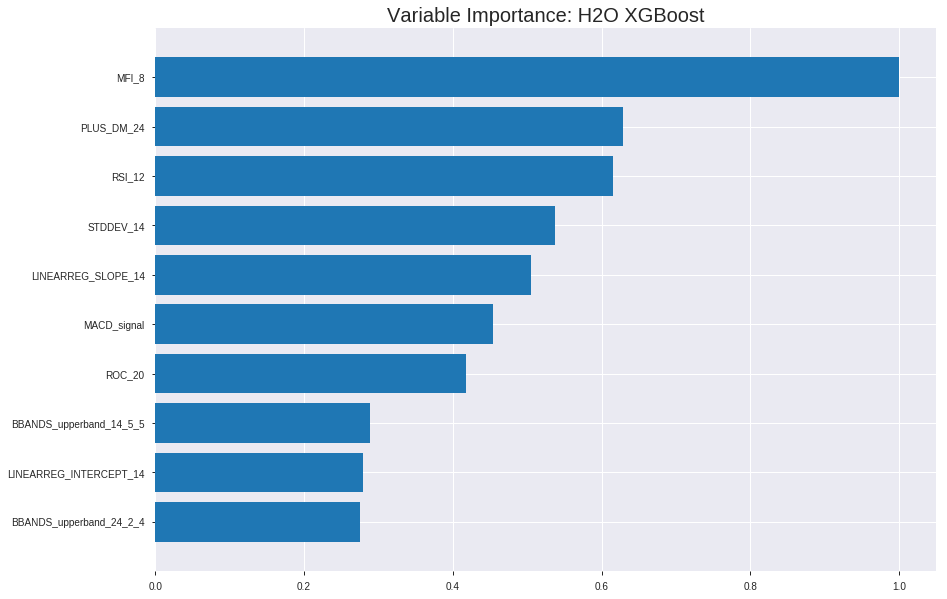

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_203820


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19991618679230808
RMSE: 0.4471198796657425
LogLoss: 0.5904555521005428
Mean Per-Class Error: 0.21665568897950538
AUC: 0.859696055976275
pr_auc: 0.8651637913429273
Gini: 0.7193921119525499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49746353427569073: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      474  262  0.356    (262.0/736.0)
1      94   727  0.1145   (94.0/821.0)
Total  568  989  0.2286   (356.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497464     0.803315  231
max f2                       0.431572     0.880158  299
max f0point5                 0.559648     0.803968  159
max accuracy                 0.525659     0.7842    198
max precision                0.776708     1         0
max recall                   0.331889     1         377
max specificity              0.776708     1         0
max absolute_mcc             0.525659     0.566945  198
max min_per_class_accuracy   0.529787     0.779891  193
max mean_per_class_accuracy  0.525659     0.783344  198

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 52.59 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.713799           1.89647    1.89647            1                0.733991  1                           0.733991            0.0194884       0.0194884                  89.6468   89.6468
    2        0.0205523                   0.697052           1.77794    1.8372             0.9375           0.702807  0.96875                     0.718399            0.0182704       0.0377588                  77.7938   83.7203
    3        0.0301863                   0.686853           1.89647    1.85612            1                0.691925  0.978723                    0.70995             0.0182704       0.0560292                  89.6468   85.6117
    4        0.0404624                   0.680624           1.77794    1.83626            0.9375           0.684054  0.968254                    0.703373            0.0182704       0.0742996                  77.7938   83.6262
    5        0.0500963                   0.670508           1.89647    1.84784            1                0.67444   0.974359                    0.697809            0.0182704       0.09257                    89.6468   84.784
    6        0.100193                    0.644511           1.82353    1.83568            0.961538         0.655664  0.967949                    0.676736            0.091352        0.183922                   82.3527   83.5684
    7        0.150289                    0.624381           1.65333    1.7749             0.871795         0.634431  0.935897                    0.662635            0.0828258       0.266748                   65.3331   77.4899
    8        0.200385                    0.610246           1.67764    1.75059            0.884615         0.617489  0.923077                    0.651348            0.0840438       0.350792                   67.7645   75.0586
    9        0.299936                    0.584731           1.56612    1.68936            0.825806         0.597388  0.890792                    0.633439            0.155907        0.506699                   56.6115   68.9359
    10       0.400128                    0.562097           1.41019    1.61946            0.74359          0.574052  0.853933                    0.618568            0.141291        0.64799                    41.0194   61.9456
    11       0.500321                    0.534671           1.16706    1.52886            0.615385         0.547939  0.806162                    0.604424            0.116931        0.764921                   16.7057   52.886
    12       0.599872                    0.506019           0.856469   1.41727            0.451613         0.519944  0.747323                    0.590404            0.0852619       0.850183                   -14.3531  41.7275
    13       0.700064                    0.476429           0.753724   1.32231            0.397436         0.491663  0.697248                    0.576272            0.0755177       0.9257                     -24.6276  32.2308
    14       0.799615                    0.438339           0.415999   1.20947            0.219355         0.458267  0.637751                    0.561581            0.0414129       0.967113                   -58.4001  20.9474
    15       0.899807                    0.391005           0.267451   1.10458            0.141026         0.415138  0.582441                    0.545275            0.0267966       0.99391                    -73.2549  10.4581
    16       1                           0.217498           0.0607842  1                  0.0320513        0.35219   0.527296                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2674319230928847
RMSE: 0.5171382050215249
LogLoss: 0.7291873832001344
Mean Per-Class Error: 0.48797386414208843
AUC: 0.4650645304850912
pr_auc: 0.4655046719394705
Gini: -0.06987093902981756
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31902021169662476: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    214  0        (0.0/214.0)
Total  0    445  0.5191   (231.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.31902      0.649469   399
max f2                       0.31902      0.822444   399
max f0point5                 0.31902      0.53661    399
max accuracy                 0.698001     0.530337   6
max precision                0.745071     1          0
max recall                   0.31902      1          399
max specificity              0.745071     1          0
max absolute_mcc             0.353806     0.0989486  395
max min_per_class_accuracy   0.559948     0.476636   199
max mean_per_class_accuracy  0.695246     0.512026   8

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 54.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.700412           1.66355   1.66355            0.8              0.715137  0.8                         0.715137            0.0186916       0.0186916                  66.3551   66.3551
    2        0.0202247                   0.690966           1.55958   1.61734            0.75             0.697055  0.777778                    0.707101            0.0140187       0.0327103                  55.9579   61.7342
    3        0.0314607                   0.681711           0         1.03972            0                0.685255  0.5                         0.699299            0               0.0327103                  -100      3.97196
    4        0.0404494                   0.680028           1.55958   1.15524            0.75             0.68081   0.555556                    0.69519             0.0140187       0.046729                   55.9579   15.5244
    5        0.0516854                   0.674009           0.831776  1.08492            0.4              0.67623   0.521739                    0.691068            0.00934579      0.0560748                  -16.8224  8.49248
    6        0.101124                    0.652374           0.85068   0.970405           0.409091         0.662325  0.466667                    0.677016            0.0420561       0.0981308                  -14.932   -2.9595
    7        0.150562                    0.637886           0.9452    0.962129           0.454545         0.644135  0.462687                    0.666219            0.046729        0.14486                    -5.48003  -3.78714
    8        0.2                         0.626422           0.4726    0.841121           0.227273         0.632859  0.404494                    0.657973            0.0233645       0.168224                   -52.74    -15.8879
    9        0.301124                    0.60738            1.06282   0.915574           0.511111         0.615791  0.440299                    0.643807            0.107477        0.275701                   6.28245   -8.4426
    10       0.4                         0.585415           0.9452    0.922897           0.454545         0.59493   0.44382                     0.631725            0.0934579       0.369159                   -5.48003  -7.71028
    11       0.501124                    0.559581           1.06282   0.951134           0.511111         0.572023  0.457399                    0.619678            0.107477        0.476636                   6.28245   -4.88664
    12       0.6                         0.532635           1.13424   0.981308           0.545455         0.545408  0.47191                     0.607439            0.11215         0.588785                   13.424    -1.86916
    13       0.698876                    0.496737           0.9452    0.9762             0.454545         0.515369  0.469453                    0.594413            0.0934579       0.682243                   -5.48003  -2.38002
    14       0.8                         0.451437           0.924195  0.969626           0.444444         0.477173  0.466292                    0.579593            0.0934579       0.775701                   -7.58048  -3.03738
    15       0.898876                    0.409536           1.08698   0.982535           0.522727         0.431357  0.4725                      0.563287            0.107477        0.883178                   8.69796   -1.7465
    16       1                           0.31902            1.15524   1                  0.555556         0.381087  0.480899                    0.544862  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:38:24  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.472704                         0.5                0.693147              0.5               0                    1                  0.519101
    2019-08-27 20:38:24  0.140 sec   5                  0.491833         0.676925            0.735448        0.748076           1.79111          0.339114                         0.50097            0.695088              0.486598          0.484872             1.24766            0.516854
    2019-08-27 20:38:24  0.208 sec   10                 0.485142         0.663761            0.762181        0.781831           1.89647          0.346821                         0.503259           0.699701              0.479589          0.485251             1.66355            0.516854
    2019-08-27 20:38:24  0.272 sec   15                 0.479442         0.65262             0.779225        0.799594           1.89647          0.316635                         0.504312           0.701844              0.474147          0.475349             1.66355            0.516854
    2019-08-27 20:38:24  0.333 sec   20                 0.474431         0.64284             0.791573        0.808751           1.89647          0.304432                         0.506301           0.705922              0.469657          0.474356             1.66355            0.519101
    2019-08-27 20:38:24  0.395 sec   25                 0.468687         0.631715            0.808057        0.819738           1.89647          0.285806                         0.508657           0.710817              0.468918          0.468672             1.66355            0.519101
    2019-08-27 20:38:24  0.457 sec   30                 0.46417          0.623               0.819545        0.827152           1.89647          0.274888                         0.509733           0.713063              0.469616          0.471091             1.66355            0.519101
    2019-08-27 20:38:24  0.517 sec   35                 0.460087         0.615136            0.828888        0.836194           1.89647          0.257547                         0.510545           0.714835              0.472367          0.476603             1.24766            0.519101
    2019-08-27 20:38:24  0.591 sec   40                 0.454497         0.604512            0.845426        0.852537           1.89647          0.23571                          0.513311           0.720831              0.469555          0.466225             1.24766            0.519101
    2019-08-27 20:38:24  0.654 sec   45                 0.450476         0.596797            0.852476        0.859579           1.89647          0.240848                         0.516135           0.726978              0.465408          0.463231             1.24766            0.519101
    2019-08-27 20:38:24  0.716 sec   50                 0.44712          0.590456            0.859696        0.865164           1.89647          0.228645                         0.517138           0.729187              0.465065          0.465505             1.66355            0.519101

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ---------------------
MFI_8                     368.18994140625        1.0                    0.10930806187995748
PLUS_DM_24                231.62135314941406     0.6290811537783153     0.06876364168471513
RSI_12                    226.7639617919922      0.615888530050275      0.06732158155389151
STDDEV_14                 198.0076904296875      0.5377868001320862     0.0587844328270624
LINEARREG_SLOPE_14        186.0164337158203      0.5052186732895433     0.05522447400284342
---                       ---                    ---                    ---
MAVP_20_0                 8.264655113220215      0.022446716174957197   0.002453607040654064
MA_8_0                    7.935079574584961      0.02155159248587301    0.0023557628050574334
CDLBELTHOLD               2.6569976806640625     0.007216377694936563   0.0007888082596272707
BBANDS_middleband_8_0_3   1.4284883737564087     0.0038797593663218964  0.0004240889768932585
BBANDS_middleband_24_1_4  0.9751205444335938     0.0026484171205472294  0.0002894933424967154


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5381165919282511)

('F1', 0.66006600660066)

('auc', 0.5062801932367149)

('logloss', 0.7127465190776957)

('mean_per_class_error', 0.4500805152979066)

('rmse', 0.5091241630414753)

('mse', 0.2592074133926827)

xgboost prediction progress: |████████████████████████████████████████████| 100%


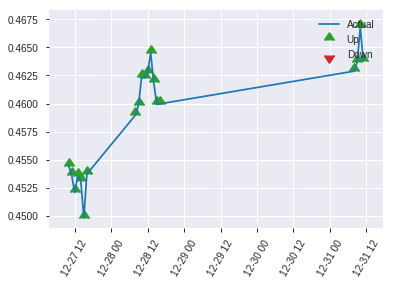


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2592074133926827
RMSE: 0.5091241630414753
LogLoss: 0.7127465190776957
Mean Per-Class Error: 0.4500805152979066
AUC: 0.5062801932367149
pr_auc: 0.47669302728573604
Gini: 0.01256038647342983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4781217575073242: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   95   0.8261   (95.0/115.0)
1      8    100  0.0741   (8.0/108.0)
Total  28   195  0.4619   (103.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478122     0.660066  194
max f2                       0.381002     0.825688  220
max f0point5                 0.478122     0.563063  194
max accuracy                 0.481481     0.538117  192
max precision                0.748712     1         0
max recall                   0.381002     1         220
max specificity              0.748712     1         0
max absolute_mcc             0.478122     0.150579  194
max min_per_class_accuracy   0.565319     0.490741  107
max mean_per_class_accuracy  0.478122     0.549919  194

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 55.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.740833           0.688272  0.688272           0.333333         0.74552   0.333333                    0.74552             0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.726302           0         0.412963           0                0.732097  0.2                         0.740151            0               0.00925926                 -100      -58.7037
    3        0.0313901                   0.708068           2.06481   0.884921           1                0.716309  0.428571                    0.733339            0.0185185       0.0277778                  106.481   -11.5079
    4        0.0403587                   0.704482           1.03241   0.917695           0.5              0.706131  0.444444                    0.727292            0.00925926      0.037037                   3.24074   -8.23045
    5        0.0538117                   0.695714           1.37654   1.03241            0.666667         0.699985  0.5                         0.720465            0.0185185       0.0555556                  37.6543   3.24074
    6        0.103139                    0.635705           0.750842  0.897746           0.363636         0.654467  0.434783                    0.688901            0.037037        0.0925926                  -24.9158  -10.2254
    7        0.152466                    0.617831           1.31397   1.03241            0.636364         0.626294  0.5                         0.668646            0.0648148       0.157407                   31.3973   3.24074
    8        0.201794                    0.609016           1.12626   1.05535            0.545455         0.612956  0.511111                    0.655033            0.0555556       0.212963                   12.6263   5.53498
    9        0.300448                    0.592878           0.750842  0.955362           0.363636         0.600027  0.462687                    0.636971            0.0740741       0.287037                   -24.9158  -4.46379
    10       0.399103                    0.579731           1.12626   0.997607           0.545455         0.587003  0.483146                    0.624619            0.111111        0.398148                   12.6263   -0.239284
    11       0.502242                    0.560725           0.897746  0.9771             0.434783         0.570092  0.473214                    0.613422            0.0925926       0.490741                   -10.2254  -2.29001
    12       0.600897                    0.544357           1.31397   1.03241            0.636364         0.55271   0.5                         0.603454            0.12963         0.62037                    31.3973   3.24074
    13       0.699552                    0.529732           0.844697  1.00594            0.409091         0.536926  0.487179                    0.594072            0.0833333       0.703704                   -15.5303  0.593542
    14       0.798206                    0.504252           0.938552  0.997607           0.454545         0.51834   0.483146                    0.584712            0.0925926       0.796296                   -6.14478  -0.239284
    15       0.896861                    0.468747           1.40783   1.04273            0.681818         0.486882  0.505                       0.573951            0.138889        0.935185                   40.7828   4.27315
    16       1                           0.359149           0.628422  1                  0.304348         0.424482  0.484305                    0.558

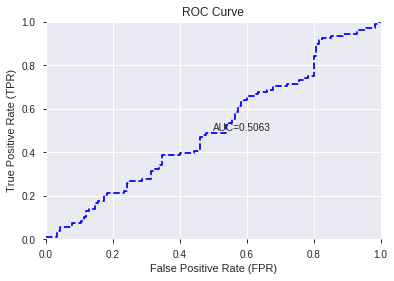

This function is available for GLM models only


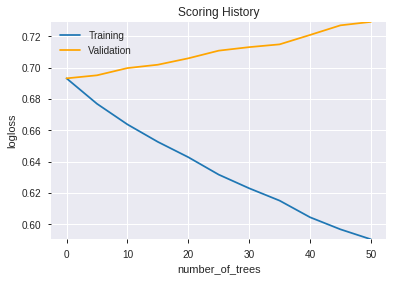

--2019-08-27 20:38:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_203820',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_203820',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_a5c4',
   'type

['MFI_8',
 'PLUS_DM_24',
 'RSI_12',
 'STDDEV_14',
 'LINEARREG_SLOPE_14',
 'MACD_signal',
 'ROC_20',
 'BBANDS_upperband_14_5_5',
 'LINEARREG_INTERCEPT_14',
 'BBANDS_upperband_24_2_4',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_lowerband_30_5_5',
 'BBANDS_lowerband_12_3_5',
 'Open',
 'BBANDS_upperband_30_2_3',
 'TAN',
 'AROONOSC_30',
 'KAMA_8',
 'BBANDS_upperband_14_6_5',
 'BBANDS_upperband_8_3_3',
 'BBANDS_lowerband_24_0_4',
 'BBANDS_lowerband_8_2_5',
 'MIDPRICE_8',
 'MAVP_14_0',
 'BBANDS_lowerband_14_3_2',
 'BBANDS_upperband_14_6_4',
 'BBANDS_lowerband_12_0_3',
 'MA_30_5',
 'BBANDS_upperband_24_2_2',
 'MA_24_1',
 'ROCP_20',
 'BBANDS_middleband_14_5_5',
 'BBANDS_upperband_24_1_2',
 'BBANDS_middleband_12_6_3',
 'TEMA_8',
 'MAX_12',
 'LINEARREG_14',
 'T3_8_7',
 'MIDPOINT_12',
 'CDLRICKSHAWMAN',
 'MAVP_20_0',
 'MA_8_0',
 'CDLBELTHOLD',
 'BBANDS_middleband_8_0_3',
 'BBANDS_middleband_24_1_4']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 928] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_203848_model_7  0.503704  0.769034              0.491304  0.533097  0.284192
1  DeepLearning_grid_1_AutoML_20190827_203848_model_1  0.503140  5.915955              0.495652  0.691304  0.477901
2  DeepLearning_grid_1_AutoML_20190827_203848_model_8  0.501288  0.692675              0.500000  0.499764  0.249764
3  DeepLearning_grid_1_AutoML_20190827_203848_model_9  0.500000  0.692821              0.500000  0.499837  0.249837
4  DeepLearning_grid_1_AutoML_20190827_203848_model_5  0.500000  0.692860              0.500000  0.499856  0.249856
5  DeepLearning_grid_1_AutoML_20190827_203848_model_6  0.491063  0.693046              0.495652  0.499949  0.249949
6  DeepLearning_grid_1_AutoML_20190827_203848_model_2  0.484863  0.840500              0.500000  0.554038  0.306959
7               DeepLearning_1_AutoML_20190827_203848  0.476369  1.037712              0.495652  0.564378  0.318522
8  DeepLearning_grid_1_AutoML_20190827_203848_model_3  0.470531  0.835032              0.495652  0.556766  0.309988
9  DeepLearning_grid_1_AutoML_20190827_203848_model_4  0.445894  1.538494              0.500000  0.650487  0.423133

variable  relative_importance  scaled_importance  percentage
0     BBANDS_lowerband_20_5_2             1.000000           1.000000    0.001035
1     BBANDS_lowerband_12_0_3             0.996766           0.996766    0.001032
2                 CDLBELTHOLD             0.995246           0.995246    0.001030
3                LINEARREG_14             0.991575           0.991575    0.001026
4          LINEARREG_SLOPE_14             0.988905           0.988905    0.001023
...                       ...                  ...                ...         ...
1033  BBANDS_upperband_12_5_2             0.869131           0.869131    0.000899
1034  BBANDS_lowerband_12_6_3             0.868791           0.868791    0.000899
1035                    DX_24             0.868338           0.868338    0.000899
1036                     SINH             0.857812           0.857812    0.000888
1037   BBANDS_lowerband_8_6_5             0.856621           0.856621    0.000887

[1038 rows x 4 columns]

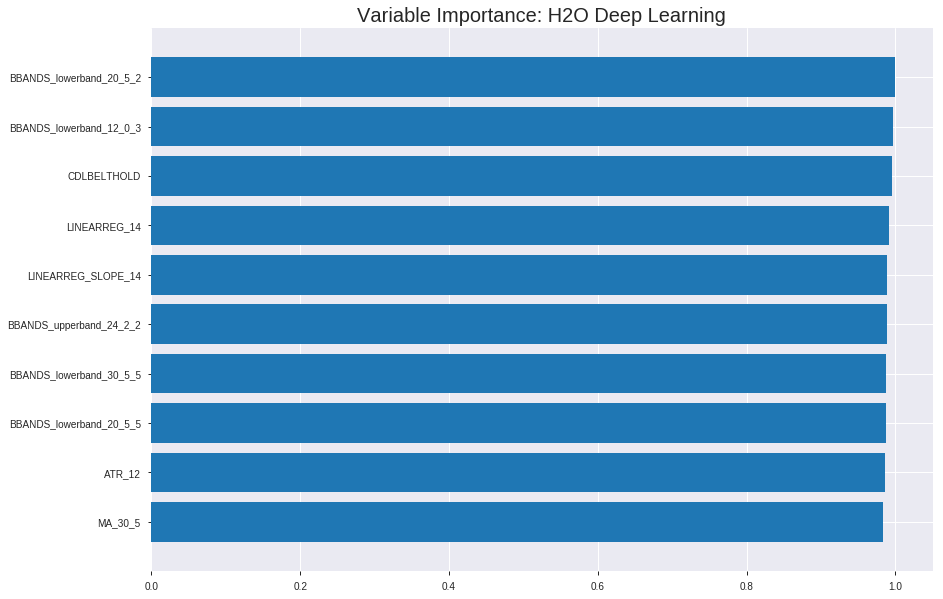

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_203848_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2581988898424665
RMSE: 0.5081327482483947
LogLoss: 0.713910685839386
Mean Per-Class Error: 0.46072194566541325
AUC: 0.5549485648466874
pr_auc: 0.6054620406626867
Gini: 0.10989712969337484
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09123008579320825: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      10   726   0.9864   (726.0/736.0)
1      2    819   0.0024   (2.0/821.0)
Total  12   1545  0.4676   (728.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0912301    0.692308  388
max f2                       0.0611305    0.848491  397
max f0point5                 0.337349     0.592552  282
max accuracy                 0.345448     0.551702  280
max precision                0.965414     1         0
max recall                   0.0611305    1         397
max specificity              0.965414     1         0
max absolute_mcc             0.692211     0.117945  32
max min_per_class_accuracy   0.648448     0.524457  67
max mean_per_class_accuracy  0.633431     0.539278  95

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 57.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102762                   0.793411           1.77794   1.77794            0.9375           0.882388  0.9375                      0.882388            0.0182704       0.0182704                  77.7938    77.7938
    2        0.0205523                   0.701007           1.42235   1.60014            0.75             0.735674  0.84375                     0.809031            0.0146163       0.0328867                  42.2351    60.0145
    3        0.0301863                   0.681733           1.51717   1.57366            0.8              0.693792  0.829787                    0.772253            0.0146163       0.047503                   51.7174    57.3665
    4        0.0404624                   0.665799           1.30382   1.50513            0.6875           0.673555  0.793651                    0.747187            0.0133983       0.0609013                  30.3822    50.5133
    5        0.0500963                   0.659405           1.26431   1.45882            0.666667         0.662315  0.769231                    0.730865            0.0121803       0.0730816                  26.4312    45.8821
    6        0.504817                    0.648449           1.02056   1.06405            0.538136         0.648777  0.561069                    0.656923            0.464068        0.53715                    2.05568    6.40487
    7        0.599872                    0.635402           1.02512   1.05788            0.540541         0.642191  0.557816                    0.654588            0.0974421       0.634592                   2.51177    5.78797
    8        0.700064                    0.599522           0.92392   1.03871            0.487179         0.621158  0.547706                    0.649804            0.09257         0.727162                   -7.60798   3.87076
    9        0.799615                    0.511573           0.991057  1.03278            0.522581         0.562086  0.544578                    0.638883            0.0986602       0.825822                   -0.894267  3.27752
    10       0.899807                    0.288106           0.984704  1.02742            0.519231         0.417647  0.541756                    0.614249            0.0986602       0.924482                   -1.52956   2.74226
    11       1                           0.0323028          0.753724  1                  0.397436         0.180153  0.527296                    0.570756            0.0755177       1                          -24.6276   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2845883733359298
RMSE: 0.5334682496043507
LogLoss: 0.781521459873859
Mean Per-Class Error: 0.4693935348140956
AUC: 0.5084759477282842
pr_auc: 0.481280864751894
Gini: 0.01695189545656839
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32078795619399714: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   218  0.9437   (218.0/231.0)
1      5    209  0.0234   (5.0/214.0)
Total  18   427  0.5011   (223.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.320788     0.652106   360
max f2                       0.191469     0.822444   378
max f0point5                 0.523805     0.545198   322
max accuracy                 0.964147     0.523596   1
max precision                0.968466     1          0
max recall                   0.191469     1          378
max specificity              0.968466     1          0
max absolute_mcc             0.320788     0.0834689  360
max min_per_class_accuracy   0.635076     0.493506   156
max mean_per_class_accuracy  0.583123     0.530606   289

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 63.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.931174           1.24766   1.24766            0.6              0.952209  0.6                         0.952209            0.0140187       0.0140187                  24.7664    24.7664
    2        0.0202247                   0.904144           0.51986   0.924195           0.25             0.915998  0.444444                    0.936115            0.0046729       0.0186916                  -48.014    -7.58048
    3        0.0314607                   0.885184           1.24766   1.03972            0.6              0.893612  0.5                         0.920936            0.0140187       0.0327103                  24.7664    3.97196
    4        0.0404494                   0.874433           1.03972   1.03972            0.5              0.878256  0.5                         0.911451            0.00934579      0.0420561                  3.97196    3.97196
    5        0.0516854                   0.862175           0.831776  0.994514           0.4              0.868126  0.478261                    0.902033            0.00934579      0.0514019                  -16.8224   -0.548557
    6        0.101124                    0.802878           1.03972   1.01661            0.5              0.830984  0.488889                    0.867298            0.0514019       0.102804                   3.97196    1.66147
    7        0.150562                    0.758842           0.9452    0.993165           0.454545         0.773918  0.477612                    0.836636            0.046729        0.149533                   -5.48003   -0.683498
    8        0.2                         0.697115           0.85068   0.957944           0.409091         0.727689  0.460674                    0.809705            0.0420561       0.191589                   -14.932    -4.20561
    9        0.404494                    0.648449           1.02829   0.99351            0.494505         0.653706  0.477778                    0.730839            0.21028         0.401869                   2.82941    -0.649013
    10       0.501124                    0.635076           0.967181  0.988433           0.465116         0.642402  0.475336                    0.713786            0.0934579       0.495327                   -3.2819    -1.1567
    11       0.6                         0.624824           1.1815    1.02025            0.568182         0.629843  0.490637                    0.699953            0.116822        0.61215                    18.15      2.02492
    12       0.698876                    0.607897           0.99246   1.01632            0.477273         0.618027  0.488746                    0.688362            0.0981308       0.71028                    -0.754036  1.63176
    13       0.8                         0.583049           1.20145   1.03972            0.577778         0.597565  0.5                         0.676885            0.121495        0.831776                   20.1454    3.97196
    14       0.898876                    0.493353           0.85068   1.01893            0.409091         0.547653  0.49                        0.662669            0.0841121       0.915888                   -14.932    1.89252
    15       1                           0.191469           0.831776  1                  0.4              0.342555  0.480899                    0.630298            0.0841121       1                          -16.8224   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:49:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:49:44  8.146 sec         88 obs/sec        0.256262  1             399        0.726027         6.46444             -1.11477       0.503138        0.537779           1.18529          0.472704                         0.693351           5.85868               -0.925751        0.487549          0.481337             0.831776           0.503371
    2019-08-27 20:50:18  41.284 sec        173 obs/sec       3.88825   15            6054       0.508133         0.713911            -0.0358828     0.554949        0.605462           1.77794          0.467566                         0.533468           0.781521              -0.140017        0.508476          0.481281             1.24766            0.501124
    2019-08-27 20:50:45  1 min  7.922 sec  213 obs/sec       8.08092   31            12582      0.554858         0.865958            -0.235151      0.549503        0.610618           1.65941          0.470777                         0.571752           1.15709               -0.309511        0.472519          0.483114             1.66355            0.516854
    2019-08-27 20:51:11  1 min 34.362 sec  234 obs/sec       12.5061   48            19472      0.504889         0.701168            -0.0226991     0.5951          0.661282           1.89647          0.440591                         0.579603           1.39929               -0.345723        0.491989          0.477038             1.24766            0.505618
    2019-08-27 20:51:38  2 min  1.231 sec  247 obs/sec       17.018    65            26497      0.5151           0.770703            -0.064486      0.593529        0.668423           1.89647          0.432884                         0.61016            1.71644               -0.491356        0.492252          0.474968             1.24766            0.51236
    2019-08-27 20:52:04  2 min 27.662 sec  258 obs/sec       21.7964   83            33937      0.477532         0.641987            0.0851265      0.647289        0.709376           1.89647          0.414258                         0.582234           1.66042               -0.357966        0.497097          0.47133              0.831776           0.492135
    2019-08-27 20:52:30  2 min 53.744 sec  264 obs/sec       26.2383   100           40853      0.479044         0.655605            0.0793236      0.634883        0.685681           1.89647          0.416827                         0.599651           2.09208               -0.440426        0.492697          0.457252             0.415888           0.514607
    2019-08-27 20:52:33  2 min 56.432 sec  264 obs/sec       26.2383   100           40853      0.508133         0.713911            -0.0358828     0.554949        0.605462           1.77794          0.467566                         0.533468           0.781521              -0.140017        0.508476          0.481281             1.24766            0.501124

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BBANDS_lowerband_20_5_2  1.0                    1.0                  0.001034909580128065
BBANDS_lowerband_12_0_3  0.9967659711837769     0.9967659711837769   0.0010315626527237455
CDLBELTHOLD              0.995245635509491      0.995245635509491    0.0010299892427694166
LINEARREG_14             0.9915751218795776     0.9915751218795776   0.0010261905930498286
LINEARREG_SLOPE_14       0.9889047145843506     0.9889047145843506   0.0010234269629571544
---                      ---                    ---                  ---
BBANDS_upperband_12_5_2  0.8691309094429016     0.8691309094429016   0.0008994719045678767
BBANDS_lowerband_12_6_3  0.8687912821769714     0.8687912821769714   0.0008991204210566928
DX_24                    0.8683376908302307     0.8683376908302307   0.0008986509950264876
SINH                     0.8578115701675415     0.8578115701675415   0.0008877574119110866
BBANDS_lowerband_8_6_5   0.8566211462020874     0.8566211462020874   0.0008865254307448241


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5246636771300448)

('F1', 0.6565349544072948)

('auc', 0.5037037037037037)

('logloss', 0.7690335350792548)

('mean_per_class_error', 0.46509661835748795)

('rmse', 0.5330970602289629)

('mse', 0.2841924756247624)

deeplearning prediction progress: |███████████████████████████████████████| 100%


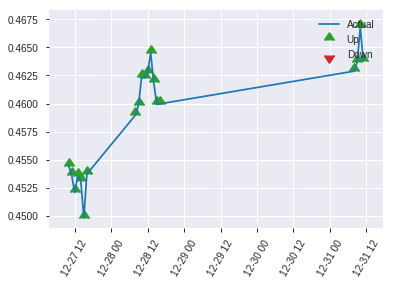


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2841924756247624
RMSE: 0.5330970602289629
LogLoss: 0.7690335350792548
Mean Per-Class Error: 0.46509661835748795
AUC: 0.5037037037037037
pr_auc: 0.46855952072483353
Gini: 0.007407407407407307
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5714481893400372: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    113  0.9826   (113.0/115.0)
1      0    108  0        (0.0/108.0)
Total  2    221  0.5067   (113.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.571448     0.656535  146
max f2                       0.571448     0.826953  146
max f0point5                 0.647581     0.550948  109
max accuracy                 0.647581     0.524664  109
max precision                0.647581     0.505435  109
max recall                   0.571448     1         146
max specificity              0.880767     0.991304  0
max absolute_mcc             0.696366     0.122456  17
max min_per_class_accuracy   0.648729     0.453704  96
max mean_per_class_accuracy  0.647581     0.534903  109

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 65.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.830935           0.688272  0.688272           0.333333         0.854262  0.333333                    0.854262            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.820138           1.03241   0.825926           0.5              0.824151  0.4                         0.842217            0.00925926      0.0185185                  3.24074   -17.4074
    3        0.0313901                   0.816318           1.03241   0.884921           0.5              0.818842  0.428571                    0.835539            0.00925926      0.0277778                  3.24074   -11.5079
    4        0.0403587                   0.769576           0         0.688272           0                0.79319   0.333333                    0.826128            0               0.0277778                  -100      -31.1728
    5        0.0538117                   0.739518           0.688272  0.688272           0.333333         0.755793  0.333333                    0.808544            0.00925926      0.037037                   -31.1728  -31.1728
    6        0.103139                    0.679275           0.938552  0.807971           0.454545         0.701075  0.391304                    0.757146            0.0462963       0.0833333                  -6.14478  -19.2029
    7        0.152466                    0.663835           1.12626   0.910948           0.545455         0.670141  0.441176                    0.728997            0.0555556       0.138889                   12.6263   -8.90523
    8        0.201794                    0.657515           1.12626   0.96358            0.545455         0.660675  0.466667                    0.712296            0.0555556       0.194444                   12.6263   -3.64198
    9        0.300448                    0.650519           0.844697  0.924544           0.409091         0.65281   0.447761                    0.692763            0.0833333       0.277778                   -15.5303  -7.54561
    10       0.399103                    0.649129           1.22012   0.997607           0.590909         0.649795  0.483146                    0.682142            0.12037         0.398148                   22.0118   -0.239284
    11       0.780269                    0.648449           1.04455   1.02054            0.505882         0.648495  0.494253                    0.665705            0.398148        0.796296                   4.45534   2.05407
    12       0.798206                    0.648385           1.54861   1.03241            0.75             0.648431  0.5                         0.665317            0.0277778       0.824074                   54.8611   3.24074
    13       0.896861                    0.643075           0.844697  1.01176            0.409091         0.646224  0.49                        0.663217            0.0833333       0.907407                   -15.5303  1.17593
    14       1                           0.513193           0.897746  1                  0.434783         0.621538  0.484305                    0.658918            0.0925926       1                          -10.2254  0

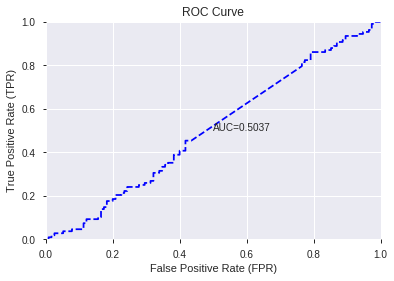

This function is available for GLM models only


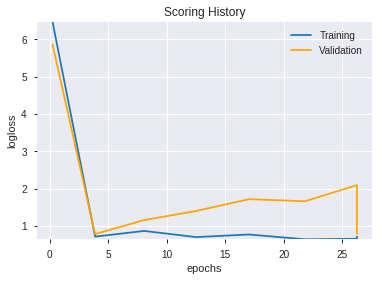

--2019-08-27 21:00:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.0
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.0|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_203848_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_203848_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BBANDS_lowerband_20_5_2',
 'BBANDS_lowerband_12_0_3',
 'CDLBELTHOLD',
 'LINEARREG_14',
 'LINEARREG_SLOPE_14',
 'BBANDS_upperband_24_2_2',
 'BBANDS_lowerband_30_5_5',
 'BBANDS_lowerband_20_5_5',
 'ATR_12',
 'MA_30_5',
 'BBANDS_upperband_14_6_5',
 'MAVP_12_5',
 'RSI_12',
 'Open',
 'BBANDS_lowerband_8_2_5',
 'MIDPOINT_12',
 'ROCP_20',
 'TAN',
 'BBANDS_upperband_8_3_3',
 'BBANDS_middleband_12_4_4',
 'BBANDS_middleband_8_8_3',
 'BBANDS_middleband_24_1_4',
 'BBANDS_middleband_12_6_3',
 'LINEARREG_SLOPE_8',
 'T3_8_7',
 'MIDPOINT_20',
 'CMO_8',
 'BBANDS_upperband_14_5_5',
 'BBANDS_middleband_8_0_3',
 'MACDFIX_hist_14',
 'BBANDS_lowerband_12_3_5',
 'aroonup_30',
 'CDLRICKSHAWMAN',
 'ADX_12',
 'MA_8_0',
 'CDLTASUKIGAP',
 'SUB',
 'BETA_20',
 'CORREL_24',
 'BBANDS_lowerband_14_3_2',
 'AROONOSC_30',
 'BBANDS_upperband_30_2_3',
 'MINMAX_max_24',
 'BBANDS_lowerband_24_1_5',
 'BBANDS_lowerband_12_0_5',
 'PLUS_DM_24',
 'MAVP_20_0',
 'BBANDS_upperband_24_2_4',
 'T3_8_0',
 'LINEARREG_SLOPE_24',
 'BBAND

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_210024_model_1  0.570692  0.689323              0.483172  0.498099  0.248103

variable  relative_importance  scaled_importance    percentage
0                  CDLLONGLINE         6.632087e-03           1.000000  1.296510e-02
1                          BOP         6.299911e-03           0.949914  1.231573e-02
2                  CDL3OUTSIDE         6.199123e-03           0.934717  1.211870e-02
3               CDL3LINESTRIKE         4.887953e-03           0.737016  9.555487e-03
4           CDLEVENINGDOJISTAR         4.858876e-03           0.732631  9.498644e-03
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_12_2_3         4.273354e-08           0.000006  8.354003e-08
1034   BBANDS_middleband_8_8_2         0.000000e+00           0.000000  0.000000e+00
1035   BBANDS_middleband_8_8_3         0.000000e+00           0.000000  0.000000e+00
1036   BBANDS_middleband_8_8_4         0.000000e+00           0.000000  0.000000e+00
1037   BBANDS_middleband_8_8_5         0.000000e+00           0.000000  0.000000e+00

[1038 rows x 4 columns]

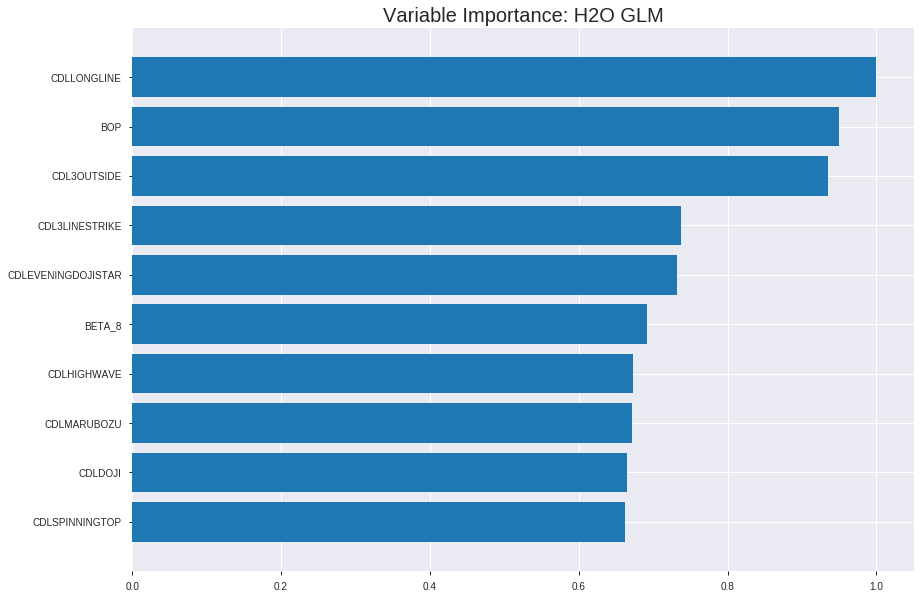

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_210024_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2458904389276922
RMSE: 0.4958734101841842
LogLoss: 0.6848984294434566
Null degrees of freedom: 1556
Residual degrees of freedom: 522
Null deviance: 2153.817678601273
Residual deviance: 2132.773709286924
AIC: 4202.773709286924
AUC: 0.5777162328549489
pr_auc: 0.5888638980947009
Gini: 0.15543246570989777
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4194155279632681: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    733   0.9959   (733.0/736.0)
1      1    820   0.0012   (1.0/821.0)
Total  4    1553  0.4714   (734.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419416     0.690817  395
max f2                       0.400049     0.84814   398
max f0point5                 0.497338     0.599588  274
max accuracy                 0.500242     0.566474  268
max precision                0.591508     1         0
max recall                   0.400049     1         398
max specificity              0.591508     1         0
max absolute_mcc             0.497338     0.125846  274
max min_per_class_accuracy   0.535343     0.55163   163
max mean_per_class_accuracy  0.5297       0.559847  182

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.580836           1.18529   1.18529            0.625            0.585042  0.625                       0.585042            0.0121803       0.0121803                  18.5292   18.5292
    2        0.0205523                   0.576162           1.30382   1.24456            0.6875           0.578024  0.65625                     0.581533            0.0133983       0.0255786                  30.3822   24.4557
    3        0.0301863                   0.57351            1.39074   1.29121            0.733333         0.574714  0.680851                    0.579357            0.0133983       0.0389769                  39.0743   29.1212
    4        0.0404624                   0.5718             0.948234  1.20411            0.5              0.572593  0.634921                    0.577639            0.00974421      0.0487211                  -5.17661  20.4106
    5        0.0500963                   0.570325           1.13788   1.19137            0.6              0.57108   0.628205                    0.576378            0.0109622       0.0596833                  13.7881   19.1371
    6        0.100193                    0.565133           1.26431   1.22784            0.666667         0.567649  0.647436                    0.572014            0.0633374       0.123021                   26.4312   22.7841
    7        0.150289                    0.560879           1.0698    1.17516            0.564103         0.563077  0.619658                    0.569035            0.0535932       0.176614                   6.98023   17.5162
    8        0.200385                    0.556957           1.24      1.19137            0.653846         0.558943  0.628205                    0.566512            0.0621194       0.238733                   23.9998   19.1371
    9        0.299936                    0.549615           1.05223   1.14519            0.554839         0.553473  0.603854                    0.562184            0.10475         0.343484                   5.22337   14.519
    10       0.400128                    0.542803           1.02117   1.11414            0.538462         0.546     0.58748                     0.558132            0.102314        0.445798                   2.11749   11.4137
    11       0.500321                    0.535436           1.02117   1.09552            0.538462         0.539141  0.577664                    0.554329            0.102314        0.548112                   2.11749   9.55205
    12       0.599872                    0.525742           1.04      1.08631            0.548387         0.530958  0.572805                    0.55045             0.103532        0.651644                   3.99984   8.63065
    13       0.700064                    0.515476           0.972548  1.07003            0.512821         0.520125  0.56422                     0.54611             0.0974421       0.749086                   -2.74525  7.00254
    14       0.799615                    0.498319           0.966587  1.05715            0.509677         0.507651  0.55743                     0.541322            0.0962241       0.845311                   -3.34132  5.71475
    15       0.899807                    0.477095           0.814509  1.03013            0.429487         0.487765  0.543183                    0.535358            0.0816078       0.926918                   -18.5491  3.01299
    16       1                           0.398711           0.729411  1                  0.384615         0.454889  0.527296                    0.527296          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25175111704629394
RMSE: 0.5017480613278879
LogLoss: 0.6966673829242779
Null degrees of freedom: 444
Residual degrees of freedom: -590
Null deviance: 620.0871872338774
Residual deviance: 620.0339708026073
AIC: 2690.033970802607
AUC: 0.5197637253712021
pr_auc: 0.4929117800884543
Gini: 0.03952745074240416
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4472669238418786: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    229  0.9913   (229.0/231.0)
1      0    214  0        (0.0/214.0)
Total  2    443  0.5146   (229.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.447267     0.651446   397
max f2                       0.447267     0.823711   397
max f0point5                 0.47778      0.542427   368
max accuracy                 0.53767      0.546067   178
max precision                0.565107     0.64       22
max recall                   0.447267     1          397
max specificity              0.581209     0.995671   0
max absolute_mcc             0.537317     0.0887913  181
max min_per_class_accuracy   0.534201     0.536797   196
max mean_per_class_accuracy  0.537317     0.5442     181

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 52.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.575043           0.415888  0.415888           0.2              0.577203  0.2                         0.577203            0.0046729       0.0046729                  -58.4112   -58.4112
    2        0.0202247                   0.571248           1.03972   0.693146           0.5              0.573155  0.333333                    0.575404            0.00934579      0.0140187                  3.97196    -30.6854
    3        0.0314607                   0.569787           2.07944   1.18825            1                0.57059   0.571429                    0.573685            0.0233645       0.0373832                  107.944    18.8251
    4        0.0404494                   0.567348           1.55958   1.27077            0.75             0.568673  0.611111                    0.572571            0.0140187       0.0514019                  55.9579    27.0768
    5        0.0516854                   0.565178           1.24766   1.26575            0.6              0.565777  0.608696                    0.571094            0.0140187       0.0654206                  24.7664    26.5746
    6        0.101124                    0.560328           0.75616   1.01661            0.363636         0.562713  0.488889                    0.566997            0.0373832       0.102804                   -24.384    1.66147
    7        0.150562                    0.5574             0.9452    0.993165           0.454545         0.558662  0.477612                    0.56426             0.046729        0.149533                   -5.48003   -0.683498
    8        0.2                         0.554196           1.13424   1.02804            0.545455         0.555918  0.494382                    0.562198            0.0560748       0.205607                   13.424     2.80374
    9        0.301124                    0.547004           1.06282   1.03972            0.511111         0.550049  0.5                         0.558118            0.107477        0.313084                   6.28245    3.97196
    10       0.4                         0.539729           1.13424   1.06308            0.545455         0.543768  0.511236                    0.554571            0.11215         0.425234                   13.424     6.30841
    11       0.501124                    0.534129           1.10903   1.07236            0.533333         0.537086  0.515695                    0.551043            0.11215         0.537383                   10.9034    7.23566
    12       0.6                         0.525084           0.7089    1.01246            0.340909         0.52985   0.486891                    0.54755             0.0700935       0.607477                   -29.11     1.24611
    13       0.698876                    0.516269           0.99246   1.00963            0.477273         0.520915  0.485531                    0.543782            0.0981308       0.705607                   -0.754036  0.963128
    14       0.8                         0.501913           1.01661   1.01051            0.488889         0.509197  0.485955                    0.53941             0.102804        0.808411                   1.66147    1.0514
    15       0.898876                    0.483534           0.9452    1.00333            0.454545         0.492417  0.4825                      0.534241            0.0934579       0.901869                   -5.48003   0.332944
    16       1                           0.444611           0.970405  1                  0.466667         0.467226  0.480899               


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:00:28  0.000 sec   2            4.1       1035          1.3698            1.39333
    2019-08-27 21:00:30  2.029 sec   4            3         1039          1.36745           1.39499
    2019-08-27 21:00:32  4.069 sec   6            2.2       1039          1.3646            1.39727
    2019-08-27 21:00:34  6.153 sec   8            1.6       1039          1.36122           1.40033
    2019-08-27 21:00:36  8.204 sec   10           1.2       1039          1.35731           1.40444
    2019-08-27 21:00:38  10.346 sec  12           0.84      1039          1.35288           1.40992

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5829596412556054)

('F1', 0.6563467492260062)

('auc', 0.5706924315619968)

('logloss', 0.689322690523321)

('mean_per_class_error', 0.4232286634460547)

('rmse', 0.4980989961869888)

('mse', 0.24810261000248585)

glm prediction progress: |████████████████████████████████████████████████| 100%


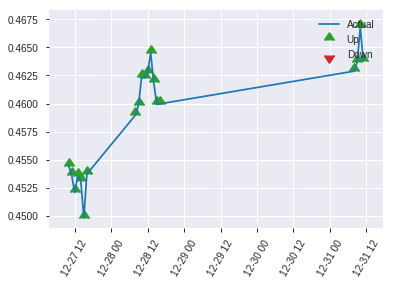


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24810261000248585
RMSE: 0.4980989961869888
LogLoss: 0.689322690523321
Null degrees of freedom: 222
Residual degrees of freedom: -812
Null deviance: 310.57429368859675
Residual deviance: 307.43791997340116
AIC: 2377.437919973401
AUC: 0.5706924315619968
pr_auc: 0.5583575556528149
Gini: 0.14138486312399356
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4491234668797898: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    109  0.9478   (109.0/115.0)
1      2    106  0.0185   (2.0/108.0)
Total  8    215  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449123     0.656347  214
max f2                       0.433863     0.825688  221
max f0point5                 0.483216     0.560976  177
max accuracy                 0.54928      0.58296   66
max precision                0.600327     1         0
max recall                   0.433863     1         221
max specificity              0.600327     1         0
max absolute_mcc             0.54928      0.167375  66
max min_per_class_accuracy   0.530925     0.53913   111
max mean_per_class_accuracy  0.54928      0.576771  66

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 52.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.58963            2.06481   2.06481            1                0.593972  1                           0.593972            0.0277778       0.0277778                  106.481   106.481
    2        0.0224215                   0.583902           1.03241   1.65185            0.5              0.585029  0.8                         0.590394            0.00925926      0.037037                   3.24074   65.1852
    3        0.0313901                   0.583026           1.03241   1.47487            0.5              0.583262  0.714286                    0.588357            0.00925926      0.0462963                  3.24074   47.4868
    4        0.0403587                   0.581798           2.06481   1.60597            1                0.582608  0.777778                    0.587079            0.0185185       0.0648148                  106.481   60.5967
    5        0.0538117                   0.579681           0         1.20448            0                0.580667  0.583333                    0.585476            0               0.0648148                  -100      20.4475
    6        0.103139                    0.571779           1.12626   1.16707            0.545455         0.573989  0.565217                    0.579982            0.0555556       0.12037                    12.6263   16.7069
    7        0.152466                    0.565245           1.31397   1.2146             0.636364         0.567598  0.588235                    0.575976            0.0648148       0.185185                   31.3973   21.4597
    8        0.201794                    0.560693           1.50168   1.28477            0.727273         0.562531  0.622222                    0.572689            0.0740741       0.259259                   50.1684   28.4774
    9        0.300448                    0.549082           1.22012   1.26354            0.590909         0.554735  0.61194                     0.566794            0.12037         0.37963                    22.0118   26.3543
    10       0.399103                    0.539939           0.844697  1.16001            0.409091         0.54482   0.561798                    0.561362            0.0833333       0.462963                   -15.5303  16.0008
    11       0.502242                    0.530925           0.807971  1.08771            0.391304         0.535327  0.526786                    0.556016            0.0833333       0.546296                   -19.2029  8.77149
    12       0.600897                    0.517709           0.656987  1.017              0.318182         0.524407  0.492537                    0.550826            0.0648148       0.611111                   -34.3013  1.69983
    13       0.699552                    0.506016           1.22012   1.04564            0.590909         0.512883  0.50641                     0.545475            0.12037         0.731481                   22.0118   4.56434
    14       0.798206                    0.482749           1.22012   1.06721            0.590909         0.495962  0.516854                    0.539355            0.12037         0.851852                   22.0118   6.72077
    15       0.896861                    0.466449           0.750842  1.03241            0.363636         0.474231  0.5                         0.532192            0.0740741       0.925926                   -24.9158  3.24074
    16       1                           0.429852           0.718196  1                  0.347826         0.453276  0.484305                    0.524052         

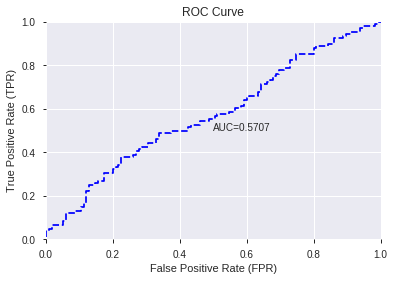

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


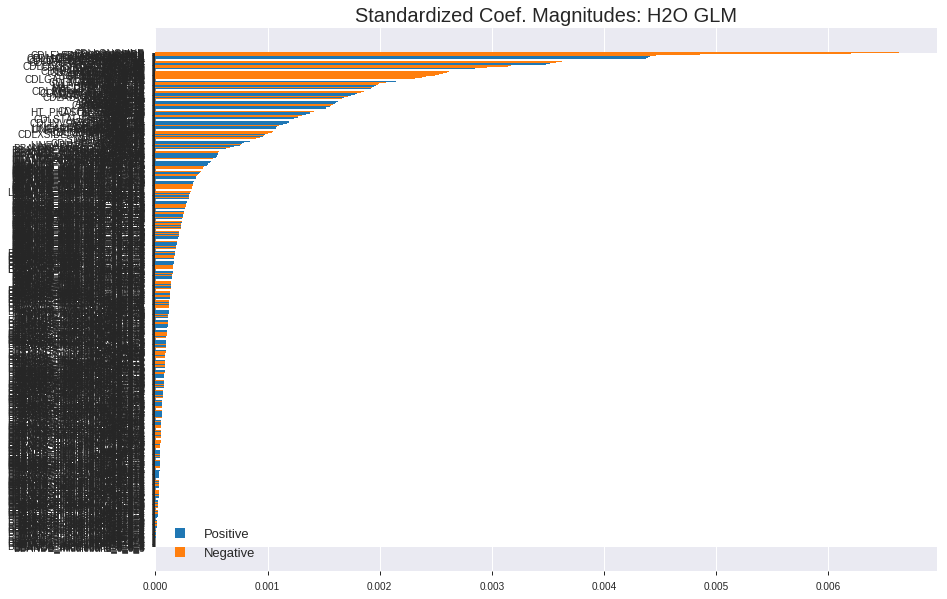

'log_likelihood'
--2019-08-27 21:01:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_210024_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_210024_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLLONGLINE',
 'BOP',
 'CDL3OUTSIDE',
 'CDL3LINESTRIKE',
 'CDLEVENINGDOJISTAR',
 'BETA_8',
 'CDLHIGHWAVE',
 'CDLMARUBOZU',
 'CDLDOJI',
 'CDLSPINNINGTOP',
 'CDLLONGLEGGEDDOJI',
 'CDLMORNINGDOJISTAR',
 'CDLRICKSHAWMAN',
 'BETA_24',
 'CDLDARKCLOUDCOVER',
 'is_month_start',
 'CDLSHORTLINE',
 'aroonup_14',
 'CDLIDENTICAL3CROWS',
 'BETA_12',
 'BETA_14',
 'CORREL_14',
 'ADOSC',
 'AROONOSC_14',
 'CDLHAMMER',
 'day',
 'ADXR_8',
 'ADX_14',
 'CDLCLOSINGMARUBOZU',
 'CDLSTICKSANDWICH',
 'ADX_12',
 'BETA_20',
 'CDLHANGINGMAN',
 'quarter',
 'CCI_14',
 'days_in_month',
 'CDLEVENINGSTAR',
 'CDLLADDERBOTTOM',
 'CDL2CROWS',
 'CDLUNIQUE3RIVER',
 'MINUS_DI_30',
 'SAREXT',
 'ADXR_12',
 'CDLTASUKIGAP',
 'MINUS_DI_24',
 'CDLTHRUSTING',
 'STOCHRSI_fastk',
 'CDLDOJISTAR',
 'MINUS_DI_20',
 'DX_8',
 'OBV',
 'MFI_30',
 'HT_TRENDMODE',
 'ADX_20',
 'CDLGAPSIDESIDEWHITE',
 'PLUS_DI_8',
 'aroondown_14',
 'CCI_12',
 'MINUS_DI_14',
 'PLUS_DI_14',
 'CDLMATCHINGLOW',
 'PLUS_DI_12',
 'PLUS_DI_20',
 'aroondown_8',
 'PLUS_

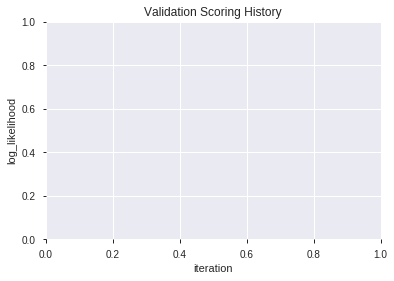

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_210111_model_1  0.556200  0.691812              0.470129  0.499303  0.249303
1  XGBoost_grid_1_AutoML_20190827_210111_model_4  0.543317  0.698968              0.466063  0.502671  0.252678
2               XGBoost_3_AutoML_20190827_210111  0.538647  0.697373              0.458213  0.501993  0.251997
3               XGBoost_2_AutoML_20190827_210111  0.536151  0.715730              0.457649  0.510075  0.260176
4               XGBoost_1_AutoML_20190827_210111  0.525523  0.711923              0.474758  0.508559  0.258632
5  XGBoost_grid_1_AutoML_20190827_210111_model_2  0.524074  0.704480              0.474758  0.505245  0.255272
6  XGBoost_grid_1_AutoML_20190827_210111_model_6  0.518760  0.712602              0.415862  0.508655  0.258730
7  XGBoost_grid_1_AutoML_20190827_210111_model_7  0.506441  0.726103              0.456804  0.514316  0.264521
8  XGBoost_grid_1_AutoML_20190827_210111_model_3  0.492271  0.717005              0.462560  0.511320  0.261448
9  XGBoost_grid_1_AutoML_20190827_210111_model_5  0.489050  0.750325              0.478261  0.524386  0.274980

variable  relative_importance  scaled_importance  percentage
0                        BOP           190.871460           1.000000    0.038398
1               STOCHF_fastk           129.545120           0.678703    0.026061
2                        DIV           104.331726           0.546607    0.020989
3                  STDDEV_24            97.589478           0.511284    0.019633
4                    BETA_12            84.446991           0.442429    0.016989
..                       ...                  ...                ...         ...
221                      day             3.257183           0.017065    0.000655
222   BBANDS_lowerband_8_0_4             2.486435           0.013027    0.000500
223             aroondown_14             2.236111           0.011715    0.000450
224                       AD             1.748842           0.009162    0.000352
225  BBANDS_lowerband_30_1_5             1.641588           0.008600    0.000330

[226 rows x 4 columns]

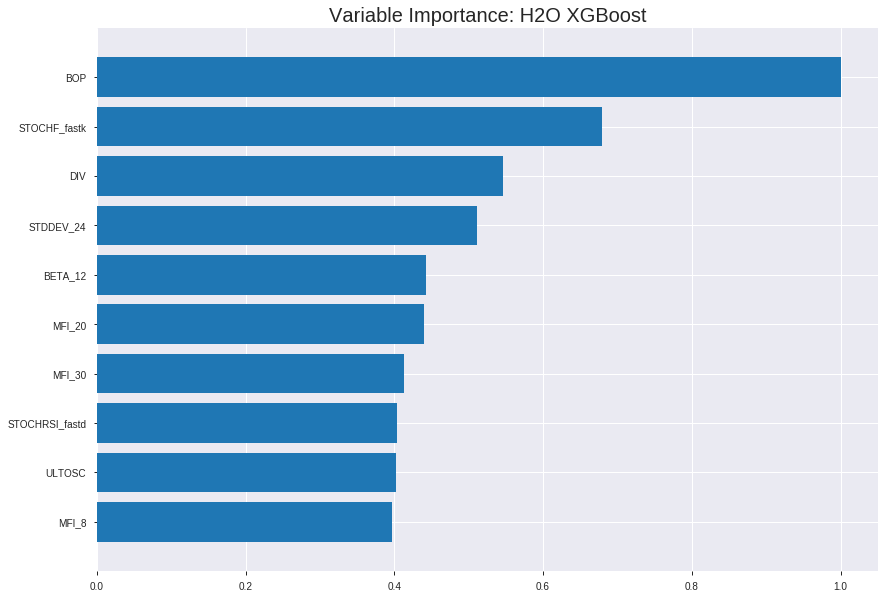

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_210111_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17417124604324846
RMSE: 0.4173382872961076
LogLoss: 0.5362617969967852
Mean Per-Class Error: 0.12035627283800243
AUC: 0.9494237541704179
pr_auc: 0.9554214377194932
Gini: 0.8988475083408358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5235942006111145: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      644  92   0.125    (92.0/736.0)
1      95   726  0.1157   (95.0/821.0)
Total  739  818  0.1201   (187.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.523594     0.885906  199
max f2                       0.463325     0.917431  251
max f0point5                 0.56085      0.904397  166
max accuracy                 0.523594     0.879897  199
max precision                0.84896      1         0
max recall                   0.391879     1         313
max specificity              0.84896      1         0
max absolute_mcc             0.523594     0.759133  199
max min_per_class_accuracy   0.525665     0.877717  197
max mean_per_class_accuracy  0.523594     0.879644  199

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 52.51 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0109184                   0.759853           1.89647    1.89647            1                0.785945  1                           0.785945            0.0207065       0.0207065                  89.6468   89.6468
    2        0.0205523                   0.744486           1.89647    1.89647            1                0.751976  1                           0.770022            0.0182704       0.0389769                  89.6468   89.6468
    3        0.0301863                   0.731985           1.89647    1.89647            1                0.73808   1                           0.759828            0.0182704       0.0572473                  89.6468   89.6468
    4        0.0404624                   0.722977           1.89647    1.89647            1                0.727296  1                           0.751566            0.0194884       0.0767357                  89.6468   89.6468
    5        0.0500963                   0.707955           1.89647    1.89647            1                0.715429  1                           0.744616            0.0182704       0.0950061                  89.6468   89.6468
    6        0.100193                    0.674854           1.89647    1.89647            1                0.691637  1                           0.718127            0.0950061       0.190012                   89.6468   89.6468
    7        0.150289                    0.652923           1.87215    1.88836            0.987179         0.663085  0.995726                    0.699779            0.0937881       0.2838                     87.2154   88.8363
    8        0.200385                    0.633727           1.87215    1.88431            0.987179         0.643569  0.99359                     0.685727            0.0937881       0.377588                   87.2154   88.4311
    9        0.299936                    0.598003           1.83529    1.86804            0.967742         0.614699  0.985011                    0.662152            0.182704        0.560292                   83.5291   86.8041
    10       0.400128                    0.565767           1.66549    1.81732            0.878205         0.581824  0.958266                    0.642038            0.16687         0.727162                   66.5488   81.7321
    11       0.500321                    0.532265           1.28863    1.71145            0.679487         0.547153  0.902439                    0.623037            0.129111        0.856273                   28.8626   71.1446
    12       0.599872                    0.495414           0.783058   1.55738            0.412903         0.512491  0.821199                    0.604691            0.0779537       0.934227                   -21.6942  55.7378
    13       0.700064                    0.459245           0.413333   1.39364            0.217949         0.477885  0.734862                    0.586543            0.0414129       0.975639                   -58.6667  39.3643
    14       0.799615                    0.419436           0.208      1.24603            0.109677         0.440289  0.657028                    0.568335            0.0207065       0.996346                   -79.2     24.6033
    15       0.899807                    0.360561           0.0364705  1.11135            0.0192308        0.391278  0.58601                     0.54862             0.00365408      1                          -96.3529  11.1349
    16       1                           0.196991           0          1                  0                0.313956  0.527296                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26842503023512787
RMSE: 0.5180975103541108
LogLoss: 0.7318328623143872
Mean Per-Class Error: 0.4956709956709957
AUC: 0.4513492737791803
pr_auc: 0.4451361976992189
Gini: -0.09730145244163935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3216792643070221: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    229  0.9913   (229.0/231.0)
1      0    214  0        (0.0/214.0)
Total  2    443  0.5146   (229.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321679     0.651446  397
max f2                       0.321679     0.823711  397
max f0point5                 0.321679     0.538771  397
max accuracy                 0.805756     0.516854  0
max precision                0.321679     0.48307   397
max recall                   0.321679     1         397
max specificity              0.805756     0.995671  0
max absolute_mcc             0.463248     0.154485  318
max min_per_class_accuracy   0.541799     0.481308  201
max mean_per_class_accuracy  0.321679     0.504329  397

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 53.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.724909           0.415888  0.415888           0.2              0.759181  0.2                         0.759181            0.0046729       0.0046729                  -58.4112   -58.4112
    2        0.0202247                   0.704893           1.03972   0.693146           0.5              0.71746   0.333333                    0.740638            0.00934579      0.0140187                  3.97196    -30.6854
    3        0.0314607                   0.698225           0.415888  0.594126           0.2              0.700796  0.285714                    0.726409            0.0046729       0.0186916                  -58.4112   -40.5874
    4        0.0404494                   0.693852           1.03972   0.693146           0.5              0.695941  0.333333                    0.719638            0.00934579      0.0280374                  3.97196    -30.6854
    5        0.0516854                   0.683236           1.24766   0.813694           0.6              0.687466  0.391304                    0.712644            0.0140187       0.0420561                  24.7664    -18.6306
    6        0.101124                    0.644063           0.75616   0.785566           0.363636         0.659209  0.377778                    0.68652             0.0373832       0.0794393                  -24.384    -21.4434
    7        0.150562                    0.624098           1.03972   0.869019           0.5              0.632773  0.41791                     0.668872            0.0514019       0.130841                   3.97196    -13.0981
    8        0.2                         0.615847           1.03972   0.911215           0.5              0.619869  0.438202                    0.656759            0.0514019       0.182243                   3.97196    -8.8785
    9        0.301124                    0.590139           1.01661   0.94661            0.488889         0.603632  0.455224                    0.638918            0.102804        0.285047                   1.66147    -5.33896
    10       0.4                         0.561326           0.99246   0.957944           0.477273         0.575631  0.460674                    0.623274            0.0981308       0.383178                   -0.754036  -4.20561
    11       0.501124                    0.540382           0.970405  0.960458           0.466667         0.549316  0.461883                    0.608349            0.0981308       0.481308                   -2.9595    -3.95415
    12       0.6                         0.515443           1.08698   0.981308           0.522727         0.52919   0.47191                     0.595304            0.107477        0.588785                   8.69796    -1.86916
    13       0.698876                    0.49057            0.61438   0.929396           0.295455         0.502849  0.446945                    0.582224            0.0607477       0.649533                   -38.562    -7.06043
    14       0.8                         0.464129           0.877985  0.922897           0.422222         0.477661  0.44382                     0.569007            0.088785        0.738318                   -12.2015   -7.71028
    15       0.898876                    0.43617            1.27602   0.961741           0.613636         0.45137   0.4625                      0.556067            0.126168        0.864486                   27.602     -3.82593
    16       1                           0.279203           1.34008   1                  0.644444         0.39234   0.480899      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:01:28  0.022 sec   0                  0.5              0.693147            0.5             0                  1                0.472704                         0.5                0.693147              0.5               0                    1                  0.519101
    2019-08-27 21:01:29  1.168 sec   5                  0.486574         0.666584            0.802782        0.826809           1.89647          0.314066                         0.503956           0.701119              0.442529          0.444475             0                  0.516854
    2019-08-27 21:01:29  1.407 sec   10                 0.475841         0.645691            0.833577        0.853334           1.89647          0.276172                         0.506666           0.706702              0.434539          0.432168             0.415888           0.516854
    2019-08-27 21:01:29  1.644 sec   15                 0.465084         0.624993            0.86583         0.880339           1.89647          0.225434                         0.508535           0.71056               0.433012          0.434062             0.415888           0.516854
    2019-08-27 21:01:30  1.889 sec   20                 0.456327         0.608331            0.887196        0.899748           1.89647          0.210019                         0.511142           0.716029              0.432213          0.438051             1.24766            0.516854
    2019-08-27 21:01:30  2.123 sec   25                 0.446671         0.590229            0.911816        0.921964           1.89647          0.179833                         0.512987           0.719963              0.431232          0.442738             0.831776           0.516854
    2019-08-27 21:01:30  2.476 sec   30                 0.439225         0.576343            0.924592        0.934858           1.89647          0.161207                         0.513684           0.721621              0.441558          0.448642             0.831776           0.514607
    2019-08-27 21:01:31  2.740 sec   35                 0.435367         0.569114            0.926162        0.936023           1.89647          0.155427                         0.514385           0.723195              0.447182          0.452878             0.831776           0.514607
    2019-08-27 21:01:31  3.059 sec   40                 0.427957         0.555604            0.938543        0.945977           1.89647          0.140013                         0.515585           0.726041              0.450712          0.451254             0.831776           0.514607
    2019-08-27 21:01:31  3.282 sec   45                 0.422244         0.545138            0.944432        0.951183           1.89647          0.136159                         0.517156           0.729575              0.450449          0.447787             0.415888           0.514607
    2019-08-27 21:01:31  3.509 sec   50                 0.417338         0.536262            0.949424        0.955421           1.89647          0.120103                         0.518098           0.731833              0.451349          0.445136             0.415888           0.514607

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BOP                      190.8714599609375      1.0                   0.03839844895640416
STOCHF_fastk             129.5451202392578      0.6787034597302796    0.026061160154988047
DIV                      104.33172607421875     0.5466072617434298    0.02098887103925494
STDDEV_24                97.5894775390625       0.5112837590231379    0.01963250332308841
BETA_12                  84.44699096679688      0.44242859034074156   0.016988571643052813
---                      ---                    ---                   ---
day                      3.2571828365325928     0.017064797624533213  0.0006552617605370056
BBANDS_lowerband_8_0_4   2.4864349365234375     0.01302675076217416   0.0005002070242091435
aroondown_14             2.2361111640930176     0.011715272490453238  0.0004498482927350345
AD                       1.7488422393798828     0.009162408249707888  0.0003518222654941448
BBANDS_lowerband_30_1_5  1.6415882110595703     0.00860049067259991   0.0003302455020918578


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5695067264573991)

('F1', 0.6625000000000001)

('auc', 0.5561996779388083)

('logloss', 0.6918115850797196)

('mean_per_class_error', 0.4297906602254429)

('rmse', 0.49930285251639767)

('mse', 0.24930333853101158)

xgboost prediction progress: |████████████████████████████████████████████| 100%


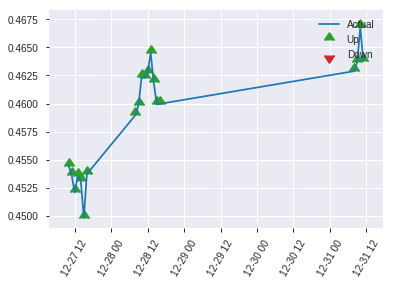


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24930333853101158
RMSE: 0.49930285251639767
LogLoss: 0.6918115850797196
Mean Per-Class Error: 0.4297906602254429
AUC: 0.5561996779388083
pr_auc: 0.5261834754977848
Gini: 0.11239935587761662
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38813477754592896: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    106  0.9217   (106.0/115.0)
1      2    106  0.0185   (2.0/108.0)
Total  11   212  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388135     0.6625    211
max f2                       0.288805     0.825688  221
max f0point5                 0.515988     0.559441  115
max accuracy                 0.533492     0.569507  87
max precision                0.738946     1         0
max recall                   0.288805     1         221
max specificity              0.738946     1         0
max absolute_mcc             0.515988     0.140464  115
max min_per_class_accuracy   0.519552     0.556522  111
max mean_per_class_accuracy  0.515988     0.570209  115

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 51.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.704827           1.37654   1.37654            0.666667         0.720943  0.666667                    0.720943            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.681594           2.06481   1.65185            1                0.697525  0.8                         0.711575            0.0185185       0.037037                   106.481   65.1852
    3        0.0313901                   0.668151           0         1.17989            0                0.669419  0.571429                    0.699531            0               0.037037                   -100      17.9894
    4        0.0403587                   0.658174           2.06481   1.37654            1                0.665889  0.666667                    0.692055            0.0185185       0.0555556                  106.481   37.6543
    5        0.0538117                   0.647766           0.688272  1.20448            0.333333         0.653101  0.583333                    0.682317            0.00925926      0.0648148                  -31.1728  20.4475
    6        0.103139                    0.610052           0.750842  0.98752            0.363636         0.630982  0.478261                    0.657765            0.037037        0.101852                   -24.9158  -1.24799
    7        0.152466                    0.594469           1.12626   1.03241            0.545455         0.601784  0.5                         0.639654            0.0555556       0.157407                   12.6263   3.24074
    8        0.201794                    0.580163           1.31397   1.10123            0.636364         0.587183  0.533333                    0.626827            0.0648148       0.222222                   31.3973   10.1235
    9        0.300448                    0.553402           1.12626   1.10945            0.545455         0.565449  0.537313                    0.606673            0.111111        0.333333                   12.6263   10.9453
    10       0.399103                    0.532011           1.31397   1.16001            0.636364         0.542311  0.561798                    0.590763            0.12963         0.462963                   31.3973   16.0008
    11       0.502242                    0.519552           0.98752   1.12459            0.478261         0.525506  0.544643                    0.577362            0.101852        0.564815                   -1.24799  12.4587
    12       0.600897                    0.502862           0.656987  1.04782            0.318182         0.510182  0.507463                    0.566333            0.0648148       0.62963                    -34.3013  4.78165
    13       0.699552                    0.477972           1.03241   1.04564            0.5              0.492256  0.50641                     0.555886            0.101852        0.731481                   3.24074   4.56434
    14       0.798206                    0.455172           0.938552  1.03241            0.454545         0.464531  0.5                         0.544595            0.0925926       0.824074                   -6.14478  3.24074
    15       0.896861                    0.42038            0.844697  1.01176            0.409091         0.435541  0.49                        0.532599            0.0833333       0.907407                   -15.5303  1.17593
    16       1                           0.287587           0.897746  1                  0.434783         0.373875  0.484305                    0.516228        

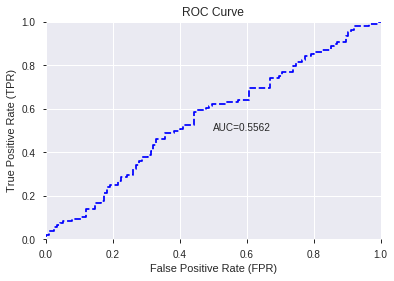

This function is available for GLM models only


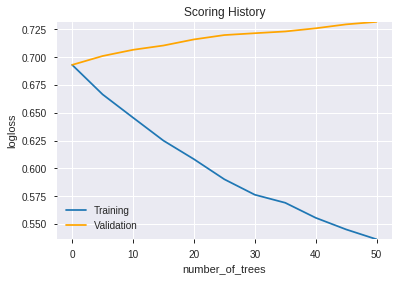

--2019-08-27 21:02:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.225.216
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.225.216|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_210111_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_210111_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'STDDEV_24',
 'BETA_12',
 'MFI_20',
 'MFI_30',
 'STOCHRSI_fastd',
 'ULTOSC',
 'MFI_8',
 'ADX_20',
 'Volume',
 'BETA_24',
 'HT_PHASOR_inphase',
 'CCI_14',
 'HT_DCPERIOD',
 'MINUS_DI_30',
 'CDLHIGHWAVE',
 'CCI_20',
 'ADOSC',
 'NATR_8',
 'MACDFIX_hist_20',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'CCI_12',
 'MFI_14',
 'STDDEV_8',
 'ADX_8',
 'STOCHRSI_fastk',
 'MOM_24',
 'SUB',
 'PLUS_DI_24',
 'ROC_24',
 'BBANDS_upperband_14_4_5',
 'CCI_8',
 'OBV',
 'PPO',
 'MACDFIX_hist_24',
 'WILLR_8',
 'SAREXT',
 'DX_8',
 'BETA_8',
 'MFI_12',
 'MINUS_DI_20',
 'LINEARREG_ANGLE_14',
 'STOCH_slowk',
 'BETA_14',
 'BBANDS_upperband_14_3_5',
 'STDDEV_20',
 'TRANGE',
 'ADX_24',
 'ATR_8',
 'MINUS_DI_12',
 'CDLSPINNINGTOP',
 'MOM_14',
 'WILLR_30',
 'aroonup_14',
 'MFI_24',
 'STOCH_slowd',
 'CCI_30',
 'BETA_20',
 'MACDFIX_hist_14',
 'MINUS_DI_24',
 'AROONOSC_14',
 'VAR_24',
 'HT_PHASOR_quadrature',
 'MACDFIX_signal_24',
 'MACDFIX_hist_8',
 'CORREL_24',
 'ADX_14',
 'CMO_8',
 'AROONOSC_24',
 

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

378

['BBANDS_upperband_14_2_5',
 'BBANDS_middleband_14_2_5',
 'BBANDS_lowerband_14_2_5',
 'MA_14_3',
 'MAVP_14_3',
 'BBANDS_upperband_14_3_2',
 'BBANDS_middleband_14_3_2',
 'BBANDS_lowerband_14_3_2',
 'BBANDS_upperband_14_3_3',
 'BBANDS_middleband_14_3_3',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_upperband_14_3_4',
 'BBANDS_middleband_14_3_4',
 'BBANDS_lowerband_14_3_4',
 'BBANDS_upperband_14_3_5',
 'BBANDS_middleband_14_3_5',
 'BBANDS_lowerband_14_3_5',
 'MA_14_4',
 'MAVP_14_4',
 'BBANDS_upperband_14_4_2',
 'BBANDS_middleband_14_4_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_14_4_3',
 'BBANDS_upperband_14_4_4',
 'BBANDS_middleband_14_4_4',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_upperband_14_4_5',
 'BBANDS_middleband_14_4_5',
 'BBANDS_lowerband_14_4_5',
 'MA_14_5',
 'MAVP_14_5',
 'BBANDS_upperband_14_5_2',
 'BBANDS_middleband_14_5_2',
 'BBANDS_lowerband_14_5_2',
 'BBANDS_upperband_14_5_3',
 'BBANDS_middleband_14_5_3',
 'BBANDS_lowerband_14_5_3',
 'BBANDS_upperband_14_5_4',
 'BBANDS_middleb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_210347_model_7  0.542593  1.008982              0.491304  0.604905  0.365910
1  DeepLearning_grid_1_AutoML_20190827_210347_model_5  0.541948  0.693337              0.491304  0.500105  0.250105
2  DeepLearning_grid_1_AutoML_20190827_210347_model_1  0.535507  2.824267              0.419646  0.671069  0.450334
3  DeepLearning_grid_1_AutoML_20190827_210347_model_3  0.529791  0.914007              0.452738  0.557791  0.311130
4  DeepLearning_grid_1_AutoML_20190827_210347_model_9  0.510306  0.693221              0.500000  0.500036  0.250036
5  DeepLearning_grid_1_AutoML_20190827_210347_model_8  0.505193  0.692609              0.500000  0.499731  0.249731
6  DeepLearning_grid_1_AutoML_20190827_210347_model_4  0.502818  1.132381              0.473913  0.606426  0.367752
7  DeepLearning_grid_1_AutoML_20190827_210347_model_2  0.498229  0.762322              0.486957  0.528581  0.279398
8               DeepLearning_1_AutoML_20190827_210347  0.482448  1.316323              0.495652  0.610113  0.372238
9  DeepLearning_grid_1_AutoML_20190827_210347_model_6  0.447907  0.698259              0.487238  0.502538  0.252544

variable  relative_importance  scaled_importance  percentage
0                HT_TRENDMODE             1.000000           1.000000    0.002866
1    BBANDS_middleband_20_6_2             0.988605           0.988605    0.002833
2                aroondown_20             0.985011           0.985011    0.002823
3                     ROCP_20             0.979232           0.979232    0.002806
4    BBANDS_middleband_20_2_5             0.976424           0.976424    0.002798
..                        ...                  ...                ...         ...
373   BBANDS_lowerband_20_0_5             0.865605           0.865605    0.002481
374   BBANDS_upperband_20_5_3             0.864495           0.864495    0.002477
375                    BETA_8             0.862610           0.862610    0.002472
376               AROONOSC_14             0.861898           0.861898    0.002470
377                    SMA_30             0.859809           0.859809    0.002464

[378 rows x 4 columns]

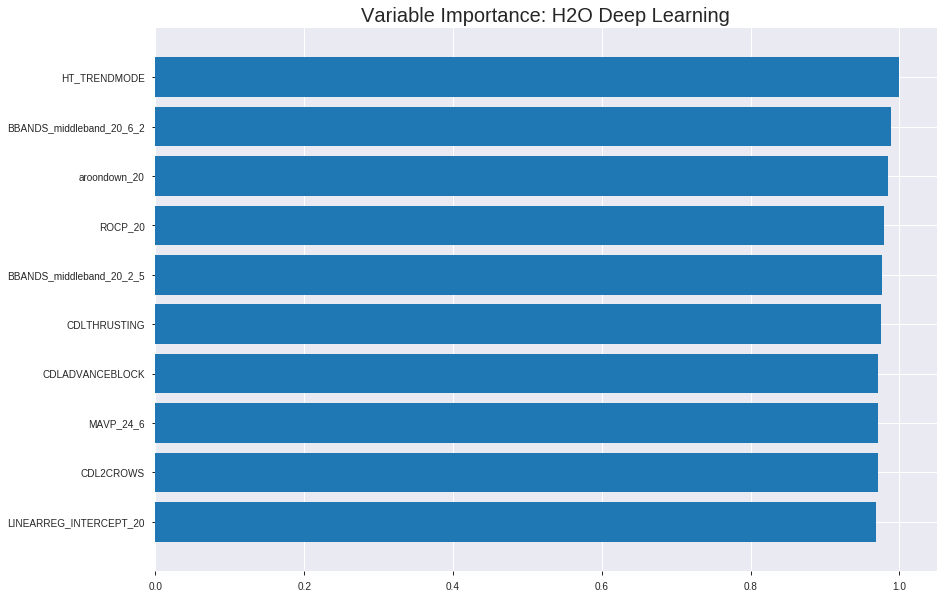

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_210347_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3323841401190034
RMSE: 0.5765276577225098
LogLoss: 0.9192974397079037
Mean Per-Class Error: 0.4312476831012021
AUC: 0.5927487687337817
pr_auc: 0.6065521198729741
Gini: 0.18549753746756337
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6401672555364969: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   718   0.9755   (718.0/736.0)
1      4    817   0.0049   (4.0/821.0)
Total  22   1535  0.4637   (722.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.640167     0.693548  377
max f2                       0.606738     0.848705  383
max f0point5                 0.803555     0.608933  231
max accuracy                 0.803555     0.581888  231
max precision                0.955729     1         0
max recall                   0.198332     1         398
max specificity              0.955729     1         0
max absolute_mcc             0.803555     0.157736  231
max min_per_class_accuracy   0.841693     0.565217  148
max mean_per_class_accuracy  0.843791     0.568752  142

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 82.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102762                   0.901891           1.54088   1.54088            0.8125           0.909377  0.8125                      0.909377            0.0158343       0.0158343                  54.088     54.088
    2        0.0205523                   0.89389            1.42235   1.48162            0.75             0.897445  0.78125                     0.903411            0.0146163       0.0304507                  42.2351    48.1615
    3        0.0301863                   0.889672           1.39074   1.45261            0.733333         0.891431  0.765957                    0.899588            0.0133983       0.043849                   39.0743    45.2614
    4        0.0404624                   0.886524           0.948234  1.32452            0.5              0.887721  0.698413                    0.896574            0.00974421      0.0535932                  -5.17661   32.4517
    5        0.0500963                   0.884665           1.51717   1.36157            0.8              0.885573  0.717949                    0.894458            0.0146163       0.0682095                  51.7174    36.1567
    6        0.100193                    0.876736           1.19137   1.27647            0.628205         0.879732  0.673077                    0.887095            0.0596833       0.127893                   19.1371    27.6469
    7        0.150289                    0.870733           1.14274   1.23189            0.602564         0.873643  0.649573                    0.882611            0.0572473       0.18514                    14.2743    23.1894
    8        0.200385                    0.866602           0.996861  1.17314            0.525641         0.868407  0.61859                     0.87906             0.0499391       0.235079                   -0.313876  17.3135
    9        0.299936                    0.859412           1.10117   1.14925            0.580645         0.862895  0.605996                    0.873695            0.109622        0.344702                   10.1175    14.9251
    10       0.400128                    0.851228           1.0698    1.12936            0.564103         0.855114  0.595506                    0.869042            0.107186        0.451888                   6.98023    12.9357
    11       0.500321                    0.841982           1.10627   1.12473            0.583333         0.846783  0.593068                    0.864585            0.11084         0.562728                   10.6273    12.4734
    12       0.599872                    0.829253           1.00329   1.10458            0.529032         0.836356  0.582441                    0.8599              0.0998782       0.662607                   0.32926    10.4581
    13       0.700064                    0.811553           1.00902   1.0909             0.532051         0.82069   0.575229                    0.854288            0.101096        0.763703                   0.901808   9.09039
    14       0.799615                    0.792019           0.954351  1.0739             0.503226         0.802794  0.566265                    0.847877            0.0950061       0.858709                   -4.56485   7.39034
    15       0.899807                    0.765409           0.717254  1.03419            0.378205         0.781205  0.545325                    0.840454            0.0718636       0.930572                   -28.2746   3.41908
    16       1                           0.189182           0.69294   1                  0.365385         0.689729  0.527296                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3742121128049371
RMSE: 0.6117287902370928
LogLoss: 1.0318246819777706
Mean Per-Class Error: 0.4781931464174455
AUC: 0.4829874175668568
pr_auc: 0.4525682841534608
Gini: -0.03402516486628637
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6410553276071762: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    229  0.9913   (229.0/231.0)
1      0    214  0        (0.0/214.0)
Total  2    443  0.5146   (229.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.641055     0.651446  397
max f2                       0.641055     0.823711  397
max f0point5                 0.641055     0.538771  397
max accuracy                 0.924115     0.519101  1
max precision                0.924115     0.5       1
max recall                   0.641055     1         397
max specificity              0.924828     0.995671  0
max absolute_mcc             0.882904     0.137107  34
max min_per_class_accuracy   0.83626      0.480519  190
max mean_per_class_accuracy  0.815784     0.521807  267

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 82.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.909928           0.831776  0.831776           0.4              0.919599  0.4                         0.919599            0.00934579      0.00934579                 -16.8224   -16.8224
    2        0.0202247                   0.900951           0.51986   0.693146           0.25             0.903475  0.333333                    0.912432            0.0046729       0.0140187                  -48.014    -30.6854
    3        0.0314607                   0.89669            0         0.445594           0                0.898497  0.214286                    0.907456            0               0.0140187                  -100       -55.4406
    4        0.0404494                   0.894646           1.03972   0.577622           0.5              0.895814  0.277778                    0.904869            0.00934579      0.0233645                  3.97196    -42.2378
    5        0.0516854                   0.889225           0.415888  0.542462           0.2              0.891481  0.26087                     0.901958            0.0046729       0.0280374                  -58.4112   -45.7538
    6        0.101124                    0.878683           1.03972   0.785566           0.5              0.883674  0.377778                    0.893019            0.0514019       0.0794393                  3.97196    -21.4434
    7        0.150562                    0.871985           0.9452    0.837983           0.454545         0.874695  0.402985                    0.887002            0.046729        0.126168                   -5.48003   -16.2017
    8        0.2                         0.867528           1.03972   0.88785            0.5              0.869783  0.426966                    0.882746            0.0514019       0.17757                    3.97196    -11.215
    9        0.301124                    0.857081           1.15524   0.977647           0.555556         0.862182  0.470149                    0.87584             0.116822        0.294393                   15.5244    -2.23532
    10       0.4                         0.845973           0.89794   0.957944           0.431818         0.852358  0.460674                    0.870035            0.088785        0.383178                   -10.206    -4.20561
    11       0.501124                    0.83626            0.970405  0.960458           0.466667         0.841346  0.461883                    0.864246            0.0981308       0.481308                   -2.9595    -3.95415
    12       0.6                         0.825457           1.27602   1.01246            0.613636         0.830841  0.486891                    0.858741            0.126168        0.607477                   27.602     1.24611
    13       0.698876                    0.813786           1.08698   1.023              0.522727         0.820236  0.491961                    0.853293            0.107477        0.714953                   8.69796    2.30039
    14       0.8                         0.796358           0.785566  0.992991           0.377778         0.805938  0.477528                    0.847308            0.0794393       0.794393                   -21.4434   -0.700935
    15       0.898876                    0.769774           0.99246   0.992932           0.477273         0.7839    0.4775                      0.840333            0.0981308       0.892523                   -0.754036  -0.706776
    16       1                           0.480557           1.06282   1                  0.511111         0.725748  0.480899      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:10:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:10:07  5.513 sec         165 obs/sec       0.40912   1             637        0.708683         4.49249             -1.01493       0.500832        0.528061           0.711175         0.472704                         0.638023           1.78029               -0.630673        0.521625          0.506681             1.24766            0.51236
    2019-08-27 21:10:24  22.172 sec        236 obs/sec       2.89338   7             4505       0.576528         0.919297            -0.333511      0.592749        0.606552           1.54088          0.463712                         0.611729           1.03182               -0.499036        0.482987          0.452568             0.831776           0.514607
    2019-08-27 21:10:39  37.253 sec        278 obs/sec       5.84329   14            9098       0.6086           1.08201             -0.486006      0.653016        0.683945           1.77794          0.459859                         0.674438           1.82779               -0.822123        0.477232          0.477163             1.24766            0.494382
    2019-08-27 21:10:55  53.302 sec        302 obs/sec       9.19332   22            14314      0.525956         0.759888            -0.109827      0.681645        0.718509           1.89647          0.411047                         0.592205           1.06623               -0.40488         0.474208          0.448631             0.415888           0.505618
    2019-08-27 21:11:10  1 min  8.776 sec  317 obs/sec       12.5157   30            19487      0.47552          0.638174            0.0928206      0.699873        0.729241           1.89647          0.387925                         0.604382           1.48388               -0.463248        0.507697          0.466375             0.831776           0.51236
    2019-08-27 21:11:26  1 min 24.218 sec  327 obs/sec       15.8426   38            24667      0.491314         0.688807            0.031556       0.749853        0.761651           1.89647          0.352601                         0.617387           1.65056               -0.526894        0.497239          0.466394             1.24766            0.505618
    2019-08-27 21:11:42  1 min 39.909 sec  333 obs/sec       19.2299   46            29941      0.468161         0.630029            0.120679       0.808285        0.823101           1.89647          0.301863                         0.600909           1.52904               -0.446477        0.494174          0.456328             0.831776           0.480899
    2019-08-27 21:11:43  1 min 41.412 sec  333 obs/sec       19.2299   46            29941      0.576528         0.919297            -0.333511      0.592749        0.606552           1.54088          0.463712                         0.611729           1.03182               -0.499036        0.482987          0.452568             0.831776           0.514607

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
HT_TRENDMODE              1.0                    1.0                  0.002865773700231484
BBANDS_middleband_20_6_2  0.9886050224304199     0.9886050224304199   0.002833118273197854
aroondown_20              0.9850109815597534     0.9850109815597534   0.0028228185653931407
ROCP_20                   0.9792318344116211     0.9792318344116211   0.0028062568374862553
BBANDS_middleband_20_2_5  0.9764240384101868     0.9764240384101868   0.0027982103295497297
---                       ---                    ---                  ---
BBANDS_lowerband_20_0_5   0.8656050562858582     0.8656050562858582   0.0024806282050914056
BBANDS_upperband_20_5_3   0.8644953966140747     0.8644953966140747   0.0024774481715878014
BETA_8                    0.862610399723053      0.862610399723053    0.002472046197072493
AROONOSC_14               0.8618976473808289     0.8618976473808289   0.0024700036101553686
SMA_30                    0.8598091006278992     0.8598091006278992   0.002464018307799119


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.547085201793722)

('F1', 0.6565349544072948)

('auc', 0.5425925925925925)

('logloss', 1.0089818586292987)

('mean_per_class_error', 0.4539049919484702)

('rmse', 0.6049051928644756)

('mse', 0.3659102923544084)

deeplearning prediction progress: |███████████████████████████████████████| 100%


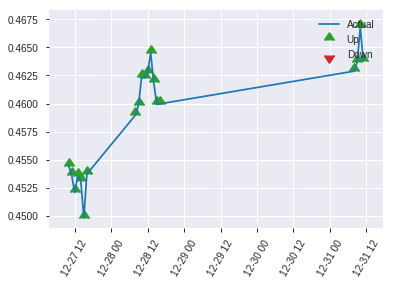


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3659102923544084
RMSE: 0.6049051928644756
LogLoss: 1.0089818586292987
Mean Per-Class Error: 0.4539049919484702
AUC: 0.5425925925925925
pr_auc: 0.5106062109754913
Gini: 0.08518518518518503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6651334289440953: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    113  0.9826   (113.0/115.0)
1      0    108  0        (0.0/108.0)
Total  2    221  0.5067   (113.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.665133     0.656535   220
max f2                       0.665133     0.826953   220
max f0point5                 0.786281     0.552885   180
max accuracy                 0.864009     0.547085   56
max precision                0.884856     0.642857   13
max recall                   0.665133     1          220
max specificity              0.930986     0.991304   0
max absolute_mcc             0.786281     0.0996209  180
max min_per_class_accuracy   0.845137     0.537037   110
max mean_per_class_accuracy  0.835875     0.546095   135

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 82.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.906743           0.688272  0.688272           0.333333         0.921653  0.333333                    0.921653            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.900546           1.03241   0.825926           0.5              0.903252  0.4                         0.914293            0.00925926      0.0185185                  3.24074   -17.4074
    3        0.0313901                   0.892706           0         0.589947           0                0.896745  0.285714                    0.909279            0               0.0185185                  -100      -41.0053
    4        0.0403587                   0.889766           2.06481   0.917695           1                0.891674  0.444444                    0.905367            0.0185185       0.037037                   106.481   -8.23045
    5        0.0538117                   0.887793           2.06481   1.20448            1                0.888758  0.583333                    0.901214            0.0277778       0.0648148                  106.481   20.4475
    6        0.103139                    0.876398           1.12626   1.16707            0.545455         0.879934  0.565217                    0.891037            0.0555556       0.12037                    12.6263   16.7069
    7        0.152466                    0.871695           1.12626   1.15387            0.545455         0.87351   0.558824                    0.885367            0.0555556       0.175926                   12.6263   15.3867
    8        0.201794                    0.868707           0.563131  1.00947            0.272727         0.870207  0.488889                    0.881661            0.0277778       0.203704                   -43.6869  0.946502
    9        0.300448                    0.86023            1.31397   1.10945            0.636364         0.864188  0.537313                    0.875924            0.12963         0.333333                   31.3973   10.9453
    10       0.399103                    0.854308           0.938552  1.06721            0.454545         0.857598  0.516854                    0.871394            0.0925926       0.425926                   -6.14478  6.72077
    11       0.502242                    0.844798           1.07729   1.06928            0.521739         0.850345  0.517857                    0.867071            0.111111        0.537037                   7.72947   6.92791
    12       0.600897                    0.836255           1.03241   1.06323            0.5              0.839761  0.514925                    0.862587            0.101852        0.638889                   3.24074   6.32255
    13       0.699552                    0.824488           0.844697  1.03241            0.409091         0.830044  0.5                         0.857998            0.0833333       0.722222                   -15.5303  3.24074
    14       0.798206                    0.789283           1.12626   1.04401            0.545455         0.808372  0.505618                    0.851865            0.111111        0.833333                   12.6263   4.40075
    15       0.896861                    0.731825           0.656987  1.00144            0.318182         0.761555  0.485                       0.841931            0.0648148       0.898148                   -34.3013  0.143519
    16       1                           0.544279           0.98752   1                  0.478261         0.689618  0.484305                    0.826221   

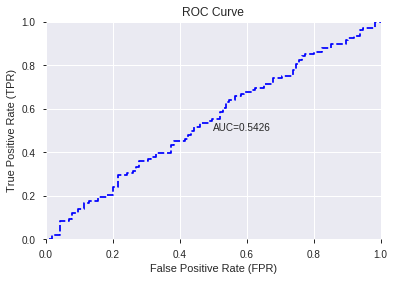

This function is available for GLM models only


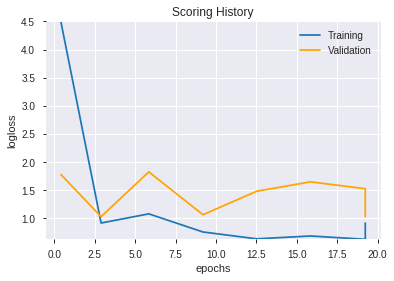

--2019-08-27 21:16:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_210347_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_210347_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_TRENDMODE',
 'BBANDS_middleband_20_6_2',
 'aroondown_20',
 'ROCP_20',
 'BBANDS_middleband_20_2_5',
 'CDLTHRUSTING',
 'CDLADVANCEBLOCK',
 'MAVP_24_6',
 'CDL2CROWS',
 'LINEARREG_INTERCEPT_20',
 'BBANDS_lowerband_30_2_4',
 'ULTOSC',
 'BBANDS_lowerband_24_7_4',
 'BBANDS_middleband_24_0_2',
 'CORREL_8',
 'BBANDS_upperband_20_1_2',
 'DX_14',
 'BETA_12',
 'ADOSC',
 'ATR_12',
 'RSI_12',
 'ROCR100_20',
 'BBANDS_upperband_30_2_3',
 'MINUS_DI_8',
 'BBANDS_lowerband_14_6_5',
 'STDDEV_12',
 'aroonup_14',
 'BBANDS_upperband_30_2_5',
 'ROC_8',
 'ROCP_24',
 'MACDFIX_hist_14',
 'ROCP_30',
 'PLUS_DI_30',
 'CDLSTALLEDPATTERN',
 'EMA_30',
 'BBANDS_lowerband_20_3_3',
 'BBANDS_upperband_20_7_4',
 'CDLGAPSIDESIDEWHITE',
 'BBANDS_upperband_20_6_3',
 'CDLMORNINGDOJISTAR',
 'CDLUNIQUE3RIVER',
 'MFI_20',
 'BETA_14',
 'CDLDRAGONFLYDOJI',
 'ADX_12',
 'BBANDS_upperband_24_0_2',
 'STDDEV_20',
 'BBANDS_middleband_14_7_2',
 'CDLLONGLEGGEDDOJI',
 'BBANDS_middleband_30_0_4',
 'MA_24_0',
 'MFI_24',
 'CDLMORNINGSTAR'

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_211617_model_1  0.557005  0.689884              0.479388  0.498375  0.248377

variable  relative_importance  scaled_importance  percentage
0                 CDLLONGLINE             0.006722           1.000000    0.018929
1                         BOP             0.006382           0.949380    0.017971
2                 CDL3OUTSIDE             0.006250           0.929819    0.017601
3                      BETA_8             0.004733           0.704070    0.013328
4                 CDLMARUBOZU             0.004540           0.675411    0.012785
..                        ...                  ...                ...         ...
373                 MAVP_20_1             0.000012           0.001755    0.000033
374              LINEARREG_20             0.000009           0.001293    0.000024
375  BBANDS_middleband_14_7_2             0.000008           0.001118    0.000021
376                   MA_14_7             0.000006           0.000830    0.000016
377                 MAVP_14_3             0.000004           0.000628    0.000012

[378 rows x 4 columns]

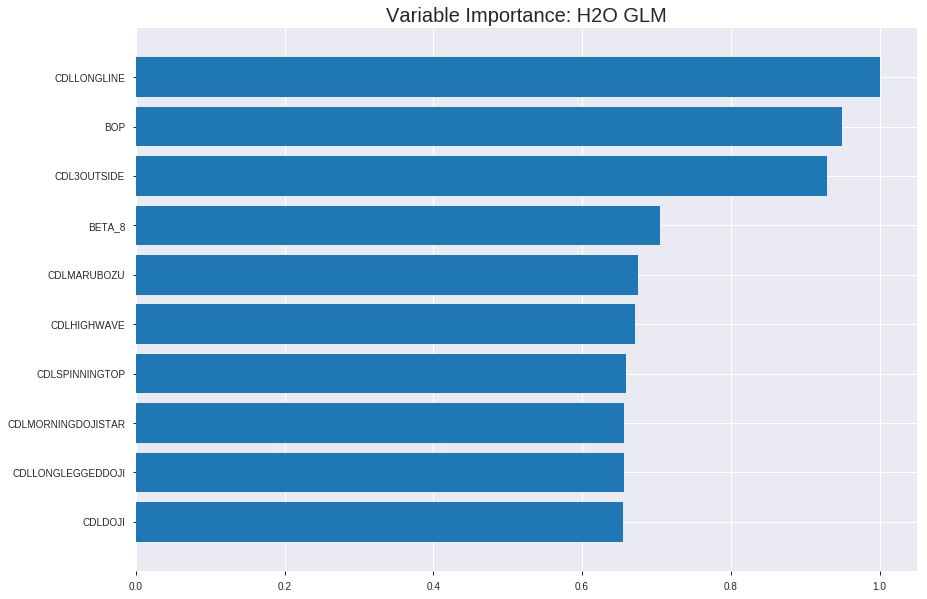

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_211617_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2464796857611061
RMSE: 0.4964672051214522
LogLoss: 0.6860856372075992
Null degrees of freedom: 1556
Residual degrees of freedom: 1178
Null deviance: 2153.817678601273
Residual deviance: 2136.470674264464
AIC: 2894.470674264464
AUC: 0.5685504157178415
pr_auc: 0.5782773340467627
Gini: 0.13710083143568297
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42626213781635885: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    732   0.9946   (732.0/736.0)
1      1    820   0.0012   (1.0/821.0)
Total  5    1552  0.4708   (733.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426262     0.691108  394
max f2                       0.414526     0.84814   398
max f0point5                 0.503136     0.594966  263
max accuracy                 0.503853     0.560694  262
max precision                0.578331     0.733333  10
max recall                   0.414526     1         398
max specificity              0.592645     0.998641  0
max absolute_mcc             0.531021     0.11159   174
max min_per_class_accuracy   0.534467     0.55163   161
max mean_per_class_accuracy  0.531841     0.555702  171

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102762                   0.577857           1.42235   1.42235            0.75             0.583369  0.75                        0.583369            0.0146163       0.0146163                  42.2351    42.2351
    2        0.0205523                   0.575295           0.948234  1.18529            0.5              0.576578  0.625                       0.579974            0.00974421      0.0243605                  -5.17661   18.5292
    3        0.0301863                   0.573077           0.885018  1.08946            0.466667         0.574261  0.574468                    0.57815             0.00852619      0.0328867                  -11.4982   8.94602
    4        0.0404624                   0.571431           1.06676   1.0837             0.5625           0.571994  0.571429                    0.576587            0.0109622       0.043849                   6.67631    8.36958
    5        0.0500963                   0.570203           1.39074   1.14274            0.733333         0.57075   0.602564                    0.575464            0.0133983       0.0572473                  39.0743    14.2743
    6        0.100193                    0.564139           1.24      1.19137            0.653846         0.566768  0.628205                    0.571116            0.0621194       0.119367                   23.9998    19.1371
    7        0.150289                    0.558794           1.14274   1.17516            0.602564         0.561565  0.619658                    0.567932            0.0572473       0.176614                   14.2743    17.5162
    8        0.200385                    0.555738           1.19137   1.17921            0.628205         0.55726   0.621795                    0.565264            0.0596833       0.236297                   19.1371    17.9214
    9        0.299936                    0.548596           0.991057  1.11676            0.522581         0.552398  0.588865                    0.560994            0.0986602       0.334957                   -0.894267  11.6764
    10       0.400128                    0.541242           1.02117   1.09283            0.538462         0.545007  0.576244                    0.556991            0.102314        0.437272                   2.11749    9.28281
    11       0.500321                    0.534628           1.11843   1.09795            0.589744         0.537977  0.578947                    0.553183            0.112058        0.54933                    11.843     9.7955
    12       0.599872                    0.525359           0.942116  1.07209            0.496774         0.530283  0.56531                     0.549383            0.0937881       0.643118                   -5.78838   7.20931
    13       0.700064                    0.514382           0.984704  1.05959            0.519231         0.519717  0.558716                    0.545137            0.0986602       0.741778                   -1.52956   5.95861
    14       0.799615                    0.498451           0.966587  1.04801            0.509677         0.507759  0.55261                     0.540484            0.0962241       0.838002                   -3.34132   4.80079
    15       0.899807                    0.480115           0.863136  1.02742            0.455128         0.489536  0.541756                    0.534811            0.0864799       0.924482                   -13.6864   2.74226
    16       1                           0.411468           0.753724  1                  0.397436         0.459809  0.527296                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25128378096334597
RMSE: 0.501282137087834
LogLoss: 0.695725741487469
Null degrees of freedom: 444
Residual degrees of freedom: 66
Null deviance: 620.0871872338774
Residual deviance: 619.1959099238475
AIC: 1377.1959099238475
AUC: 0.522970020633572
pr_auc: 0.4967352918160577
Gini: 0.045940041267144016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4507702425188882: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    228  0.987    (228.0/231.0)
1      1    213  0.0047   (1.0/214.0)
Total  4    441  0.5146   (229.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.45077      0.650382   396
max f2                       0.443225     0.822444   399
max f0point5                 0.45077      0.538423   396
max accuracy                 0.539847     0.546067   134
max precision                0.562862     0.611111   17
max recall                   0.443225     1          399
max specificity              0.573528     0.995671   0
max absolute_mcc             0.570624     0.0916667  3
max min_per_class_accuracy   0.528905     0.518692   191
max mean_per_class_accuracy  0.539847     0.540074   134

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 52.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.569761           0.415888  0.415888           0.2              0.571869  0.2                         0.571869            0.0046729       0.0046729                  -58.4112   -58.4112
    2        0.0202247                   0.565833           1.55958   0.924195           0.75             0.567327  0.444444                    0.56985             0.0140187       0.0186916                  55.9579    -7.58048
    3        0.0314607                   0.56352            1.24766   1.03972            0.6              0.564223  0.5                         0.567841            0.0140187       0.0327103                  24.7664    3.97196
    4        0.0404494                   0.562628           2.07944   1.27077            1                0.563049  0.611111                    0.566776            0.0186916       0.0514019                  107.944    27.0768
    5        0.0516854                   0.560893           0.831776  1.17534            0.4              0.561659  0.565217                    0.565663            0.00934579      0.0607477                  -16.8224   17.5335
    6        0.101124                    0.555369           0.9452    1.06282            0.454545         0.557821  0.511111                    0.561829            0.046729        0.107477                   -5.48003   6.28245
    7        0.150562                    0.55206            1.22876   1.11731            0.590909         0.553491  0.537313                    0.559091            0.0607477       0.168224                   22.876     11.7311
    8        0.2                         0.548664           0.9452    1.07477            0.454545         0.550524  0.516854                    0.556974            0.046729        0.214953                   -5.48003   7.47664
    9        0.301124                    0.543183           1.06282   1.07076            0.511111         0.546202  0.514925                    0.553356            0.107477        0.32243                    6.28245    7.0756
    10       0.4                         0.536712           1.03972   1.06308            0.5              0.539446  0.511236                    0.549918            0.102804        0.425234                   3.97196    6.30841
    11       0.501124                    0.528006           0.924195  1.03506            0.444444         0.531946  0.497758                    0.546291            0.0934579       0.518692                   -7.58048   3.50572
    12       0.6                         0.518284           0.89794   1.01246            0.431818         0.52368   0.486891                    0.542565            0.088785        0.607477                   -10.206    1.24611
    13       0.698876                    0.509222           1.03972   1.01632            0.5              0.514929  0.488746                    0.538655            0.102804        0.71028                    3.97196    1.63176
    14       0.8                         0.496445           0.970405  1.01051            0.466667         0.503319  0.485955                    0.534189            0.0981308       0.808411                   -2.9595    1.0514
    15       0.898876                    0.478632           0.99246   1.00853            0.477273         0.488272  0.485                       0.529138            0.0981308       0.906542                   -0.754036  0.852804
    16       1                           0.443225           0.924195  1                  0.444444         0.464521  0.480899                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:16:18  0.000 sec   2            4.1       379           1.37217           1.39145
    2019-08-27 21:16:19  0.315 sec   4            3         379           1.37047           1.3923
    2019-08-27 21:16:19  0.636 sec   6            2.2       379           1.36844           1.39343
    2019-08-27 21:16:19  0.944 sec   8            1.6       379           1.36605           1.39491
    2019-08-27 21:16:20  1.265 sec   10           1.2       379           1.36332           1.39685
    2019-08-27 21:16:20  1.587 sec   12           0.84      379           1.36026           1.3993

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57847533632287)

('F1', 0.6540880503144655)

('auc', 0.5570048309178744)

('logloss', 0.6898840634884984)

('mean_per_class_error', 0.4270128824476651)

('rmse', 0.498374554080535)

('mse', 0.2483771961549721)

glm prediction progress: |████████████████████████████████████████████████| 100%


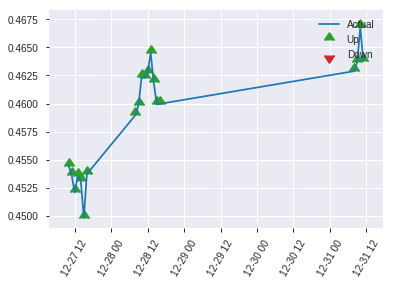


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2483771961549721
RMSE: 0.498374554080535
LogLoss: 0.6898840634884984
Null degrees of freedom: 222
Residual degrees of freedom: -156
Null deviance: 310.57429368859675
Residual deviance: 307.6882923158703
AIC: 1065.6882923158703
AUC: 0.5570048309178744
pr_auc: 0.5399609444124535
Gini: 0.1140096618357489
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45488267522615095: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    106  0.9217   (106.0/115.0)
1      4    104  0.037    (4.0/108.0)
Total  13   210  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454883     0.654088  209
max f2                       0.438213     0.824427  222
max f0point5                 0.468358     0.554299  193
max accuracy                 0.542158     0.578475  63
max precision                0.591344     1         0
max recall                   0.438213     1         222
max specificity              0.591344     1         0
max absolute_mcc             0.542158     0.158777  63
max min_per_class_accuracy   0.521572     0.521739  111
max mean_per_class_accuracy  0.53788      0.572987  71

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 51.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.580318           1.37654   1.37654            0.666667         0.584235  0.666667                    0.584235            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.578298           1.03241   1.23889            0.5              0.57914   0.6                         0.582197            0.00925926      0.0277778                  3.24074   23.8889
    3        0.0313901                   0.572124           2.06481   1.47487            1                0.575363  0.714286                    0.580244            0.0185185       0.0462963                  106.481   47.4868
    4        0.0403587                   0.570458           2.06481   1.60597            1                0.571602  0.777778                    0.578324            0.0185185       0.0648148                  106.481   60.5967
    5        0.0538117                   0.568803           0.688272  1.37654            0.333333         0.569388  0.666667                    0.57609             0.00925926      0.0740741                  -31.1728  37.6543
    6        0.103139                    0.560911           0.750842  1.07729            0.363636         0.564319  0.521739                    0.57046             0.037037        0.111111                   -24.9158  7.72947
    7        0.152466                    0.555748           1.31397   1.15387            0.636364         0.558204  0.558824                    0.566495            0.0648148       0.175926                   31.3973   15.3867
    8        0.201794                    0.551605           1.31397   1.193              0.636364         0.553364  0.577778                    0.563285            0.0648148       0.240741                   31.3973   19.3004
    9        0.300448                    0.540244           1.22012   1.20191            0.590909         0.546084  0.58209                     0.557637            0.12037         0.361111                   22.0118   20.1907
    10       0.399103                    0.52886            0.938552  1.13681            0.454545         0.535285  0.550562                    0.552112            0.0925926       0.453704                   -6.14478  13.6808
    11       0.502242                    0.521572           0.718196  1.05084            0.347826         0.524859  0.508929                    0.546515            0.0740741       0.527778                   -28.1804  5.08433
    12       0.600897                    0.508324           0.938552  1.03241            0.454545         0.514469  0.5                         0.541254            0.0925926       0.62037                    -6.14478  3.24074
    13       0.699552                    0.497283           1.12626   1.04564            0.545455         0.50292   0.50641                     0.535848            0.111111        0.731481                   12.6263   4.56434
    14       0.798206                    0.476467           1.03241   1.04401            0.5              0.489347  0.505618                    0.530101            0.101852        0.833333                   3.24074   4.40075
    15       0.896861                    0.46175            0.750842  1.01176            0.363636         0.469701  0.49                        0.523457            0.0740741       0.907407                   -24.9158  1.17593
    16       1                           0.438213           0.897746  1                  0.434783         0.452264  0.484305                    0.516114         

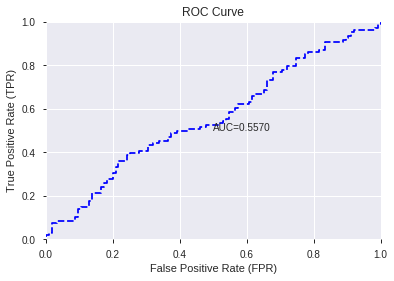

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


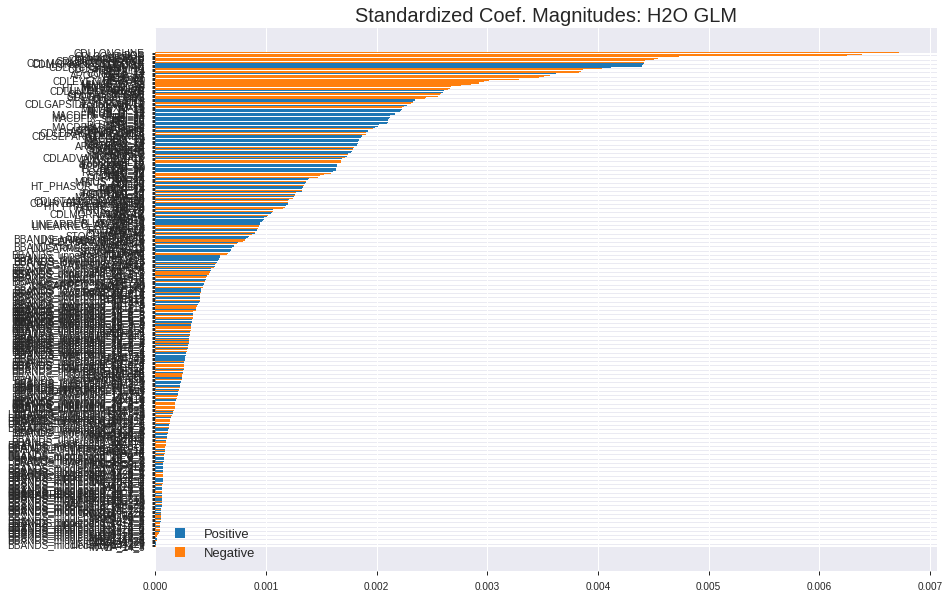

'log_likelihood'
--2019-08-27 21:16:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_211617_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_211617_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLLONGLINE',
 'BOP',
 'CDL3OUTSIDE',
 'BETA_8',
 'CDLMARUBOZU',
 'CDLHIGHWAVE',
 'CDLSPINNINGTOP',
 'CDLMORNINGDOJISTAR',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'aroonup_14',
 'CDLSHORTLINE',
 'BETA_14',
 'CORREL_14',
 'BETA_12',
 'AROONOSC_14',
 'ADX_14',
 'ADX_12',
 'ADOSC',
 'BETA_20',
 'CDLEVENINGSTAR',
 'ADXR_12',
 'MINUS_DI_30',
 'MINUS_DI_24',
 'MINUS_DI_20',
 'HT_TRENDMODE',
 'ADX_20',
 'CDL2CROWS',
 'CDLUNIQUE3RIVER',
 'MFI_30',
 'CDLTASUKIGAP',
 'STOCHRSI_fastk',
 'CDLTHRUSTING',
 'OBV',
 'MINUS_DI_14',
 'PLUS_DI_8',
 'CCI_12',
 'aroondown_14',
 'CDLGAPSIDESIDEWHITE',
 'DX_8',
 'ADXR_14',
 'MINUS_DI_12',
 'PLUS_DI_14',
 'PLUS_DI_20',
 'PLUS_DI_12',
 'PLUS_DI_24',
 'MACDFIX_signal_14',
 'RSI_24',
 'MACDFIX_signal_20',
 'CMO_20',
 'RSI_20',
 'RSI_30',
 'MFI_12',
 'PLUS_DI_30',
 'TRIX_14',
 'MACDFIX_signal_24',
 'MACD_signal',
 'STOCHF_fastk',
 'AROONOSC_12',
 'PLUS_DM_8',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLSEPARATINGLINES',
 'MACDFIX_14',
 'MACDFIX_20',
 

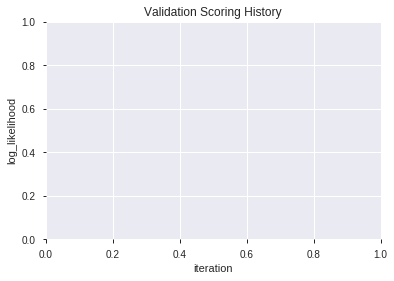

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_211639_model_4  0.561755  0.690513              0.453583  0.498640  0.248642
1  XGBoost_grid_1_AutoML_20190827_211639_model_6  0.537681  0.701808              0.470411  0.504114  0.254131
2               XGBoost_2_AutoML_20190827_211639  0.532045  0.715817              0.453865  0.509863  0.259961
3               XGBoost_1_AutoML_20190827_211639  0.531884  0.710641              0.470411  0.507885  0.257947
4  XGBoost_grid_1_AutoML_20190827_211639_model_1  0.521176  0.703037              0.478824  0.504727  0.254749
5  XGBoost_grid_1_AutoML_20190827_211639_model_7  0.506602  0.720444              0.450081  0.512656  0.262816
6               XGBoost_3_AutoML_20190827_211639  0.505153  0.714061              0.452738  0.509637  0.259730
7  XGBoost_grid_1_AutoML_20190827_211639_model_2  0.504187  0.705342              0.469847  0.505867  0.255902
8  XGBoost_grid_1_AutoML_20190827_211639_model_3  0.494605  0.713069              0.474477  0.509526  0.259617
9  XGBoost_grid_1_AutoML_20190827_211639_model_5  0.487923  0.751582              0.491586  0.524940  0.275562

variable  relative_importance  scaled_importance  percentage
0                         BOP           113.754303           1.000000    0.039543
1                       ADOSC            97.428665           0.856483    0.033868
2                     BETA_12            93.792000           0.824514    0.032604
3                      MFI_24            83.419296           0.733329    0.028998
4                      TRANGE            73.368469           0.644973    0.025504
..                        ...                  ...                ...         ...
125                PLUS_DM_20             4.955328           0.043562    0.001723
126  BBANDS_middleband_24_1_2             4.800951           0.042205    0.001669
127                 CORREL_12             4.731938           0.041598    0.001645
128                AROONOSC_8             4.184562           0.036786    0.001455
129                    ATR_20             3.941522           0.034649    0.001370

[130 rows x 4 columns]

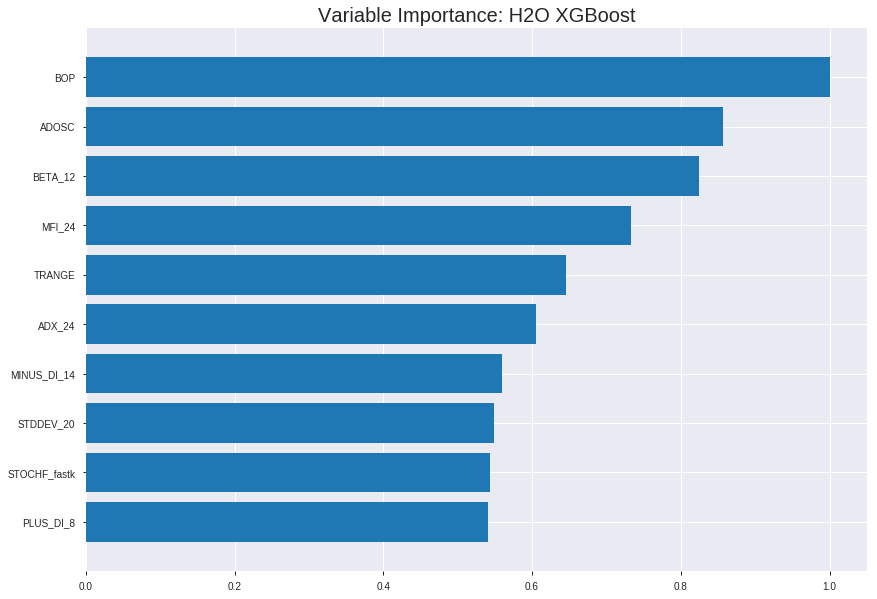

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_211639_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21367974802243295
RMSE: 0.4622550681414244
LogLoss: 0.6190222190535442
Mean Per-Class Error: 0.2678591524122227
AUC: 0.8060904649684902
pr_auc: 0.8259552965314567
Gini: 0.6121809299369805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48975928127765656: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      390  346   0.4701   (346.0/736.0)
1      110  711   0.134    (110.0/821.0)
Total  500  1057  0.2929   (456.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489759     0.757188  243
max f2                       0.431479     0.859763  317
max f0point5                 0.557061     0.760971  153
max accuracy                 0.530454     0.73025   190
max precision                0.748764     1         0
max recall                   0.329948     1         394
max specificity              0.748764     1         0
max absolute_mcc             0.540217     0.464647  177
max min_per_class_accuracy   0.530454     0.729598  190
max mean_per_class_accuracy  0.540217     0.732141  177

Gains/Lift Table: Avg response rate: 52.73 %, avg score: 52.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.687946           1.89647   1.89647            1                0.708881  1                           0.708881            0.0194884       0.0194884                  89.6468   89.6468
    2        0.0205523                   0.674998           1.89647   1.89647            1                0.681012  1                           0.694947            0.0194884       0.0389769                  89.6468   89.6468
    3        0.0301863                   0.66451            1.89647   1.89647            1                0.670036  1                           0.686997            0.0182704       0.0572473                  89.6468   89.6468
    4        0.0404624                   0.65615            1.77794   1.86637            0.9375           0.660105  0.984127                    0.680167            0.0182704       0.0755177                  77.7938   86.6365
    5        0.0500963                   0.65087            1.77004   1.84784            0.933333         0.654198  0.974359                    0.675173            0.0170524       0.09257                    77.0037   84.784
    6        0.100193                    0.629501           1.67764   1.76274            0.884615         0.639554  0.929487                    0.657363            0.0840438       0.176614                   67.7645   76.2742
    7        0.150289                    0.61379            1.75059   1.75869            0.923077         0.621245  0.92735                     0.645324            0.0876979       0.264312                   75.0586   75.869
    8        0.200385                    0.596431           1.6047    1.72019            0.846154         0.605655  0.907051                    0.635407            0.0803898       0.344702                   60.4703   72.0193
    9        0.299936                    0.572823           1.43153   1.62438            0.754839         0.584097  0.856531                    0.618377            0.142509        0.487211                   43.1527   62.4383
    10       0.400128                    0.55395            1.22784   1.52509            0.647436         0.56319   0.804173                    0.604558            0.123021        0.610231                   22.7841   52.5089
    11       0.500321                    0.532886           1.05765   1.43148            0.557692         0.54368   0.754814                    0.592367            0.105968        0.7162                     5.76455   43.148
    12       0.599872                    0.511106           0.90541   1.34418            0.477419         0.522241  0.708779                    0.580729            0.090134        0.806334                   -9.45896  34.4177
    13       0.700064                    0.482768           0.717254  1.25445            0.378205         0.497666  0.661468                    0.568841            0.0718636       0.878197                   -28.2746  25.4453
    14       0.799615                    0.454733           0.562823  1.16835            0.296774         0.468351  0.616064                    0.55633             0.0560292       0.934227                   -43.7177  16.8346
    15       0.899807                    0.413547           0.413333  1.08428            0.217949         0.436392  0.571734                    0.542975            0.0414129       0.975639                   -58.6667  8.4276
    16       1                           0.271748           0.243137  1                  0.128205         0.380062  0.527296                    0.526653            0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26138379568185555
RMSE: 0.5112570739675447
LogLoss: 0.7166886194646961
Mean Per-Class Error: 0.4790326495933972
AUC: 0.48139944167981547
pr_auc: 0.46560965704924906
Gini: -0.03720111664036907
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3820318877696991: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    214  0        (0.0/214.0)
Total  0    445  0.5191   (231.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382032     0.649469  399
max f2                       0.382032     0.822444  399
max f0point5                 0.382032     0.53661   399
max accuracy                 0.593537     0.530337  104
max precision                0.593537     0.522124  104
max recall                   0.382032     1         399
max specificity              0.722184     0.995671  0
max absolute_mcc             0.430311     0.121997  381
max min_per_class_accuracy   0.549422     0.495327  201
max mean_per_class_accuracy  0.593537     0.520967  104

Gains/Lift Table: Avg response rate: 48.09 %, avg score: 54.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.702671           0.415888  0.415888           0.2              0.707834  0.2                         0.707834            0.0046729       0.0046729                  -58.4112  -58.4112
    2        0.0202247                   0.68198            0.51986   0.462098           0.25             0.688859  0.222222                    0.699401            0.0046729       0.00934579                 -48.014   -53.7902
    3        0.0314607                   0.668035           0.415888  0.445594           0.2              0.673799  0.214286                    0.690257            0.0046729       0.0140187                  -58.4112  -55.4406
    4        0.0404494                   0.66216            1.03972   0.577622           0.5              0.665515  0.277778                    0.684759            0.00934579      0.0233645                  3.97196   -42.2378
    5        0.0516854                   0.652161           1.24766   0.723283           0.6              0.6578    0.347826                    0.678898            0.0140187       0.0373832                  24.7664   -27.6717
    6        0.101124                    0.625706           1.4178    1.06282            0.681818         0.637735  0.511111                    0.658774            0.0700935       0.107477                   41.7799   6.28245
    7        0.150562                    0.614733           0.85068   0.993165           0.409091         0.620317  0.477612                    0.646146            0.0420561       0.149533                   -14.932   -0.683498
    8        0.2                         0.603122           1.03972   1.00467            0.5              0.608386  0.483146                    0.636812            0.0514019       0.200935                   3.97196   0.46729
    9        0.301124                    0.584653           1.10903   1.03972            0.533333         0.593864  0.5                         0.622389            0.11215         0.313084                   10.9034   3.97196
    10       0.4                         0.5656             0.89794   1.00467            0.431818         0.575373  0.483146                    0.610767            0.088785        0.401869                   -10.206   0.46729
    11       0.501124                    0.549072           0.924195  0.988433           0.444444         0.55746   0.475336                    0.60001             0.0934579       0.495327                   -7.58048  -1.1567
    12       0.6                         0.535339           0.75616   0.950156           0.363636         0.541967  0.456929                    0.590445            0.0747664       0.570093                   -24.384   -4.98442
    13       0.698876                    0.514714           1.08698   0.969513           0.522727         0.524937  0.466238                    0.581177            0.107477        0.67757                    8.69796   -3.04865
    14       0.8                         0.493443           0.970405  0.969626           0.466667         0.503907  0.466292                    0.57141             0.0981308       0.775701                   -2.9595   -3.03738
    15       0.898876                    0.461739           1.13424   0.987734           0.545455         0.477503  0.475                       0.56108             0.11215         0.88785                    13.424    -1.22664
    16       1                           0.382032           1.10903   1                  0.533333         0.434017  0.480899                    0.5482


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:16:53  5.785 sec   0                  0.5              0.693147            0.5             0                  1                0.472704                         0.5                0.693147              0.5               0                    1                  0.519101
    2019-08-27 21:16:53  6.253 sec   5                  0.494516         0.682227            0.667389        0.681657           1.72406          0.421965                         0.500472           0.694094              0.510347          0.492303             0                  0.519101
    2019-08-27 21:16:54  6.408 sec   10                 0.489916         0.673123            0.708577        0.719969           1.89647          0.351317                         0.501618           0.696404              0.498311          0.476091             0                  0.501124
    2019-08-27 21:16:54  6.560 sec   15                 0.485776         0.664969            0.730937        0.736497           1.89647          0.360951                         0.502347           0.697891              0.498594          0.46849              0.831776           0.510112
    2019-08-27 21:16:54  6.723 sec   20                 0.481833         0.657206            0.737454        0.75744            1.89647          0.378292                         0.503704           0.700668              0.494073          0.471271             0.415888           0.519101
    2019-08-27 21:16:54  6.883 sec   25                 0.478108         0.649904            0.754371        0.772862           1.89647          0.318561                         0.504311           0.701889              0.492181          0.480827             1.24766            0.519101
    2019-08-27 21:16:54  7.045 sec   30                 0.474564         0.642969            0.767224        0.784541           1.89647          0.337829                         0.506016           0.705402              0.487306          0.479733             0.831776           0.519101
    2019-08-27 21:16:54  7.200 sec   35                 0.471756         0.637487            0.776446        0.792495           1.89647          0.30957                          0.507699           0.708886              0.479366          0.478183             1.24766            0.519101
    2019-08-27 21:16:54  7.364 sec   40                 0.468332         0.630851            0.787913        0.803066           1.89647          0.307001                         0.508384           0.710395              0.480014          0.468355             0.415888           0.519101
    2019-08-27 21:16:55  7.530 sec   45                 0.465261         0.624887            0.801057        0.82023            1.89647          0.279383                         0.510691           0.715317              0.478628          0.465835             0.415888           0.519101
    2019-08-27 21:16:55  7.695 sec   50                 0.462255         0.619022            0.80609         0.825955           1.89647          0.292871                         0.511257           0.716689              0.481399          0.46561              0.415888           0.519101

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
BOP                       113.75430297851562     1.0                   0.03954321014663237
ADOSC                     97.42866516113281      0.8564833383009153    0.033868100633522316
BETA_12                   93.79199981689453      0.8245138633094934    0.03260392496565902
MFI_24                    83.41929626464844      0.7333287100392462    0.028998171287640748
TRANGE                    73.36846923828125      0.6449731334746791    0.025504308155921206
---                       ---                    ---                   ---
PLUS_DM_20                4.955327987670898      0.043561675100824926  0.0017225684728512428
BBANDS_middleband_24_1_2  4.80095100402832       0.04220456614230285   0.001668904028112527
CORREL_12                 4.731937885284424      0.04159788035603478   0.0016449137245731539
AROONOSC_8                4.1845622062683105     0.0367859685014169    0.0014546352828989277
ATR_20                    3.941521644592285      0.03464942900082388   0.0013701496524403966


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5695067264573991)

('F1', 0.6645161290322581)

('auc', 0.5617552334943638)

('logloss', 0.6905125303181023)

('mean_per_class_error', 0.43260869565217397)

('rmse', 0.498640100836508)

('mse', 0.24864195016224286)

xgboost prediction progress: |████████████████████████████████████████████| 100%


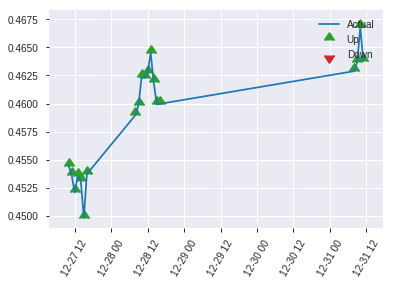


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24864195016224286
RMSE: 0.498640100836508
LogLoss: 0.6905125303181023
Mean Per-Class Error: 0.43260869565217397
AUC: 0.5617552334943638
pr_auc: 0.5295400944156169
Gini: 0.1235104669887277
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43579936027526855: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   99   0.8609   (99.0/115.0)
1      5    103  0.0463   (5.0/108.0)
Total  21   202  0.4664   (104.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435799     0.664516  201
max f2                       0.36766      0.826953  220
max f0point5                 0.474408     0.56432   178
max accuracy                 0.56674      0.569507  71
max precision                0.660563     0.666667  5
max recall                   0.36766      1         220
max specificity              0.70391      0.991304  0
max absolute_mcc             0.435799     0.158849  201
max min_per_class_accuracy   0.528199     0.53913   111
max mean_per_class_accuracy  0.545007     0.567391  95

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 53.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.684888           0.688272  0.688272           0.333333         0.695204  0.333333                    0.695204            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.664595           2.06481   1.23889            1                0.673666  0.6                         0.686589            0.0185185       0.0277778                  106.481   23.8889
    3        0.0313901                   0.657124           1.03241   1.17989            0.5              0.660235  0.571429                    0.679059            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.649133           1.03241   1.14712            0.5              0.653147  0.555556                    0.673301            0.00925926      0.0462963                  3.24074   14.7119
    5        0.0538117                   0.645876           1.37654   1.20448            0.666667         0.647531  0.583333                    0.666858            0.0185185       0.0648148                  37.6543   20.4475
    6        0.103139                    0.617835           1.12626   1.16707            0.545455         0.627631  0.565217                    0.648097            0.0555556       0.12037                    12.6263   16.7069
    7        0.152466                    0.603195           0.938552  1.09314            0.454545         0.610335  0.529412                    0.63588             0.0462963       0.166667                   -6.14478  9.31373
    8        0.201794                    0.591787           1.31397   1.14712            0.636364         0.596124  0.555556                    0.626162            0.0648148       0.231481                   31.3973   14.7119
    9        0.300448                    0.569126           1.22012   1.17109            0.590909         0.578806  0.567164                    0.610612            0.12037         0.351852                   22.0118   17.1089
    10       0.399103                    0.549971           1.03241   1.13681            0.5              0.562831  0.550562                    0.598801            0.101852        0.453704                   3.24074   13.6808
    11       0.502242                    0.528199           0.897746  1.08771            0.434783         0.540157  0.526786                    0.586758            0.0925926       0.546296                   -10.2254  8.77149
    12       0.600897                    0.516665           0.844697  1.04782            0.409091         0.522653  0.507463                    0.576233            0.0833333       0.62963                    -15.5303  4.78165
    13       0.699552                    0.494374           0.844697  1.01917            0.409091         0.503684  0.49359                     0.566002            0.0833333       0.712963                   -15.5303  1.91714
    14       0.798206                    0.474937           1.40783   1.06721            0.681818         0.485571  0.516854                    0.556061            0.138889        0.851852                   40.7828   6.72077
    15       0.896861                    0.440118           0.844697  1.04273            0.409091         0.458428  0.505                       0.545321            0.0833333       0.935185                   -15.5303  4.27315
    16       1                           0.327825           0.628422  1                  0.304348         0.402081  0.484305                    0.530548        

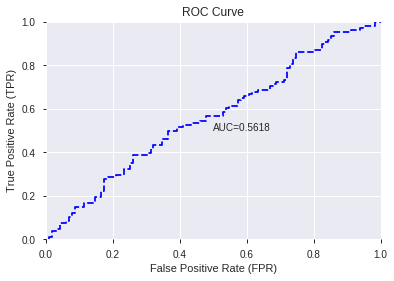

This function is available for GLM models only


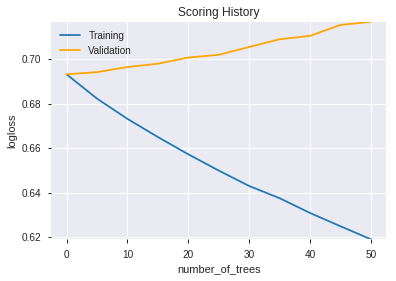

--2019-08-27 21:17:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.184
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.184|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_211639_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_211639_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a5c4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'ADOSC',
 'BETA_12',
 'MFI_24',
 'TRANGE',
 'ADX_24',
 'MINUS_DI_14',
 'STDDEV_20',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'STOCHRSI_fastd',
 'ROC_24',
 'BETA_14',
 'ADX_20',
 'BETA_20',
 'CORREL_20',
 'ATR_8',
 'MINUS_DI_30',
 'MFI_12',
 'MACDFIX_hist_24',
 'LINEARREG_SLOPE_8',
 'CCI_30',
 'PLUS_DM_24',
 'NATR_8',
 'MFI_20',
 'MINUS_DI_20',
 'MACDFIX_hist_8',
 'BETA_8',
 'STDDEV_12',
 'HT_PHASOR_quadrature',
 'OBV',
 'ROC_14',
 'HT_PHASOR_inphase',
 'ADXR_12',
 'LINEARREG_INTERCEPT_20',
 'MFI_8',
 'PLUS_DI_24',
 'CCI_8',
 'ROC_30',
 'PLUS_DM_30',
 'BBANDS_upperband_20_3_2',
 'MOM_20',
 'AROONOSC_24',
 'AD',
 'STOCH_slowk',
 'BBANDS_upperband_30_2_5',
 'MACDFIX_hist_14',
 'MFI_30',
 'LINEARREG_ANGLE_12',
 'MINUS_DM_14',
 'PLUS_DI_30',
 'AROONOSC_12',
 'STDDEV_14',
 'TRIX_14',
 'PLUS_DI_14',
 'CDLSPINNINGTOP',
 'aroondown_30',
 'aroonup_14',
 'APO',
 'PLUS_DI_20',
 'NATR_12',
 'aroonup_30',
 'CORREL_14',
 'BBANDS_lowerband_20_5_5',
 'ADX_12',
 'TRIX_8',
 'BBANDS_lowerband_14_5_2',
 'R

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.570
GLM             0.583
XGBoost         0.570
dtype: float64

DeepLearning    GLM  XGBoost
All          0.565  0.583    0.570
DLF          0.570  0.565    0.538
Fwe          0.525  0.583    0.570
RFE          0.547  0.578    0.570
XGBF         0.565  0.565    0.538





F1


DeepLearning    0.659
GLM             0.659
XGBoost         0.665
dtype: float64

DeepLearning    GLM  XGBoost
All          0.656  0.656    0.663
DLF          0.659  0.659    0.660
Fwe          0.657  0.656    0.663
RFE          0.657  0.654    0.665
XGBF         0.659  0.659    0.660





auc


DeepLearning    0.559
GLM             0.571
XGBoost         0.562
dtype: float64

DeepLearning    GLM  XGBoost
All          0.548  0.571    0.556
DLF          0.559  0.543    0.506
Fwe          0.504  0.571    0.556
RFE          0.543  0.557    0.562
XGBF         0.534  0.543    0.506





logloss


DeepLearning    1.009
GLM             0.692
XGBoost         0.713
dtype: float64

DeepLearning    GLM  XGBoost
All          0.708  0.689    0.692
DLF          0.693  0.692    0.713
Fwe          0.769  0.689    0.692
RFE          1.009  0.690    0.691
XGBF         0.693  0.692    0.713





mean_per_class_error


DeepLearning    0.465
GLM             0.442
XGBoost         0.450
dtype: float64

DeepLearning    GLM  XGBoost
All          0.437  0.423    0.430
DLF          0.432  0.442    0.450
Fwe          0.465  0.423    0.430
RFE          0.454  0.427    0.433
XGBF         0.442  0.442    0.450





rmse


DeepLearning    0.605
GLM             0.499
XGBoost         0.509
dtype: float64

DeepLearning    GLM  XGBoost
All          0.507  0.498    0.499
DLF          0.500  0.499    0.509
Fwe          0.533  0.498    0.499
RFE          0.605  0.498    0.499
XGBF         0.500  0.499    0.509





mse


DeepLearning    0.366
GLM             0.249
XGBoost         0.259
dtype: float64

DeepLearning    GLM  XGBoost
All          0.257  0.248    0.249
DLF          0.250  0.249    0.259
Fwe          0.284  0.248    0.249
RFE          0.366  0.248    0.249
XGBF         0.250  0.249    0.259

{'F1':       DeepLearning    GLM  XGBoost
 All          0.656    NaN      NaN
 DLF          0.659    NaN      NaN
 DLF            NaN  0.659      NaN
 DLF            NaN    NaN    0.660
 All            NaN  0.656      NaN
 All            NaN    NaN    0.663
 XGBF         0.659    NaN      NaN
 XGBF           NaN  0.659      NaN
 XGBF           NaN    NaN    0.660
 Fwe          0.657    NaN      NaN
 Fwe            NaN  0.656      NaN
 Fwe            NaN    NaN    0.663
 RFE          0.657    NaN      NaN
 RFE            NaN  0.654      NaN
 RFE            NaN    NaN    0.665,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.565    NaN      NaN
 DLF          0.570    NaN      NaN
 DLF            NaN  0.565      NaN
 DLF            NaN    NaN    0.538
 All            NaN  0.583      NaN
 All            NaN    NaN    0.570
 XGBF         0.565    NaN      NaN
 XGBF           NaN  0.565      NaN
 XGBF           NaN    NaN    0.538
 Fwe          0.525    NaN      NaN
 Fwe     